# Sentiment analysis on news headlines

The goal of this project is to test the hypothesized advantages of using and fine-tuning pre-trained language models of BERT (Bidirectional Encoder Representations from Transformers), which is a 2018 paper published by researchers at Google AI Language, for financial domain. For that, sentiment of a sentence from a financial news article towards the financial actor depicted in the sentence will be tried to be predicted, using the Financial PhraseBank created by Malo et al. from Cornell University. (2014)

<table><tr><td>
<img src="./docs/bert_context.png" width="400">
</td><td>
<img src="./docs/bert_structure2.png" width="600">
</td></tr></table>

<br />
<br />

The models tested in this projects are as follows:
<br />
 * A. Lexicon-based approach (Loughran and McDonald Dictionary)
 * B. Tfidf
 * C. LSTM (RNN)
 * D. LSTM with GloVe word embedding
 * E. Bert (pre-trained, hugging-face impementation)
<br />
<br />
<br />

![All Models](./docs/all_models.png)

## Import and configurations

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.0.1.post1    
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.2.0         
audioread                     2.1.8          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.1.5          
blis                          0.4.

In [3]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    #!pip install numpy==1.16.4
    #!pip install pandas==0.25.0
    #!pip install torch==1.4.0
    #!pip install tqdm==4.43.0
    !pip install scikit-plot transformers



     |████████████████████████████████| 890kB 8.2MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 
     |████████████████████████████████| 3.0MB 48.1MB/s 
     |████████████████████████████████| 1.1MB 59.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=56218266296e3ba5a9083864b1f8d46d531a64371207496c6fbacdd4d8ab0910
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
import torch
# Check GPU Device
if IN_COLAB:
    print(torch.cuda.get_device_name(0))

Tesla T4


In [6]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [7]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [8]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [9]:
# Mount Google Drive
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
if IN_COLAB:
    finphrase_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    finphrase_dir = './data/FinancialPhraseBank-v1.0/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

## Evaluation

In [11]:
result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C: LSTM', 'D: LSTM+GloVe', 'E: BERT', 'F: ALBERT'])
result_df

Accuracy   F1
A: Lexicon         NaN  NaN
B: Tfidf           NaN  NaN
C: LSTM            NaN  NaN
D: LSTM+GloVe      NaN  NaN
E: BERT            NaN  NaN
F: ALBERT          NaN  NaN

### Metrics
As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [12]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

### Cross validation
Use Stratified KFold because the input data is imbalanced and better to retain the same ratio for cross validation.

In [13]:
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

## Load input data
Financial Phrasebank ([Malo et al. (2014)](https://www.researchgate.net/publication/251231107_Good_Debt_or_Bad_Debt_Detecting_Semantic_Orientations_in_Economic_Texts)) consists of 4845 english sentences selected randomly from financial news found on LexisNexis database. These sentences then were annotated by 16 people with background in finance and business. The annotators were asked to give labels according to how they think the information in the sentence might affect the mentioned company stock price. The dataset also includes information regarding the agreement levels on sentences among
annotators.

Note: Please make sure to abid by the license and copyright for the use of the data. Please check with the author.

Download the data from this [link](https://www.researchgate.net/profile/Pekka_Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip?origin=publication_list) and unzip it under `finphrase_dir` set above.

In [14]:
def load_finphrase(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    df = pd.read_csv(finphrase_dir + filename,
                     sep='\@',
                     engine='python',
                     header=None,
                     names=['sentence','label'])
    print('Total number of record in the file: ', df.shape[0])
    df.drop_duplicates(inplace=True)
    print('Total number of record after dropping duplicates: ', df.shape[0])
    print('Missing label: ', df['label'].isnull().sum())
    df.reset_index(inplace=True, drop=True)
    # df = pd.get_dummies(df, columns=['label'])
    return df

In [15]:
# Load data - select which consensus level you want to use
# filename = 'Sentences_66Agree.txt'
# filename = 'Sentences_50Agree.txt'
filename = 'Sentences_75Agree.txt'
# filename = 'Sentences_AllAgree.txt'

train_df = load_finphrase(filename)

# Samples
pd.set_option('display.max_colwidth', -1)
train_df.sample(n=20, random_state=42)

Total number of record in the file:  3453
Total number of record after dropping duplicates:  3448
Missing label:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


sentence     label
2900  The period-end cash and cash equivalents totaled EUR6 .5 m , compared to EUR10 .5 m in the previous year .                                                                                                                                                                                        negative
51    In June it sold a 30 percent stake to Nordstjernan , and the investment group has now taken up the option to acquire EQT 's remaining shares .                                                                                                                                                    neutral 
567   The aim is an annual improvement in Ruukki Construction 's operating profit of more than EUR 3 million USD 4.1 m starting in 2009 .                                                                                                                                                               positive
3268  Sampo Bank 's market share of lending was 13.6 % , down from 14.4 % in the first quarter of 2008 .                                                                                                                                                                                                negative
1987  In 2008 , the steel industry accounted for 64 percent of the cargo volumes transported , whereas the energy industry accounted for 28 percent and other industries for 8 percent .                                                                                                                neutral 
1873  An earn-out payment of up to 4.0 mln euro ( $ 5.3 mln ) can also be paid depending on Intellibis financial performance in 2007 .                                                                                                                                                                  neutral 
229   Profit for the period totaled EUR 39.4 mn , up from EUR 33.9 mn in the corresponding period in 2006 .                                                                                                                                                                                             positive
298   Operating profit of the Asian plants grew markedly .                                                                                                                                                                                                                                              positive
605   Finnish steel maker Rautaruukki Oyj ( Ruukki ) said on July 7 , 2008 that it won a 9.0 mln euro ( $ 14.1 mln ) contract to supply and install steel superstructures for Partihallsforbindelsen bridge project in Gothenburg , western Sweden .                                                    positive
705   The rationalization of the operations seeks to achieve over EUR 1 million in yearly savings as from the second quarter of the current financial year .                                                                                                                                            positive
2713  The expanded company will continue to be called NewPage .                                                                                                                                                                                                                                         neutral 
1650  Our customers come from the following countries : UK , USA , Spain , France , Italy , Germany , China , Hong Kong , Sweden , Norway , Netherlands , Austria , Belgium , Switzerland , Czech Republic , Finland , Canada , Russia , Ukraine , Denmark , Ireland , South Korea and Liechtenstein .  neutral 
2126  ST. PETERSBURG , Oct 14 ( PRIME-TASS ) -- Finnish tire producer Nokian Tyres plans to invest about 50 million euros in the expansion of its tire plant in the city of Vsevolozhsk in Russia 's Leningrad Region in 2011 , the company 's President Kim Gran told reporters Thursday .             positive
945   The new B 

In [16]:
# Change the table display config back
pd.set_option('display.max_colwidth', 50)

Text(0.5, 1.0, 'The number of words per data')

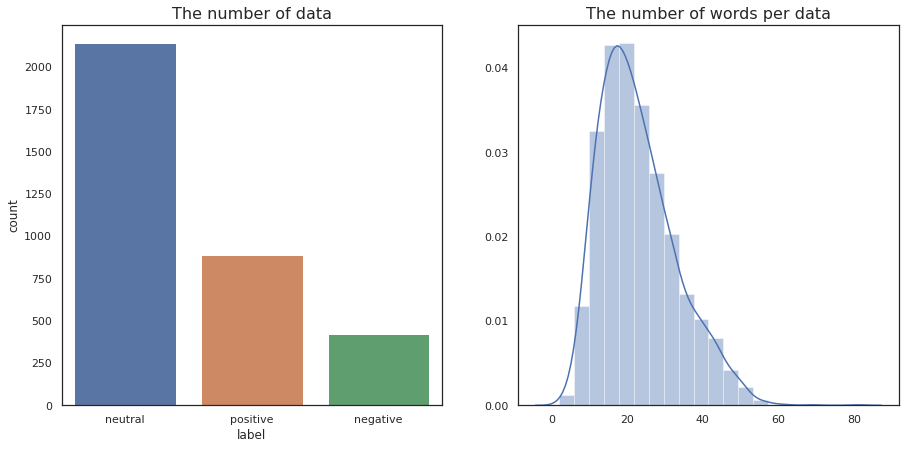

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data', fontsize=16)
sns.distplot([len(nltk.word_tokenize(words)) for words in train_df['sentence']], bins=20, ax=ax2)
ax2.set_title('The number of words per data', fontsize=16)

More than 60% of the data are labeled as "neutral". Sometimes imbalanced data are balanced using methods like resampling (oversampling, under-sampling) as models tend to predict the majority class more. SMOTE or the Synthetic Minority Over-sampling Technique is a popular technique for oversampling but it is a statistical method for numerical data.

In addition, this imbalance should be also taken into consideration if this happends in the real world. In this case, this can be interpreted as the result of the nature of news, so decided not to resample the data.

## Encode the label

In [18]:
# Encode the label
le = LabelEncoder()
le.fit(train_df['label'])
print(list(le.classes_))
train_df['label'] = le.transform(train_df['label'])
# list(le.inverse_transform(train_df['label']))
train_df['label']

['negative', 'neutral', 'positive']


0       1
1       2
2       2
3       2
4       2
       ..
3443    0
3444    0
3445    0
3446    0
3447    0
Name: label, Length: 3448, dtype: int64

The label is imbalanced and thus better to consider the measurement or balancing the data.

## Explore the text

In [19]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['sentence'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [20]:
corpus = create_corpus(train_df)

In [21]:
x, y = get_frequent_stop_words(corpus)

In [22]:
print(x)
print(y)

('the', 'of', 'in', 'and', 'to', 'a', 'for', 'is', 'from', 'will')
(4257, 2311, 2086, 1792, 1706, 1169, 842, 634, 632, 557)


In [23]:
x, y = get_frequent_nonstop_words(corpus)

In [24]:
print(x)
print(y)

('.', ',', 'eur', "'s", 'company', 'mn', 'profit', ')', 'net', '(')
(3389, 3277, 916, 698, 574, 500, 385, 381, 378, 378)


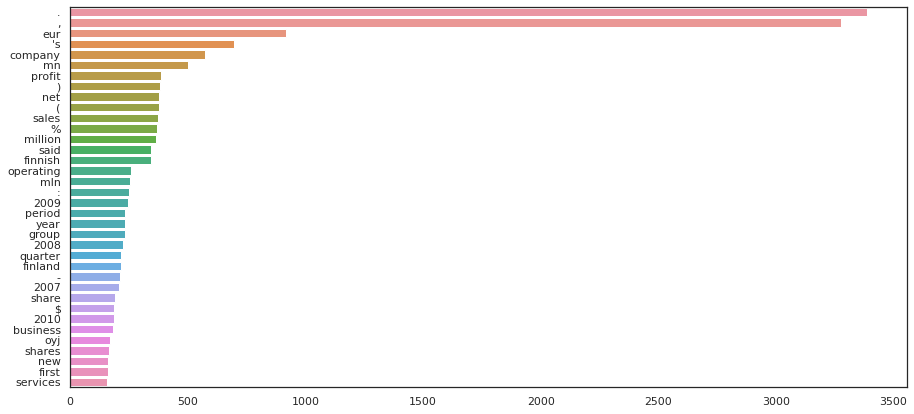

In [25]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

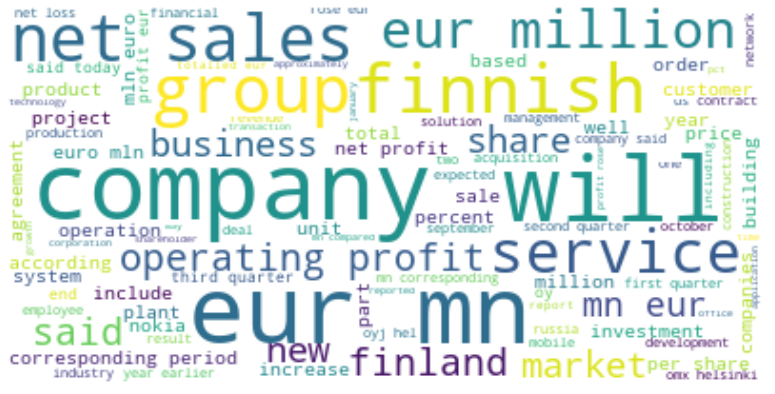

In [26]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# A. Lexicon-based Approach

## Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use [Loughran and McDonald Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires the license to use for commercial application. Please check their website.

Download the list and save it under `lmdict_dir` as csv.

In [49]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


sentiment            word
0         Negative         ABANDON
1         Negative       ABANDONED
2         Negative      ABANDONING
3         Negative     ABANDONMENT
4         Negative    ABANDONMENTS
...            ...             ...
4135  Constraining        STRICTER
4136  Constraining       STRICTEST
4137  Constraining        STRICTLY
4138  Constraining  UNAVAILABILITY
4139  Constraining     UNAVAILABLE

[4140 rows x 2 columns]

In [50]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   184
Litigious      904
Negative      2355
Positive       354
StrongModal     19
Uncertainty    297
WeakModal       27

In [51]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [52]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [53]:
# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df.head()


(3448, 2)


sentence  ...  neg_words
0  According to Gran , the company has no plans t...  ...         []
1  With the new production plant the company woul...  ...         []
2  For the last quarter of 2010 , Componenta 's n...  ...     [loss]
3  In the third quarter of 2010 , net sales incre...  ...         []
4  Operating profit rose to EUR 13.1 mn from EUR ...  ...         []

[5 rows x 8 columns]

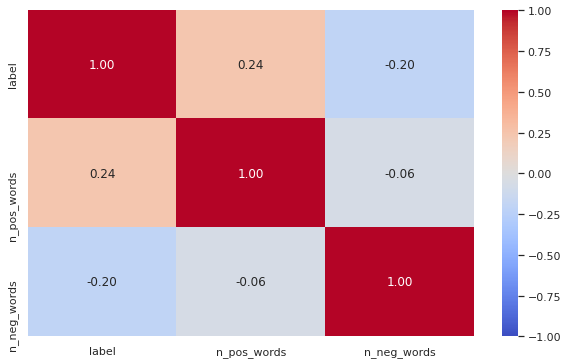

In [54]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
#corr_columns = ['label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
corr_columns = ['label', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()

## Define common functions

### Tokenizer

In [55]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    Mode:
        1: NLTK word_tokenize(), Stop words removal, Alphabet only, Lemmetize
        2: NLTK word_tokenize(), Stop words removal, Alphabet only, Do not lemmetize
        3: NLTK word_tokenize(), Do not remove stop words, Alphabet only, Do not lemmetize
        4: (alphabet + "'s" + "'t")

    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


### Lemmatize sentiment

In [56]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [57]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   145
Litigious      750
Negative      2355
Positive       354
StrongModal     15
Uncertainty    257

### Train and visualise the result

In [58]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


In [59]:
train_tone_df.columns

Index(['sentence', 'label', 'tone_score', 'word_count', 'n_pos_words',
       'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')

In [60]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

## Train the model
Use Random Forest Classifier with grid search cross validation

Fitting 7 folds for each of 480 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1402 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed:  2.3min finished
[2020-09-20 08:10:15,293][INFO] ## Training - acc: 0.67802756, f1: 0.51881612
[2020-09-20 08:10:15,293][INFO] ## Training - acc: 0.67802756, f1: 0.51881612
[2020-09-20 08:10:15,293][INFO] ## Training - acc: 0.67802756, f1: 0.51881612
[2020-09-20 08:10:15,293][INFO] ## Training - acc: 0.67802756, f1: 0.51881612
[2020-09-20 08:10:15,303][INFO] ## Test - acc: 0.65217391, f1: 0.45055161
[2020-09-20 08:10:15,303][INFO] ## Test - acc: 0.65217391, f1: 0.45055161
[2020-09-20 08:10:15,303][INFO] ## Test - acc: 0.65217391, f1: 0.45055161
[2020-09-20 08:10:15,303][INFO] ## Test - acc: 0.65217391, f1: 0.45055161


Best Score:  0.4822852214446903
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 53}


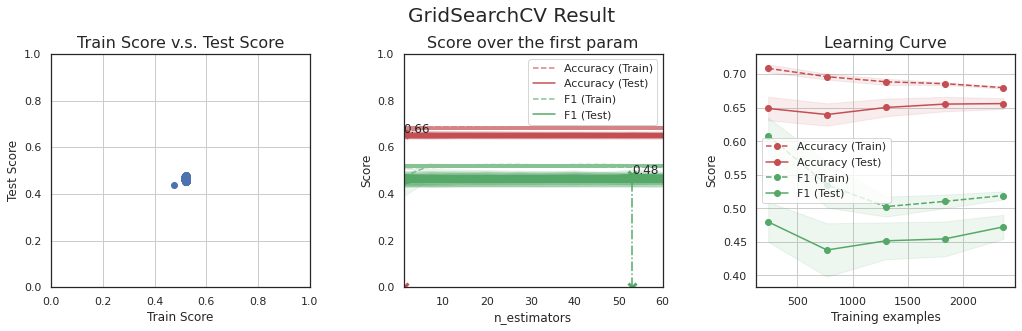

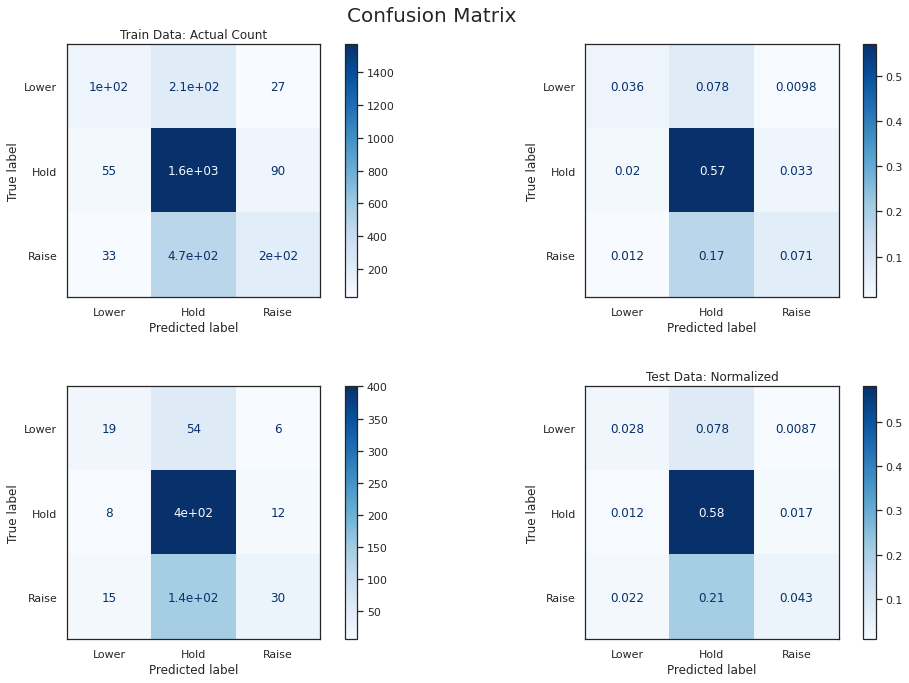

In [61]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## Result
The prediction is not good at all with Accuracy of 0.65 and F1 score of 0.46. Confusion matrix shows almost all the data have been labeled as "neutral", the majority class.

In [62]:
pred_test = rf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['A: Lexicon'] = (round(acc,4), round(f1,4))
result_df

Accuracy      F1
A: Lexicon      0.6522  0.4506
B: Tfidf           NaN     NaN
C: LSTM            NaN     NaN
D: LSTM+GloVe      NaN     NaN
E: BERT            NaN     NaN
F: ALBERT          NaN     NaN

### Feature Importance

Text(0.5, 1.0, 'Feature importance')

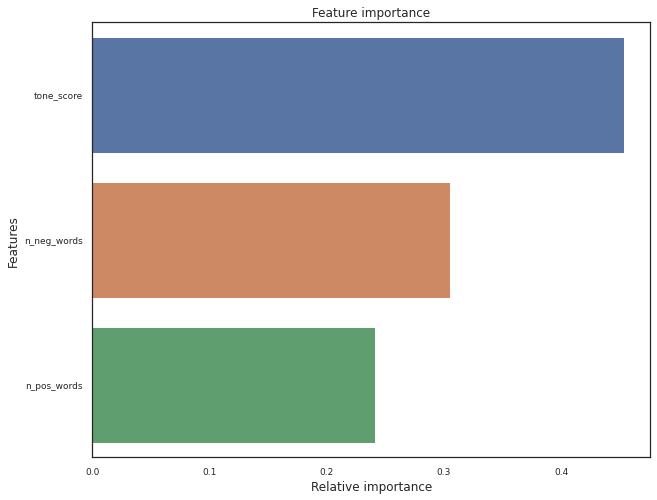

In [63]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


# B. Tfidf

## Tokenise input texts

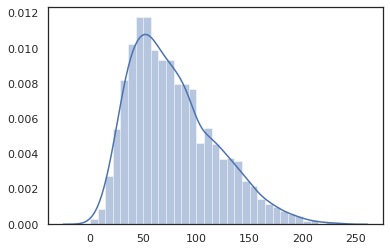

In [64]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK')
sns.distplot([len(x) for x in tokenized_text])


In [65]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = tokenized_text

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

## Model and Train (Logistic Regression)


In [66]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-09-20 08:10:25,337][INFO] ## Training - acc: 0.87853517, f1: 0.81715405
[2020-09-20 08:10:25,337][INFO] ## Training - acc: 0.87853517, f1: 0.81715405
[2020-09-20 08:10:25,337][INFO] ## Training - acc: 0.87853517, f1: 0.81715405
[2020-09-20 08:10:25,337][INFO] ## Training - acc: 0.87853517, f1: 0.81715405
[2020-09-20 08:10:25,348][INFO] ## Test - acc: 0.79710145, f1: 0.70765305
[2020-09-20 08:10:25,348][INFO] ## Test - acc: 0.79710145, f1: 0.70765305
[2020-09-20 08:10:25,348][INFO] ## Test - acc: 0.79710145, f1: 0.70765305
[2020-09-20 08:10:25,348][INFO] ## Test - acc: 0.79710145, f1: 0.70765305


## Model and Train (Random Forest)

In [67]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-09-20 08:10:27,116][INFO] ## Training - acc: 0.99746193, f1: 0.99493515
[2020-09-20 08:10:27,116][INFO] ## Training - acc: 0.99746193, f1: 0.99493515
[2020-09-20 08:10:27,116][INFO] ## Training - acc: 0.99746193, f1: 0.99493515
[2020-09-20 08:10:27,116][INFO] ## Training - acc: 0.99746193, f1: 0.99493515
[2020-09-20 08:10:27,123][INFO] ## Test - acc: 0.80579710, f1: 0.71057117
[2020-09-20 08:10:27,123][INFO] ## Test - acc: 0.80579710, f1: 0.71057117
[2020-09-20 08:10:27,123][INFO] ## Test - acc: 0.80579710, f1: 0.71057117
[2020-09-20 08:10:27,123][INFO] ## Test - acc: 0.80579710, f1: 0.71057117


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.8min finished


Best Score:  0.7085577560740185
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 100}


[2020-09-20 08:12:15,855][INFO] ## Training - acc: 0.99746193, f1: 0.99490752
[2020-09-20 08:12:15,855][INFO] ## Training - acc: 0.99746193, f1: 0.99490752
[2020-09-20 08:12:15,855][INFO] ## Training - acc: 0.99746193, f1: 0.99490752
[2020-09-20 08:12:15,855][INFO] ## Training - acc: 0.99746193, f1: 0.99490752
[2020-09-20 08:12:15,869][INFO] ## Test - acc: 0.81449275, f1: 0.71945667
[2020-09-20 08:12:15,869][INFO] ## Test - acc: 0.81449275, f1: 0.71945667
[2020-09-20 08:12:15,869][INFO] ## Test - acc: 0.81449275, f1: 0.71945667
[2020-09-20 08:12:15,869][INFO] ## Test - acc: 0.81449275, f1: 0.71945667


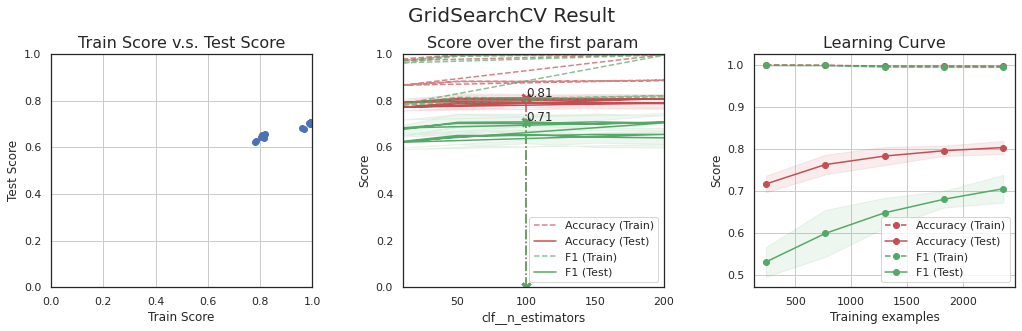

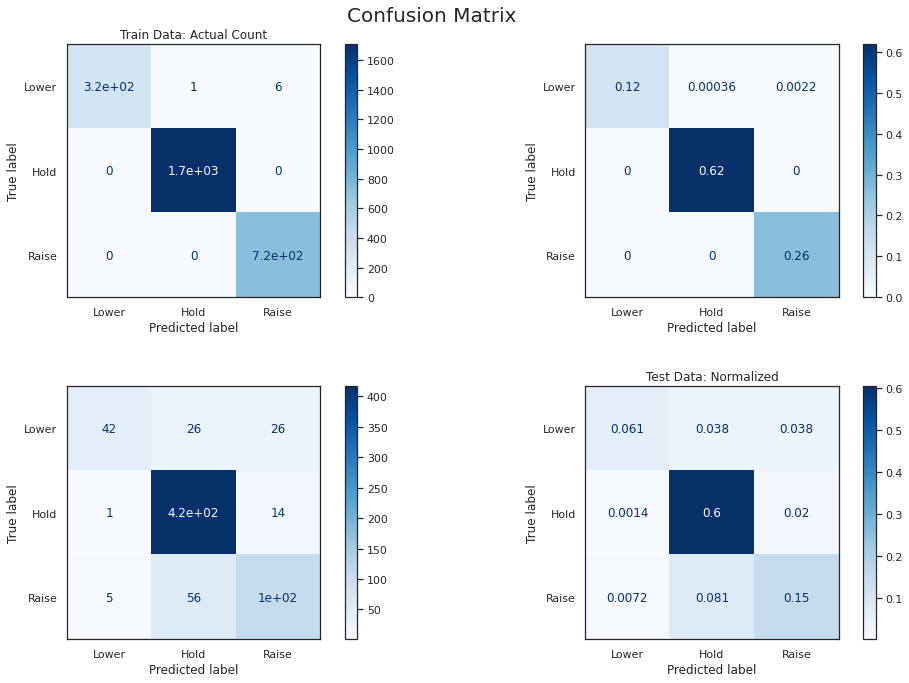

In [68]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

tfidf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
tfidf_best = tfidf_model.best_estimator_

## Result
Much better than lexicon approach but still accuracy of 0.81 and F1 score of 0.71. Apparently it overfitting to the training set.

In [69]:
pred_test = tfidf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['B: Tfidf'] = (round(acc,4), round(f1,4))
result_df

Accuracy      F1
A: Lexicon      0.6522  0.4506
B: Tfidf        0.8145  0.7195
C: LSTM            NaN     NaN
D: LSTM+GloVe      NaN     NaN
E: BERT            NaN     NaN
F: ALBERT          NaN     NaN

# C. LSTM (RNN)
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<table><tr><td><img src="./docs/lstm_4.png" width=450></td><td><img src="./docs/lstm_1.png" width=300></td></tr></table>


In [80]:
# Import Pytorch modules
# import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW

### Tokenise input texts

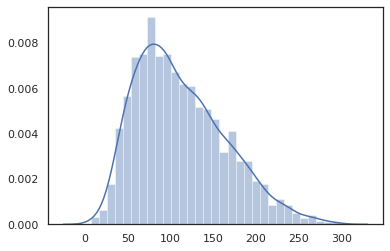

In [81]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own')
sns.distplot([len(x) for x in tokenized_text])


In [82]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_tone_df['label']
X_data = token_ids

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data, y_data.values, test_size=0.2, shuffle=True)

### Define Model
#### Embed -> RNN -> Dense -> Softmax

In [83]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        out = self.fc2(dense_out)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

Here, I used own dataloader. It's also fine to use tensorflow/keras or pytorch implementation.

In [84]:
def dataloader(messages, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [85]:
# Test the model
text_batch, labels = next(iter(dataloader(X_train, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, hidden)
print(logps)

tensor([[-0.8802, -1.1718, -1.2892],
        [-0.9131, -1.1370, -1.2803],
        [-0.9051, -1.1820, -1.2418],
        [-0.8400, -1.1908, -1.3305],
        [-1.0387, -1.1555, -1.1051],
        [-0.9908, -1.1132, -1.2032],
        [-0.9001, -1.1732, -1.2584],
        [-0.9164, -1.1643, -1.2452],
        [-0.8696, -1.2127, -1.2606],
        [-0.9472, -1.1354, -1.2347],
        [-1.0028, -1.1361, -1.1645],
        [-1.0132, -1.1596, -1.1291],
        [-0.9227, -1.1457, -1.2568],
        [-1.0065, -1.1621, -1.1343],
        [-0.9983, -1.1576, -1.1480],
        [-0.9962, -1.1366, -1.1717]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Configure the model and train!

In [86]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(7136, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [91]:
def train_model(model, epochs=30, batch_size=32, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    best_f1, best_acc, best_epoch = 0, 0, 0

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, labels in dataloader(
                        X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    # Skip the last batch of which size is not equal to batch_size
                    if text_batch.size(1) != batch_size:
                        break

                    # Initialize within the loop to use label shape because batch_size did not work
                    # valid_hidden = model.init_hidden(labels.shape[0])

                    # Creating new variables for the hidden state
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    # Set Device
                    text_batch, labels = text_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    # Get output and hidden state from the model
                    valid_output, valid_hidden = model(text_batch, valid_hidden)

                    # Calculate the loss     
                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    # Accuracy
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Negative', 'Neutral', 'Positive']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

        if f1 > best_f1:
            best_f1 = f1
            best_acc = acc
            best_epoch = epoch + 1
    print("########## END ##########")
    print("Best Epoch: %d, Best F1: %.8f" % (best_epoch, best_f1))

    return best_acc, best_f1, best_epoch

Starting epoch 1
Epoch: 1/30 Step: 10... Loss: 0.000642 Val Loss: 1.064100 Accuracy: 0.827381 F1 Score: 0.761503
Epoch: 1/30 Step: 20... Loss: 0.034278 Val Loss: 1.094400 Accuracy: 0.809524 F1 Score: 0.750881
Epoch: 1/30 Step: 30... Loss: 0.004096 Val Loss: 1.301676 Accuracy: 0.764881 F1 Score: 0.719904
Epoch: 1/30 Step: 40... Loss: 0.008022 Val Loss: 1.194409 Accuracy: 0.800595 F1 Score: 0.752620
Epoch: 1/30 Step: 50... Loss: 0.004326 Val Loss: 1.174348 Accuracy: 0.799107 F1 Score: 0.749820
Epoch: 1/30 Step: 60... Loss: 0.000733 Val Loss: 1.186064 Accuracy: 0.800595 F1 Score: 0.752148
Epoch: 1/30 Step: 70... Loss: 0.002686 Val Loss: 1.175768 Accuracy: 0.802083 F1 Score: 0.752364
Epoch: 1/30 Step: 80... Loss: 0.005682 Val Loss: 1.190236 Accuracy: 0.797619 F1 Score: 0.742821
87 steps in epoch 1

Epoch: 1, Average Accuracy: 0.79761905, Average f1: 0.74282057



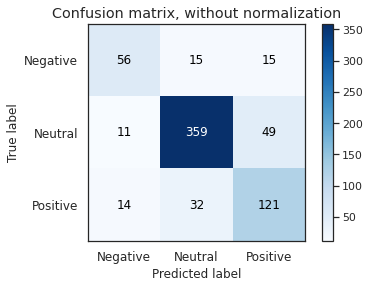

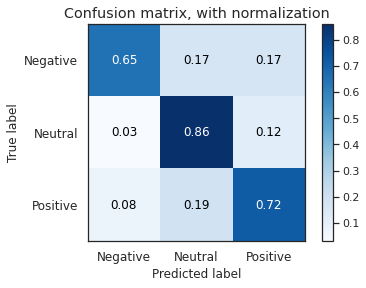

Starting epoch 2
Epoch: 2/30 Step: 10... Loss: 0.000918 Val Loss: 1.076637 Accuracy: 0.827381 F1 Score: 0.767450
Epoch: 2/30 Step: 20... Loss: 0.001592 Val Loss: 1.062808 Accuracy: 0.811012 F1 Score: 0.748673
Epoch: 2/30 Step: 30... Loss: 0.013427 Val Loss: 1.099205 Accuracy: 0.811012 F1 Score: 0.754759
Epoch: 2/30 Step: 40... Loss: 0.003681 Val Loss: 1.202306 Accuracy: 0.799107 F1 Score: 0.750273
Epoch: 2/30 Step: 50... Loss: 0.006756 Val Loss: 1.103173 Accuracy: 0.813988 F1 Score: 0.750613
Epoch: 2/30 Step: 60... Loss: 0.000706 Val Loss: 1.168717 Accuracy: 0.806548 F1 Score: 0.754467
Epoch: 2/30 Step: 70... Loss: 0.005080 Val Loss: 1.337431 Accuracy: 0.772321 F1 Score: 0.731004
Epoch: 2/30 Step: 80... Loss: 0.001375 Val Loss: 1.079359 Accuracy: 0.822917 F1 Score: 0.765039
87 steps in epoch 2

Epoch: 2, Average Accuracy: 0.82291667, Average f1: 0.76503852



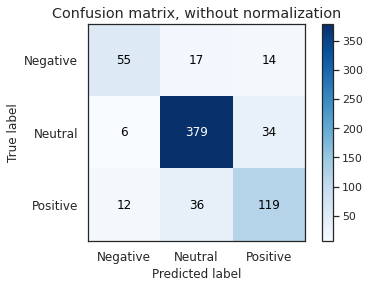

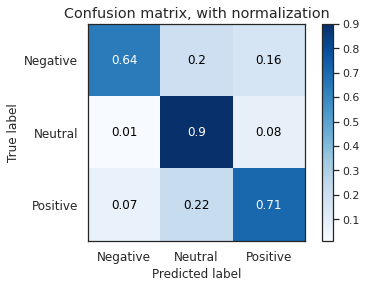

Starting epoch 3
Epoch: 3/30 Step: 10... Loss: 0.000468 Val Loss: 1.077586 Accuracy: 0.833333 F1 Score: 0.774858
Epoch: 3/30 Step: 20... Loss: 0.001161 Val Loss: 1.062527 Accuracy: 0.819940 F1 Score: 0.760310
Epoch: 3/30 Step: 30... Loss: 0.004367 Val Loss: 1.118523 Accuracy: 0.802083 F1 Score: 0.752066
Epoch: 3/30 Step: 40... Loss: 0.003274 Val Loss: 1.161793 Accuracy: 0.803571 F1 Score: 0.747282
Epoch: 3/30 Step: 50... Loss: 0.002704 Val Loss: 1.264948 Accuracy: 0.799107 F1 Score: 0.750608
Epoch: 3/30 Step: 60... Loss: 0.000663 Val Loss: 1.102974 Accuracy: 0.811012 F1 Score: 0.754788
Epoch: 3/30 Step: 70... Loss: 0.002356 Val Loss: 1.057878 Accuracy: 0.821429 F1 Score: 0.753794
Epoch: 3/30 Step: 80... Loss: 0.001116 Val Loss: 1.094066 Accuracy: 0.818452 F1 Score: 0.760514
87 steps in epoch 3

Epoch: 3, Average Accuracy: 0.81845238, Average f1: 0.76051427



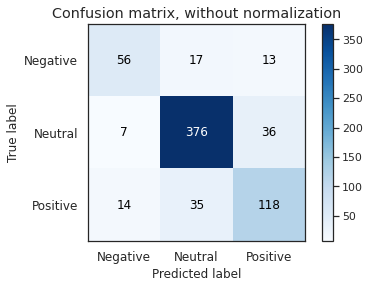

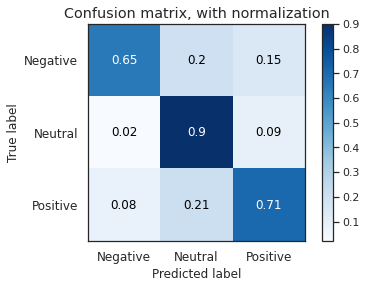

Starting epoch 4
Epoch: 4/30 Step: 10... Loss: 0.001570 Val Loss: 1.175948 Accuracy: 0.813988 F1 Score: 0.759586
Epoch: 4/30 Step: 20... Loss: 0.001168 Val Loss: 1.131955 Accuracy: 0.824405 F1 Score: 0.770018
Epoch: 4/30 Step: 30... Loss: 0.005499 Val Loss: 1.125915 Accuracy: 0.822917 F1 Score: 0.770596
Epoch: 4/30 Step: 40... Loss: 0.002125 Val Loss: 1.148703 Accuracy: 0.815476 F1 Score: 0.759954
Epoch: 4/30 Step: 50... Loss: 0.003634 Val Loss: 1.227467 Accuracy: 0.802083 F1 Score: 0.751274
Epoch: 4/30 Step: 60... Loss: 0.000852 Val Loss: 1.265218 Accuracy: 0.799107 F1 Score: 0.749608
Epoch: 4/30 Step: 70... Loss: 0.001442 Val Loss: 1.174757 Accuracy: 0.803571 F1 Score: 0.748499
Epoch: 4/30 Step: 80... Loss: 0.000803 Val Loss: 1.141649 Accuracy: 0.812500 F1 Score: 0.754831
87 steps in epoch 4

Epoch: 4, Average Accuracy: 0.81250000, Average f1: 0.75483071



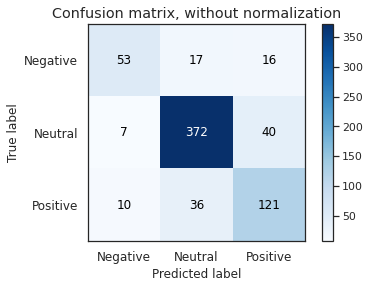

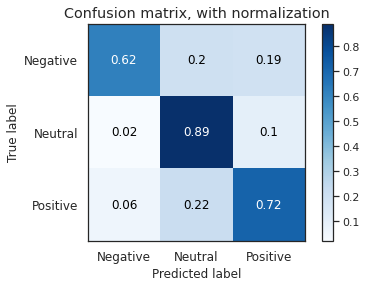

Starting epoch 5
Epoch: 5/30 Step: 10... Loss: 0.020144 Val Loss: 1.200090 Accuracy: 0.822917 F1 Score: 0.763314
Epoch: 5/30 Step: 20... Loss: 0.001401 Val Loss: 1.106017 Accuracy: 0.818452 F1 Score: 0.762811
Epoch: 5/30 Step: 30... Loss: 0.019740 Val Loss: 1.085016 Accuracy: 0.815476 F1 Score: 0.759360
Epoch: 5/30 Step: 40... Loss: 0.002289 Val Loss: 1.106576 Accuracy: 0.824405 F1 Score: 0.769634
Epoch: 5/30 Step: 50... Loss: 0.003086 Val Loss: 1.168441 Accuracy: 0.818452 F1 Score: 0.766234
Epoch: 5/30 Step: 60... Loss: 0.000610 Val Loss: 1.186961 Accuracy: 0.809524 F1 Score: 0.755992
Epoch: 5/30 Step: 70... Loss: 0.001546 Val Loss: 1.231910 Accuracy: 0.794643 F1 Score: 0.748124
Epoch: 5/30 Step: 80... Loss: 0.001665 Val Loss: 1.211197 Accuracy: 0.797619 F1 Score: 0.743995
87 steps in epoch 5

Epoch: 5, Average Accuracy: 0.79761905, Average f1: 0.74399525



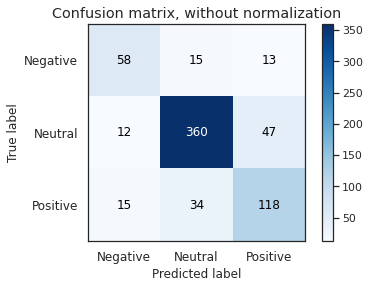

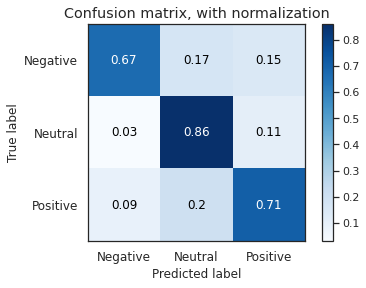

Starting epoch 6
Epoch: 6/30 Step: 10... Loss: 0.000310 Val Loss: 1.228256 Accuracy: 0.827381 F1 Score: 0.768658
Epoch: 6/30 Step: 20... Loss: 0.001830 Val Loss: 1.233451 Accuracy: 0.827381 F1 Score: 0.769030
Epoch: 6/30 Step: 30... Loss: 0.002478 Val Loss: 1.278697 Accuracy: 0.805060 F1 Score: 0.755568
Epoch: 6/30 Step: 40... Loss: 0.002030 Val Loss: 1.336111 Accuracy: 0.799107 F1 Score: 0.750964
Epoch: 6/30 Step: 50... Loss: 0.002235 Val Loss: 1.166224 Accuracy: 0.812500 F1 Score: 0.761010
Epoch: 6/30 Step: 60... Loss: 0.000403 Val Loss: 1.135956 Accuracy: 0.822917 F1 Score: 0.764760
Epoch: 6/30 Step: 70... Loss: 0.002469 Val Loss: 1.141093 Accuracy: 0.819940 F1 Score: 0.762141
Epoch: 6/30 Step: 80... Loss: 0.000737 Val Loss: 1.163330 Accuracy: 0.800595 F1 Score: 0.747357
87 steps in epoch 6

Epoch: 6, Average Accuracy: 0.80059524, Average f1: 0.74735721



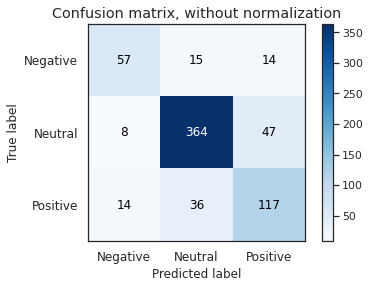

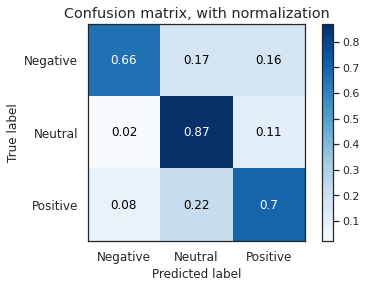

Starting epoch 7
Epoch: 7/30 Step: 10... Loss: 0.001087 Val Loss: 1.237456 Accuracy: 0.800595 F1 Score: 0.747060
Epoch: 7/30 Step: 20... Loss: 0.000591 Val Loss: 1.193586 Accuracy: 0.821429 F1 Score: 0.761925
Epoch: 7/30 Step: 30... Loss: 0.052840 Val Loss: 1.194219 Accuracy: 0.815476 F1 Score: 0.759269
Epoch: 7/30 Step: 40... Loss: 0.002154 Val Loss: 1.202775 Accuracy: 0.808036 F1 Score: 0.754941
Epoch: 7/30 Step: 50... Loss: 0.001814 Val Loss: 1.232370 Accuracy: 0.803571 F1 Score: 0.749454
Epoch: 7/30 Step: 60... Loss: 0.000351 Val Loss: 1.188021 Accuracy: 0.819940 F1 Score: 0.762894
Epoch: 7/30 Step: 70... Loss: 0.001824 Val Loss: 1.180824 Accuracy: 0.819940 F1 Score: 0.759297
Epoch: 7/30 Step: 80... Loss: 0.011658 Val Loss: 1.187430 Accuracy: 0.822917 F1 Score: 0.765531
87 steps in epoch 7

Epoch: 7, Average Accuracy: 0.82291667, Average f1: 0.76553080



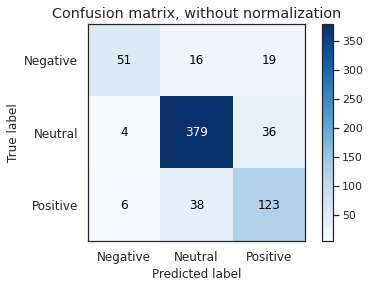

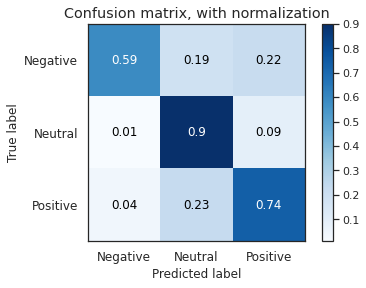

Starting epoch 8
Epoch: 8/30 Step: 10... Loss: 0.002351 Val Loss: 1.262664 Accuracy: 0.788690 F1 Score: 0.739702
Epoch: 8/30 Step: 20... Loss: 0.000946 Val Loss: 1.237122 Accuracy: 0.797619 F1 Score: 0.747416
Epoch: 8/30 Step: 30... Loss: 0.002220 Val Loss: 1.233040 Accuracy: 0.809524 F1 Score: 0.755099
Epoch: 8/30 Step: 40... Loss: 0.001390 Val Loss: 1.238091 Accuracy: 0.812500 F1 Score: 0.756863
Epoch: 8/30 Step: 50... Loss: 0.002097 Val Loss: 1.230121 Accuracy: 0.811012 F1 Score: 0.754198
Epoch: 8/30 Step: 60... Loss: 0.000327 Val Loss: 1.233866 Accuracy: 0.812500 F1 Score: 0.755781
Epoch: 8/30 Step: 70... Loss: 0.002015 Val Loss: 1.235113 Accuracy: 0.812500 F1 Score: 0.755781
Epoch: 8/30 Step: 80... Loss: 0.000501 Val Loss: 1.235603 Accuracy: 0.812500 F1 Score: 0.756549
87 steps in epoch 8

Epoch: 8, Average Accuracy: 0.81250000, Average f1: 0.75654910



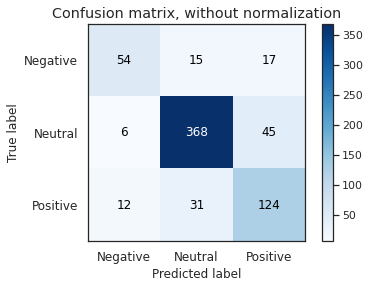

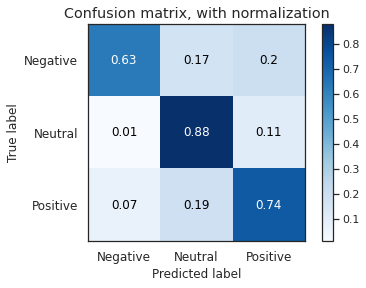

Starting epoch 9
Epoch: 9/30 Step: 10... Loss: 0.000379 Val Loss: 1.233269 Accuracy: 0.815476 F1 Score: 0.761868
Epoch: 9/30 Step: 20... Loss: 0.000743 Val Loss: 1.239561 Accuracy: 0.815476 F1 Score: 0.761868
Epoch: 9/30 Step: 30... Loss: 0.001646 Val Loss: 1.242854 Accuracy: 0.815476 F1 Score: 0.761101
Epoch: 9/30 Step: 40... Loss: 0.001526 Val Loss: 1.246585 Accuracy: 0.815476 F1 Score: 0.761101
Epoch: 9/30 Step: 50... Loss: 0.001565 Val Loss: 1.249553 Accuracy: 0.818452 F1 Score: 0.767863
Epoch: 9/30 Step: 60... Loss: 0.000265 Val Loss: 1.254827 Accuracy: 0.815476 F1 Score: 0.764846
Epoch: 9/30 Step: 70... Loss: 0.001543 Val Loss: 1.258372 Accuracy: 0.815476 F1 Score: 0.764846
Epoch: 9/30 Step: 80... Loss: 0.000522 Val Loss: 1.262082 Accuracy: 0.816964 F1 Score: 0.764497
87 steps in epoch 9

Epoch: 9, Average Accuracy: 0.81696429, Average f1: 0.76449710



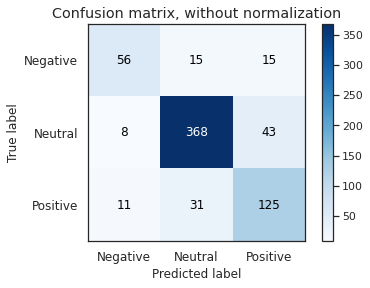

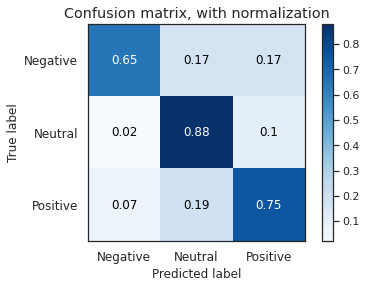

Starting epoch 10
Epoch: 10/30 Step: 10... Loss: 0.000396 Val Loss: 1.266716 Accuracy: 0.815476 F1 Score: 0.762657
Epoch: 10/30 Step: 20... Loss: 0.000368 Val Loss: 1.272125 Accuracy: 0.813988 F1 Score: 0.760029
Epoch: 10/30 Step: 30... Loss: 0.001750 Val Loss: 1.275144 Accuracy: 0.812500 F1 Score: 0.756557
Epoch: 10/30 Step: 40... Loss: 0.000851 Val Loss: 1.275591 Accuracy: 0.813988 F1 Score: 0.760029
Epoch: 10/30 Step: 50... Loss: 0.001000 Val Loss: 1.276363 Accuracy: 0.815476 F1 Score: 0.762657
Epoch: 10/30 Step: 60... Loss: 0.000174 Val Loss: 1.279300 Accuracy: 0.816964 F1 Score: 0.765268
Epoch: 10/30 Step: 70... Loss: 0.000815 Val Loss: 1.283257 Accuracy: 0.816964 F1 Score: 0.764546
Epoch: 10/30 Step: 80... Loss: 0.000529 Val Loss: 1.287796 Accuracy: 0.815476 F1 Score: 0.761907
87 steps in epoch 10

Epoch: 10, Average Accuracy: 0.81547619, Average f1: 0.76190676



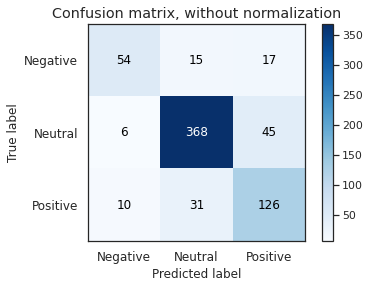

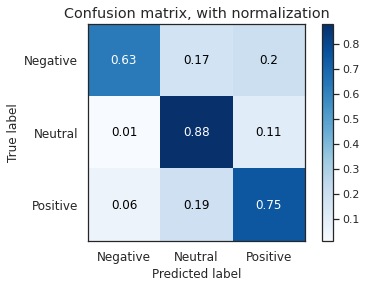

Starting epoch 11
Epoch: 11/30 Step: 10... Loss: 0.000170 Val Loss: 1.287788 Accuracy: 0.816964 F1 Score: 0.765352
Epoch: 11/30 Step: 20... Loss: 0.000434 Val Loss: 1.287147 Accuracy: 0.812500 F1 Score: 0.758764
Epoch: 11/30 Step: 30... Loss: 0.001351 Val Loss: 1.288897 Accuracy: 0.812500 F1 Score: 0.758764
Epoch: 11/30 Step: 40... Loss: 0.000623 Val Loss: 1.290761 Accuracy: 0.811012 F1 Score: 0.756127
Epoch: 11/30 Step: 50... Loss: 0.000849 Val Loss: 1.292622 Accuracy: 0.811012 F1 Score: 0.756127
Epoch: 11/30 Step: 60... Loss: 0.000129 Val Loss: 1.290723 Accuracy: 0.813988 F1 Score: 0.759888
Epoch: 11/30 Step: 70... Loss: 0.000781 Val Loss: 1.292147 Accuracy: 0.819940 F1 Score: 0.769178
Epoch: 11/30 Step: 80... Loss: 0.000258 Val Loss: 1.294414 Accuracy: 0.818452 F1 Score: 0.765720
87 steps in epoch 11

Epoch: 11, Average Accuracy: 0.81845238, Average f1: 0.76571975



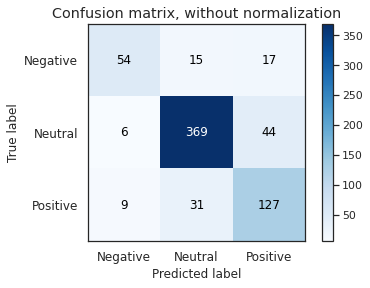

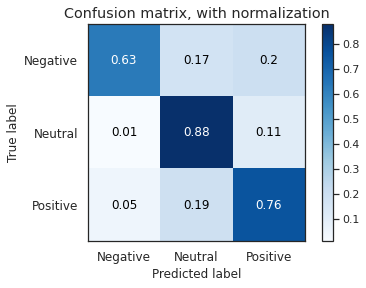

Starting epoch 12
Epoch: 12/30 Step: 10... Loss: 0.000148 Val Loss: 1.305575 Accuracy: 0.816964 F1 Score: 0.762229
Epoch: 12/30 Step: 20... Loss: 0.000190 Val Loss: 1.321488 Accuracy: 0.816964 F1 Score: 0.762229
Epoch: 12/30 Step: 30... Loss: 0.000585 Val Loss: 1.324854 Accuracy: 0.815476 F1 Score: 0.761117
Epoch: 12/30 Step: 40... Loss: 0.000699 Val Loss: 1.325819 Accuracy: 0.813988 F1 Score: 0.760007
Epoch: 12/30 Step: 50... Loss: 0.000714 Val Loss: 1.326875 Accuracy: 0.813988 F1 Score: 0.759990
Epoch: 12/30 Step: 60... Loss: 0.000139 Val Loss: 1.329547 Accuracy: 0.813988 F1 Score: 0.759990
Epoch: 12/30 Step: 70... Loss: 0.000507 Val Loss: 1.332102 Accuracy: 0.813988 F1 Score: 0.759990
Epoch: 12/30 Step: 80... Loss: 0.000232 Val Loss: 1.333968 Accuracy: 0.815476 F1 Score: 0.761105
87 steps in epoch 12

Epoch: 12, Average Accuracy: 0.81547619, Average f1: 0.76110531



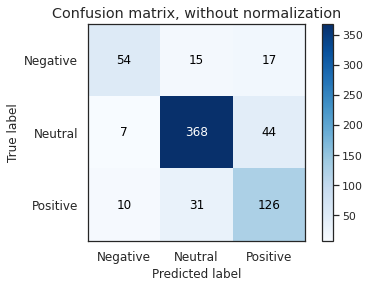

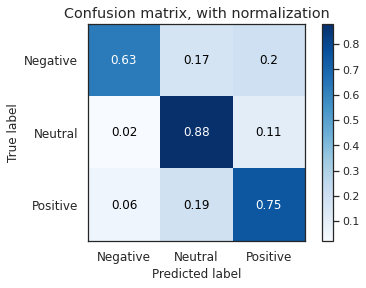

Starting epoch 13
Epoch: 13/30 Step: 10... Loss: 0.000104 Val Loss: 1.341687 Accuracy: 0.813988 F1 Score: 0.760007
Epoch: 13/30 Step: 20... Loss: 0.000355 Val Loss: 1.345476 Accuracy: 0.813988 F1 Score: 0.760007
Epoch: 13/30 Step: 30... Loss: 0.000725 Val Loss: 1.346884 Accuracy: 0.813988 F1 Score: 0.760007
Epoch: 13/30 Step: 40... Loss: 0.000745 Val Loss: 1.346178 Accuracy: 0.813988 F1 Score: 0.760007
Epoch: 13/30 Step: 50... Loss: 0.000796 Val Loss: 1.346491 Accuracy: 0.815476 F1 Score: 0.763490
Epoch: 13/30 Step: 60... Loss: 0.000134 Val Loss: 1.348435 Accuracy: 0.815476 F1 Score: 0.762667
Epoch: 13/30 Step: 70... Loss: 0.000659 Val Loss: 1.349703 Accuracy: 0.815476 F1 Score: 0.762667
Epoch: 13/30 Step: 80... Loss: 0.000178 Val Loss: 1.350330 Accuracy: 0.815476 F1 Score: 0.762667
87 steps in epoch 13

Epoch: 13, Average Accuracy: 0.81547619, Average f1: 0.76266746



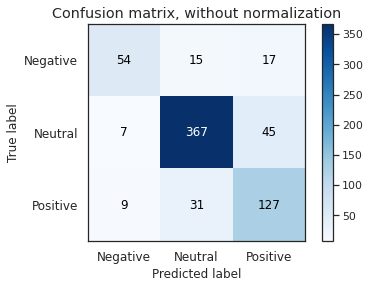

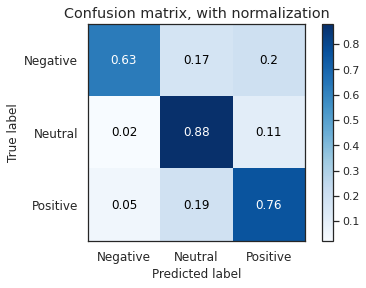

Starting epoch 14
Epoch: 14/30 Step: 10... Loss: 0.000186 Val Loss: 1.351947 Accuracy: 0.813988 F1 Score: 0.761931
Epoch: 14/30 Step: 20... Loss: 0.000259 Val Loss: 1.353741 Accuracy: 0.813988 F1 Score: 0.761931
Epoch: 14/30 Step: 30... Loss: 0.000460 Val Loss: 1.354651 Accuracy: 0.813988 F1 Score: 0.761106
Epoch: 14/30 Step: 40... Loss: 0.000459 Val Loss: 1.355682 Accuracy: 0.813988 F1 Score: 0.761857
Epoch: 14/30 Step: 50... Loss: 0.000500 Val Loss: 1.357662 Accuracy: 0.812500 F1 Score: 0.759174
Epoch: 14/30 Step: 60... Loss: 0.000122 Val Loss: 1.361781 Accuracy: 0.813988 F1 Score: 0.761857
Epoch: 14/30 Step: 70... Loss: 0.000486 Val Loss: 1.364873 Accuracy: 0.813988 F1 Score: 0.761106
Epoch: 14/30 Step: 80... Loss: 0.000165 Val Loss: 1.367174 Accuracy: 0.813988 F1 Score: 0.761106
87 steps in epoch 14

Epoch: 14, Average Accuracy: 0.81398810, Average f1: 0.76110644



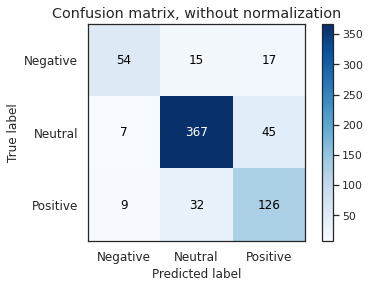

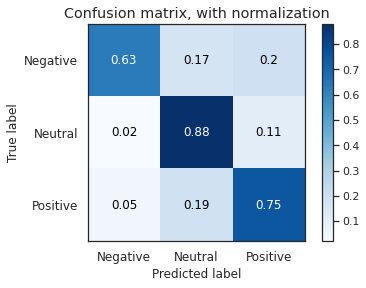

Starting epoch 15
Epoch: 15/30 Step: 10... Loss: 0.000087 Val Loss: 1.371611 Accuracy: 0.812500 F1 Score: 0.757630
Epoch: 15/30 Step: 20... Loss: 0.000167 Val Loss: 1.373787 Accuracy: 0.812500 F1 Score: 0.758449
Epoch: 15/30 Step: 30... Loss: 0.000505 Val Loss: 1.373516 Accuracy: 0.812500 F1 Score: 0.758449
Epoch: 15/30 Step: 40... Loss: 0.000421 Val Loss: 1.371919 Accuracy: 0.813988 F1 Score: 0.761931
Epoch: 15/30 Step: 50... Loss: 0.000876 Val Loss: 1.372175 Accuracy: 0.813988 F1 Score: 0.761106
Epoch: 15/30 Step: 60... Loss: 0.000100 Val Loss: 1.374466 Accuracy: 0.812500 F1 Score: 0.758422
Epoch: 15/30 Step: 70... Loss: 0.000382 Val Loss: 1.375658 Accuracy: 0.811012 F1 Score: 0.755749
Epoch: 15/30 Step: 80... Loss: 0.000167 Val Loss: 1.377836 Accuracy: 0.812500 F1 Score: 0.758422
87 steps in epoch 15

Epoch: 15, Average Accuracy: 0.81250000, Average f1: 0.75842175



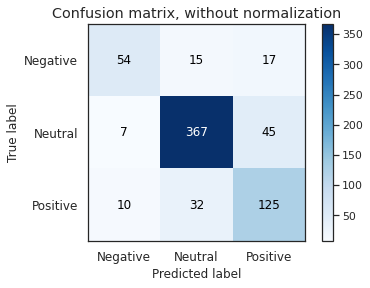

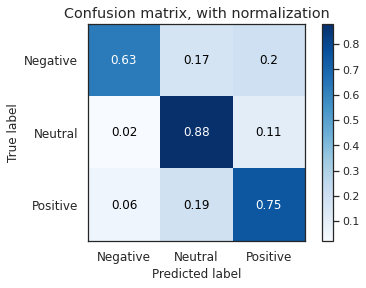

Starting epoch 16
Epoch: 16/30 Step: 10... Loss: 0.000099 Val Loss: 1.382160 Accuracy: 0.813988 F1 Score: 0.761931
Epoch: 16/30 Step: 20... Loss: 0.000274 Val Loss: 1.386214 Accuracy: 0.813988 F1 Score: 0.761931
Epoch: 16/30 Step: 30... Loss: 0.000558 Val Loss: 1.387001 Accuracy: 0.813988 F1 Score: 0.761931
Epoch: 16/30 Step: 40... Loss: 0.000260 Val Loss: 1.387612 Accuracy: 0.812500 F1 Score: 0.758422
Epoch: 16/30 Step: 50... Loss: 0.000465 Val Loss: 1.389023 Accuracy: 0.812500 F1 Score: 0.758422
Epoch: 16/30 Step: 60... Loss: 0.000091 Val Loss: 1.391718 Accuracy: 0.812500 F1 Score: 0.758422
Epoch: 16/30 Step: 70... Loss: 0.000500 Val Loss: 1.393755 Accuracy: 0.812500 F1 Score: 0.758422
Epoch: 16/30 Step: 80... Loss: 0.000117 Val Loss: 1.396166 Accuracy: 0.812500 F1 Score: 0.758422
87 steps in epoch 16

Epoch: 16, Average Accuracy: 0.81250000, Average f1: 0.75842175



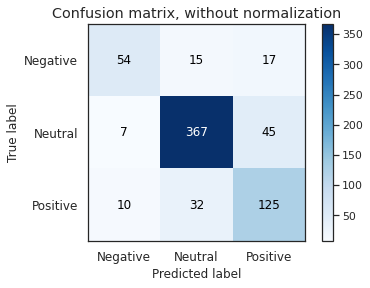

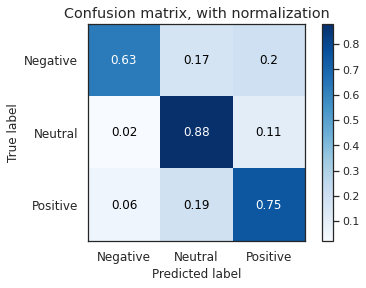

Starting epoch 17
Epoch: 17/30 Step: 10... Loss: 0.000051 Val Loss: 1.399527 Accuracy: 0.812500 F1 Score: 0.758422
Epoch: 17/30 Step: 20... Loss: 0.000171 Val Loss: 1.402554 Accuracy: 0.812500 F1 Score: 0.759229
Epoch: 17/30 Step: 30... Loss: 0.000360 Val Loss: 1.402866 Accuracy: 0.812500 F1 Score: 0.759229
Epoch: 17/30 Step: 40... Loss: 0.000257 Val Loss: 1.403511 Accuracy: 0.813988 F1 Score: 0.761857
Epoch: 17/30 Step: 50... Loss: 0.000678 Val Loss: 1.404655 Accuracy: 0.813988 F1 Score: 0.761857
Epoch: 17/30 Step: 60... Loss: 0.000099 Val Loss: 1.407429 Accuracy: 0.813988 F1 Score: 0.761857
Epoch: 17/30 Step: 70... Loss: 0.000286 Val Loss: 1.411442 Accuracy: 0.812500 F1 Score: 0.759229
Epoch: 17/30 Step: 80... Loss: 0.000204 Val Loss: 1.414815 Accuracy: 0.812500 F1 Score: 0.758449
87 steps in epoch 17

Epoch: 17, Average Accuracy: 0.81250000, Average f1: 0.75844883



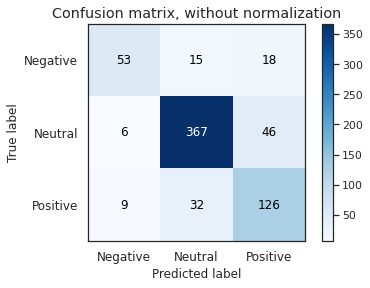

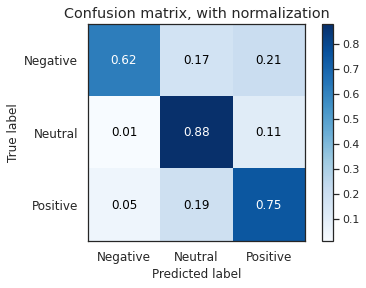

Starting epoch 18
Epoch: 18/30 Step: 10... Loss: 0.000110 Val Loss: 1.420872 Accuracy: 0.812500 F1 Score: 0.758449
Epoch: 18/30 Step: 20... Loss: 0.000146 Val Loss: 1.423520 Accuracy: 0.812500 F1 Score: 0.758449
Epoch: 18/30 Step: 30... Loss: 0.000559 Val Loss: 1.423395 Accuracy: 0.812500 F1 Score: 0.757630
Epoch: 18/30 Step: 40... Loss: 0.000220 Val Loss: 1.422308 Accuracy: 0.813988 F1 Score: 0.761857
Epoch: 18/30 Step: 50... Loss: 0.000299 Val Loss: 1.422694 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 18/30 Step: 60... Loss: 0.000092 Val Loss: 1.422551 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 18/30 Step: 70... Loss: 0.000290 Val Loss: 1.422708 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 18/30 Step: 80... Loss: 0.000091 Val Loss: 1.423440 Accuracy: 0.813988 F1 Score: 0.761068
87 steps in epoch 18

Epoch: 18, Average Accuracy: 0.81398810, Average f1: 0.76106788



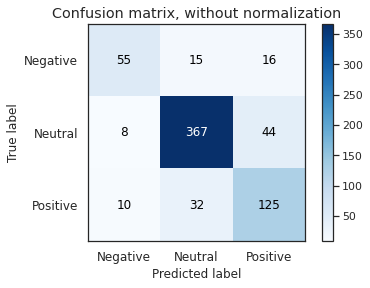

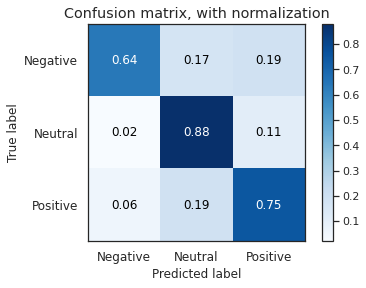

Starting epoch 19
Epoch: 19/30 Step: 10... Loss: 0.000099 Val Loss: 1.425940 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 19/30 Step: 20... Loss: 0.000136 Val Loss: 1.427577 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 19/30 Step: 30... Loss: 0.000277 Val Loss: 1.425469 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 19/30 Step: 40... Loss: 0.000173 Val Loss: 1.424778 Accuracy: 0.812500 F1 Score: 0.758402
Epoch: 19/30 Step: 50... Loss: 0.000376 Val Loss: 1.425449 Accuracy: 0.812500 F1 Score: 0.758402
Epoch: 19/30 Step: 60... Loss: 0.000098 Val Loss: 1.428289 Accuracy: 0.812500 F1 Score: 0.758402
Epoch: 19/30 Step: 70... Loss: 0.000222 Val Loss: 1.431151 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 19/30 Step: 80... Loss: 0.000146 Val Loss: 1.432947 Accuracy: 0.813988 F1 Score: 0.761068
87 steps in epoch 19

Epoch: 19, Average Accuracy: 0.81398810, Average f1: 0.76106788



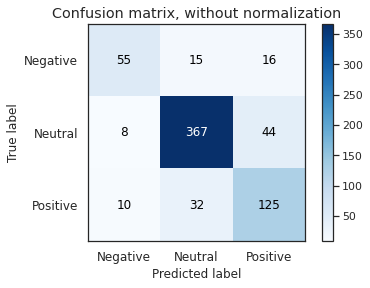

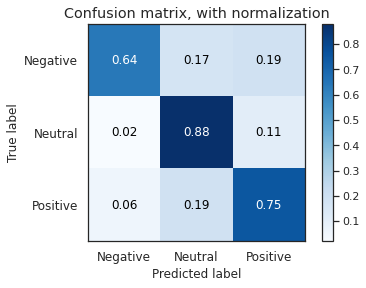

Starting epoch 20
Epoch: 20/30 Step: 10... Loss: 0.000045 Val Loss: 1.435421 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 20/30 Step: 20... Loss: 0.000115 Val Loss: 1.434682 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 20/30 Step: 30... Loss: 0.000243 Val Loss: 1.434502 Accuracy: 0.813988 F1 Score: 0.761068
Epoch: 20/30 Step: 40... Loss: 0.000187 Val Loss: 1.435864 Accuracy: 0.812500 F1 Score: 0.758402
Epoch: 20/30 Step: 50... Loss: 0.000481 Val Loss: 1.437281 Accuracy: 0.812500 F1 Score: 0.758402
Epoch: 20/30 Step: 60... Loss: 0.000071 Val Loss: 1.440139 Accuracy: 0.812500 F1 Score: 0.758402
Epoch: 20/30 Step: 70... Loss: 0.000256 Val Loss: 1.465569 Accuracy: 0.813988 F1 Score: 0.759557
Epoch: 20/30 Step: 80... Loss: 0.000067 Val Loss: 1.477175 Accuracy: 0.812500 F1 Score: 0.754718
87 steps in epoch 20

Epoch: 20, Average Accuracy: 0.81250000, Average f1: 0.75471805



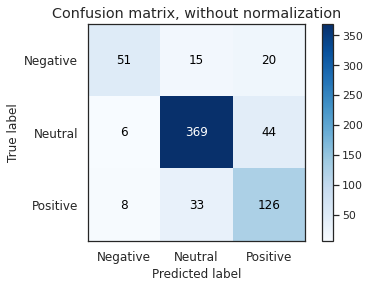

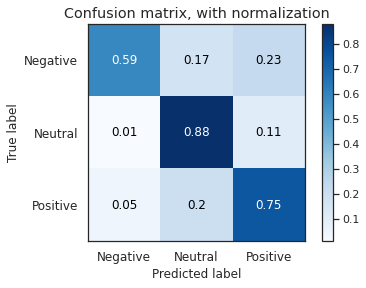

Starting epoch 21
Epoch: 21/30 Step: 10... Loss: 0.000073 Val Loss: 1.452713 Accuracy: 0.816964 F1 Score: 0.762555
Epoch: 21/30 Step: 20... Loss: 0.000131 Val Loss: 1.452839 Accuracy: 0.815476 F1 Score: 0.759983
Epoch: 21/30 Step: 30... Loss: 0.000229 Val Loss: 1.445969 Accuracy: 0.816964 F1 Score: 0.762600
Epoch: 21/30 Step: 40... Loss: 0.000208 Val Loss: 1.438497 Accuracy: 0.815476 F1 Score: 0.759132
Epoch: 21/30 Step: 50... Loss: 0.000246 Val Loss: 1.437733 Accuracy: 0.816964 F1 Score: 0.760265
Epoch: 21/30 Step: 60... Loss: 0.000050 Val Loss: 1.440036 Accuracy: 0.815476 F1 Score: 0.759132
Epoch: 21/30 Step: 70... Loss: 0.000273 Val Loss: 1.442168 Accuracy: 0.815476 F1 Score: 0.759132
Epoch: 21/30 Step: 80... Loss: 0.000096 Val Loss: 1.446336 Accuracy: 0.816964 F1 Score: 0.761776
87 steps in epoch 21

Epoch: 21, Average Accuracy: 0.81696429, Average f1: 0.76177584



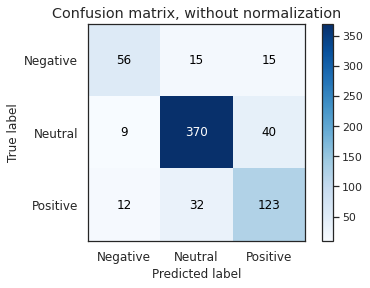

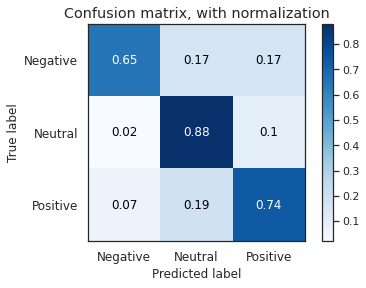

Starting epoch 22
Epoch: 22/30 Step: 10... Loss: 0.000045 Val Loss: 1.455494 Accuracy: 0.818452 F1 Score: 0.763686
Epoch: 22/30 Step: 20... Loss: 0.000061 Val Loss: 1.459752 Accuracy: 0.818452 F1 Score: 0.763686
Epoch: 22/30 Step: 30... Loss: 0.000204 Val Loss: 1.461095 Accuracy: 0.819940 F1 Score: 0.767094
Epoch: 22/30 Step: 40... Loss: 0.000192 Val Loss: 1.463817 Accuracy: 0.818452 F1 Score: 0.763369
Epoch: 22/30 Step: 50... Loss: 0.000316 Val Loss: 1.466592 Accuracy: 0.816964 F1 Score: 0.762235
Epoch: 22/30 Step: 60... Loss: 0.000061 Val Loss: 1.469563 Accuracy: 0.816964 F1 Score: 0.762235
Epoch: 22/30 Step: 70... Loss: 0.000206 Val Loss: 1.471595 Accuracy: 0.816964 F1 Score: 0.763748
Epoch: 22/30 Step: 80... Loss: 0.000063 Val Loss: 1.473018 Accuracy: 0.816964 F1 Score: 0.763748
87 steps in epoch 22

Epoch: 22, Average Accuracy: 0.81696429, Average f1: 0.76374794



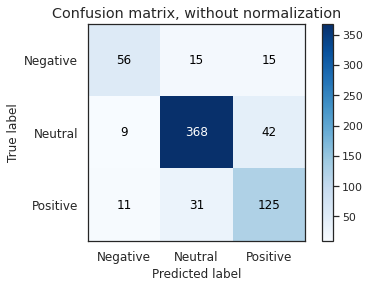

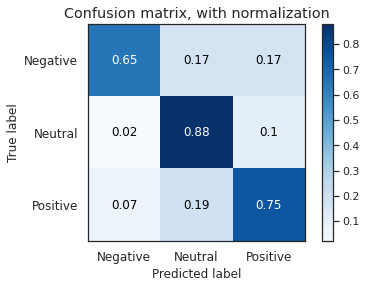

Starting epoch 23
Epoch: 23/30 Step: 10... Loss: 0.000041 Val Loss: 1.473739 Accuracy: 0.816964 F1 Score: 0.763314
Epoch: 23/30 Step: 20... Loss: 0.000069 Val Loss: 1.477356 Accuracy: 0.819940 F1 Score: 0.765585
Epoch: 23/30 Step: 30... Loss: 0.000268 Val Loss: 1.473130 Accuracy: 0.821429 F1 Score: 0.766712
Epoch: 23/30 Step: 40... Loss: 0.000410 Val Loss: 1.472174 Accuracy: 0.818452 F1 Score: 0.764461
Epoch: 23/30 Step: 50... Loss: 0.000308 Val Loss: 1.472152 Accuracy: 0.816964 F1 Score: 0.761772
Epoch: 23/30 Step: 60... Loss: 0.000048 Val Loss: 1.474777 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 23/30 Step: 70... Loss: 0.000148 Val Loss: 1.477003 Accuracy: 0.816964 F1 Score: 0.759920
Epoch: 23/30 Step: 80... Loss: 0.000087 Val Loss: 1.479159 Accuracy: 0.816964 F1 Score: 0.759920
87 steps in epoch 23

Epoch: 23, Average Accuracy: 0.81696429, Average f1: 0.75991951



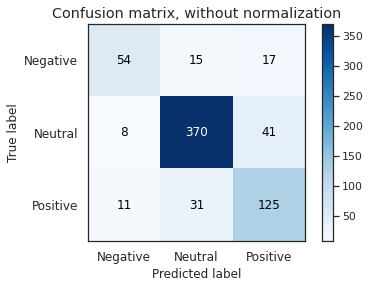

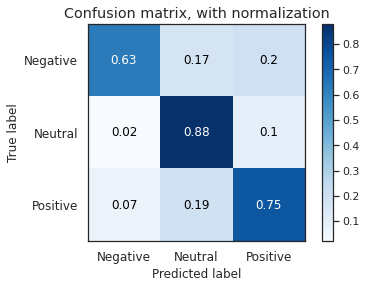

Starting epoch 24
Epoch: 24/30 Step: 10... Loss: 0.000053 Val Loss: 1.483493 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 24/30 Step: 20... Loss: 0.000057 Val Loss: 1.484621 Accuracy: 0.816964 F1 Score: 0.759920
Epoch: 24/30 Step: 30... Loss: 0.000253 Val Loss: 1.483138 Accuracy: 0.815476 F1 Score: 0.757733
Epoch: 24/30 Step: 40... Loss: 0.000540 Val Loss: 1.484663 Accuracy: 0.816964 F1 Score: 0.761113
Epoch: 24/30 Step: 50... Loss: 0.000813 Val Loss: 1.487688 Accuracy: 0.813988 F1 Score: 0.757350
Epoch: 24/30 Step: 60... Loss: 0.000031 Val Loss: 1.493499 Accuracy: 0.813988 F1 Score: 0.756613
Epoch: 24/30 Step: 70... Loss: 0.000301 Val Loss: 1.496816 Accuracy: 0.816964 F1 Score: 0.761902
Epoch: 24/30 Step: 80... Loss: 0.000055 Val Loss: 1.499237 Accuracy: 0.816964 F1 Score: 0.759920
87 steps in epoch 24

Epoch: 24, Average Accuracy: 0.81696429, Average f1: 0.75991951



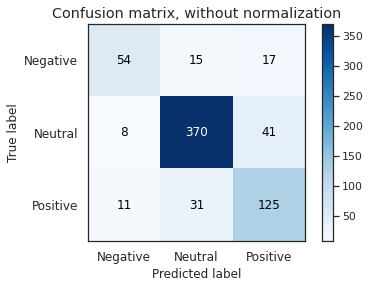

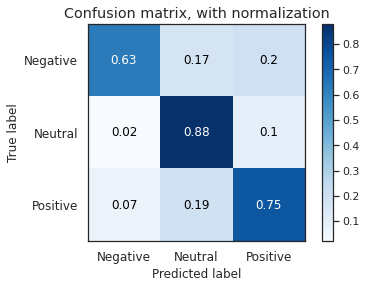

Starting epoch 25
Epoch: 25/30 Step: 10... Loss: 0.000049 Val Loss: 1.501540 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 25/30 Step: 20... Loss: 0.000064 Val Loss: 1.502678 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 25/30 Step: 30... Loss: 0.000163 Val Loss: 1.501988 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 25/30 Step: 40... Loss: 0.000096 Val Loss: 1.502000 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 25/30 Step: 50... Loss: 0.000190 Val Loss: 1.503164 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 25/30 Step: 60... Loss: 0.000077 Val Loss: 1.505372 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 25/30 Step: 70... Loss: 0.000129 Val Loss: 1.506551 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 25/30 Step: 80... Loss: 0.000038 Val Loss: 1.508205 Accuracy: 0.816964 F1 Score: 0.760674
87 steps in epoch 25

Epoch: 25, Average Accuracy: 0.81696429, Average f1: 0.76067419



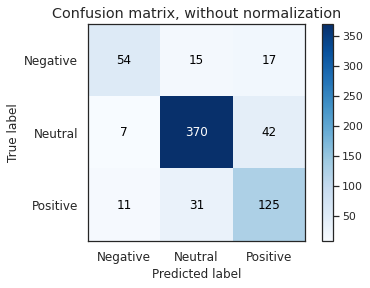

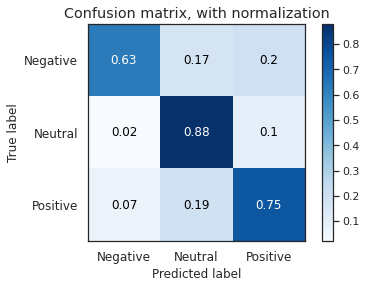

Starting epoch 26
Epoch: 26/30 Step: 10... Loss: 0.000066 Val Loss: 1.511352 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 26/30 Step: 20... Loss: 0.000051 Val Loss: 1.513312 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 26/30 Step: 30... Loss: 0.000326 Val Loss: 1.513638 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 26/30 Step: 40... Loss: 0.000086 Val Loss: 1.512040 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 26/30 Step: 50... Loss: 0.000178 Val Loss: 1.511463 Accuracy: 0.816964 F1 Score: 0.759920
Epoch: 26/30 Step: 60... Loss: 0.000031 Val Loss: 1.513373 Accuracy: 0.816964 F1 Score: 0.759920
Epoch: 26/30 Step: 70... Loss: 0.000174 Val Loss: 1.514145 Accuracy: 0.816964 F1 Score: 0.759920
Epoch: 26/30 Step: 80... Loss: 0.000040 Val Loss: 1.515835 Accuracy: 0.816964 F1 Score: 0.759920
87 steps in epoch 26

Epoch: 26, Average Accuracy: 0.81696429, Average f1: 0.75991951



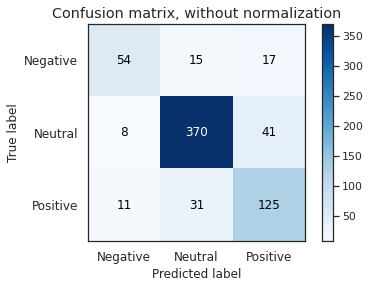

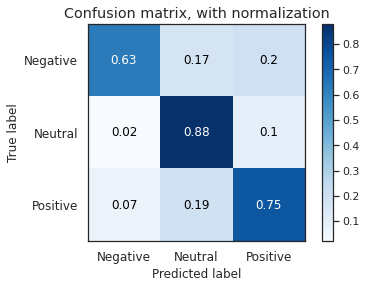

Starting epoch 27
Epoch: 27/30 Step: 10... Loss: 0.000042 Val Loss: 1.521551 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 27/30 Step: 20... Loss: 0.000033 Val Loss: 1.524764 Accuracy: 0.816964 F1 Score: 0.760674
Epoch: 27/30 Step: 30... Loss: 0.000241 Val Loss: 1.520886 Accuracy: 0.816964 F1 Score: 0.759920
Epoch: 27/30 Step: 40... Loss: 0.000111 Val Loss: 1.518614 Accuracy: 0.815476 F1 Score: 0.757276
Epoch: 27/30 Step: 50... Loss: 0.000301 Val Loss: 1.519637 Accuracy: 0.813988 F1 Score: 0.756934
Epoch: 27/30 Step: 60... Loss: 0.000065 Val Loss: 1.523193 Accuracy: 0.815476 F1 Score: 0.759989
Epoch: 27/30 Step: 70... Loss: 0.000184 Val Loss: 1.524537 Accuracy: 0.815476 F1 Score: 0.759989
Epoch: 27/30 Step: 80... Loss: 0.000040 Val Loss: 1.524847 Accuracy: 0.816964 F1 Score: 0.759920
87 steps in epoch 27

Epoch: 27, Average Accuracy: 0.81696429, Average f1: 0.75991951



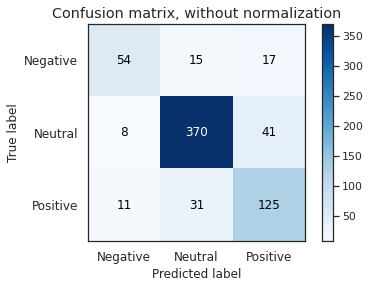

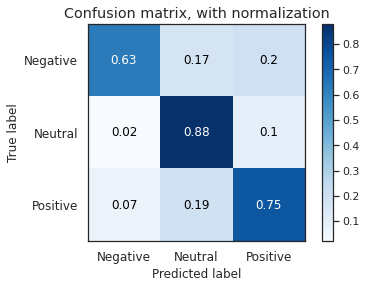

Starting epoch 28
Epoch: 28/30 Step: 10... Loss: 0.000024 Val Loss: 1.524046 Accuracy: 0.819940 F1 Score: 0.765585
Epoch: 28/30 Step: 20... Loss: 0.000058 Val Loss: 1.525747 Accuracy: 0.819940 F1 Score: 0.765585
Epoch: 28/30 Step: 30... Loss: 0.000121 Val Loss: 1.523860 Accuracy: 0.819940 F1 Score: 0.765585
Epoch: 28/30 Step: 40... Loss: 0.000100 Val Loss: 1.523965 Accuracy: 0.819940 F1 Score: 0.765585
Epoch: 28/30 Step: 50... Loss: 0.000251 Val Loss: 1.525094 Accuracy: 0.819940 F1 Score: 0.764469
Epoch: 28/30 Step: 60... Loss: 0.000030 Val Loss: 1.527662 Accuracy: 0.819940 F1 Score: 0.764469
Epoch: 28/30 Step: 70... Loss: 0.000126 Val Loss: 1.529403 Accuracy: 0.819940 F1 Score: 0.764469
Epoch: 28/30 Step: 80... Loss: 0.000042 Val Loss: 1.531848 Accuracy: 0.819940 F1 Score: 0.764469
87 steps in epoch 28

Epoch: 28, Average Accuracy: 0.81994048, Average f1: 0.76446887



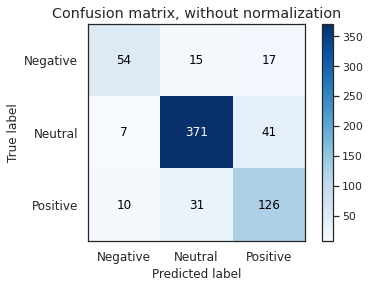

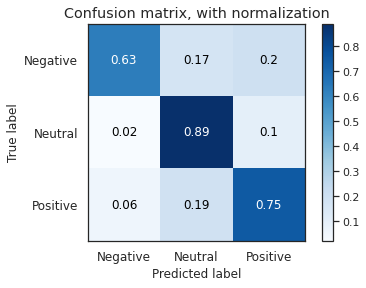

Starting epoch 29
Epoch: 29/30 Step: 10... Loss: 0.000026 Val Loss: 1.535918 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 29/30 Step: 20... Loss: 0.000026 Val Loss: 1.537774 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 29/30 Step: 30... Loss: 0.000115 Val Loss: 1.538286 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 29/30 Step: 40... Loss: 0.000263 Val Loss: 1.539196 Accuracy: 0.819940 F1 Score: 0.764469
Epoch: 29/30 Step: 50... Loss: 0.000130 Val Loss: 1.540282 Accuracy: 0.819940 F1 Score: 0.764469
Epoch: 29/30 Step: 60... Loss: 0.000031 Val Loss: 1.542166 Accuracy: 0.819940 F1 Score: 0.764469
Epoch: 29/30 Step: 70... Loss: 0.000141 Val Loss: 1.543569 Accuracy: 0.819940 F1 Score: 0.764469
Epoch: 29/30 Step: 80... Loss: 0.000053 Val Loss: 1.545032 Accuracy: 0.819940 F1 Score: 0.764469
87 steps in epoch 29

Epoch: 29, Average Accuracy: 0.81994048, Average f1: 0.76446887



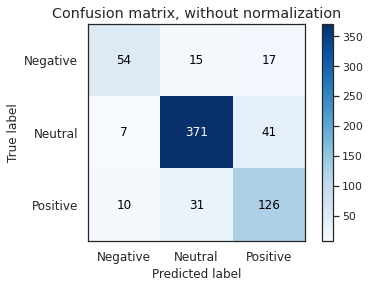

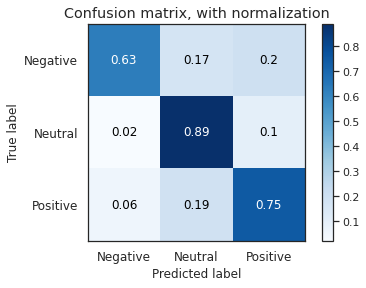

Starting epoch 30
Epoch: 30/30 Step: 10... Loss: 0.000026 Val Loss: 1.549573 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 30/30 Step: 20... Loss: 0.000061 Val Loss: 1.552001 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 30/30 Step: 30... Loss: 0.000220 Val Loss: 1.552939 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 30/30 Step: 40... Loss: 0.000067 Val Loss: 1.554100 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 30/30 Step: 50... Loss: 0.000119 Val Loss: 1.555365 Accuracy: 0.816964 F1 Score: 0.762224
Epoch: 30/30 Step: 60... Loss: 0.000076 Val Loss: 1.556504 Accuracy: 0.816964 F1 Score: 0.762224
Epoch: 30/30 Step: 70... Loss: 0.000075 Val Loss: 1.556360 Accuracy: 0.818452 F1 Score: 0.763345
Epoch: 30/30 Step: 80... Loss: 0.000035 Val Loss: 1.557552 Accuracy: 0.818452 F1 Score: 0.763345
87 steps in epoch 30

Epoch: 30, Average Accuracy: 0.81845238, Average f1: 0.76334491



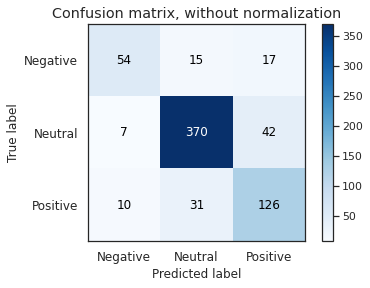

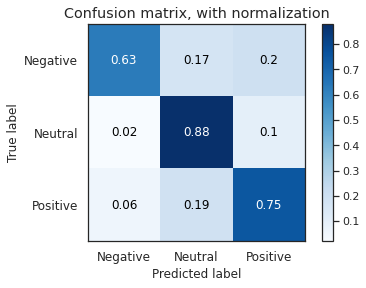

########## END ##########
Best Epoch: 11, Best F1: 0.76571975


In [92]:
best_acc, best_f1, best_epoch = train_model(model)

## Result

In [93]:
print("Accuracy: %.8f, F1: %.8f at Epoch: %d" % (best_acc, best_f1, best_epoch))

result_df.loc['C: LSTM'] = (round(best_acc,4), round(best_f1,4))
result_df

Accuracy: 0.81845238, F1: 0.76571975 at Epoch: 11


Accuracy      F1
A: Lexicon      0.6522  0.4506
B: Tfidf        0.8145  0.7195
C: LSTM         0.8185  0.7657
D: LSTM+GloVe      NaN     NaN
E: BERT            NaN     NaN
F: ALBERT          NaN     NaN

# D. Glove Word Embedding + LSTM
Use GloVe word embedding as embedding layer

### Download GloVe files

In [94]:
# Use 6B 300d uncased
glove_file_pickle = 'glove.6B.300d.pickle'
glove_file_zip = 'glove.6B.zip'
glove_file_txt = 'glove.6B.300d.txt'

# # User 42B 300d uncased
# glove_file_pickle = 'glove.42B.300d.pickle'
# glove_file_zip = 'glove.42B.300d.zip'
# glove_file_txt = 'glove.42B.300d.txt'

# Download Glove file if not exist
if not os.path.exists(glove_dir + glove_file_pickle):
    if not os.path.exists(glove_dir):
        os.mkdir(glove_dir)
    if not os.path.exists(glove_dir + glove_file_zip):
        !wget -o $glove_dir$glove_file_zip http://nlp.stanford.edu/data/$glove_file_zip
    # Unzip the downloaded file
    !unzip $glove_dir$glove_file_zip -d $glove_dir
    embedding_dict = {}

    with open(glove_dir + glove_file_txt, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_dir + glove_file_pickle, 'wb'))

In [95]:
glove_dict = pickle.load(open(glove_dir + glove_file_pickle, 'rb'))
print("The number of words in the dict: ", len(glove_dict))
print("Embedding for the word 'the':")
glove_dict['the']

The number of words in the dict:  400000
Embedding for the word 'the':


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [96]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

6406 words found out of 7135 words in vocab.
(7136, 300)


### Define Model

In [97]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        # self.fc1 = nn.Linear(lstm_size, dense_size)
        # self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        # dense_out = self.fc1(lstm_out)
        # out = self.fc2(dense_out)
        out = self.fc(lstm_out)
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [98]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(7136, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Starting epoch 1
Epoch: 1/30 Step: 10... Loss: 1.071147 Val Loss: 1.078280 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 1/30 Step: 20... Loss: 1.076633 Val Loss: 1.062343 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 1/30 Step: 30... Loss: 1.085204 Val Loss: 1.043038 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 1/30 Step: 40... Loss: 0.995431 Val Loss: 1.019657 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 1/30 Step: 50... Loss: 1.043902 Val Loss: 0.984994 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 1/30 Step: 60... Loss: 0.856249 Val Loss: 0.940626 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 1/30 Step: 70... Loss: 0.929399 Val Loss: 0.909464 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 1/30 Step: 80... Loss: 0.792742 Val Loss: 0.904077 Accuracy: 0.623512 F1 Score: 0.256034
87 steps in epoch 1

Epoch: 1, Average Accuracy: 0.62351190, Average f1: 0.25603422



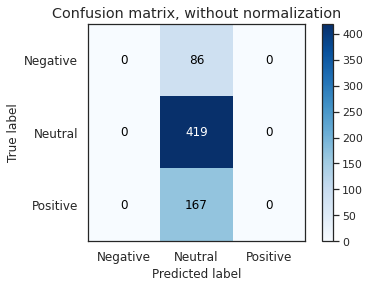

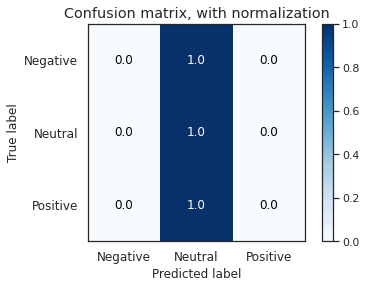

Starting epoch 2
Epoch: 2/30 Step: 10... Loss: 0.758843 Val Loss: 0.890576 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 2/30 Step: 20... Loss: 0.994893 Val Loss: 0.882774 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 2/30 Step: 30... Loss: 1.080789 Val Loss: 0.865889 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 2/30 Step: 40... Loss: 0.765529 Val Loss: 0.851353 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 2/30 Step: 50... Loss: 1.034498 Val Loss: 0.837582 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 2/30 Step: 60... Loss: 0.640296 Val Loss: 0.825758 Accuracy: 0.623512 F1 Score: 0.256034
Epoch: 2/30 Step: 70... Loss: 0.855916 Val Loss: 0.810733 Accuracy: 0.625000 F1 Score: 0.260237
Epoch: 2/30 Step: 80... Loss: 0.743161 Val Loss: 0.795195 Accuracy: 0.627976 F1 Score: 0.268841
87 steps in epoch 2

Epoch: 2, Average Accuracy: 0.62797619, Average f1: 0.26884092



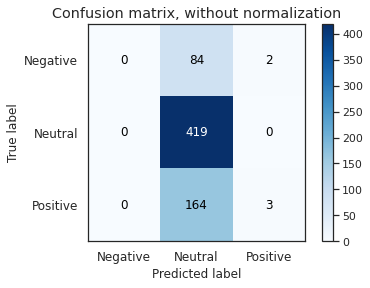

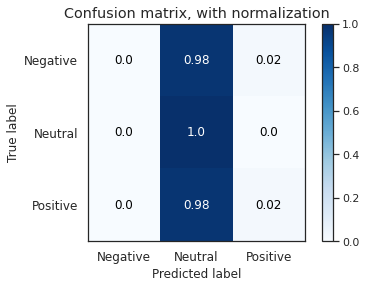

Starting epoch 3
Epoch: 3/30 Step: 10... Loss: 0.607309 Val Loss: 0.776838 Accuracy: 0.653274 F1 Score: 0.334819
Epoch: 3/30 Step: 20... Loss: 0.885855 Val Loss: 0.777133 Accuracy: 0.683036 F1 Score: 0.407772
Epoch: 3/30 Step: 30... Loss: 1.029936 Val Loss: 0.776421 Accuracy: 0.671131 F1 Score: 0.393079
Epoch: 3/30 Step: 40... Loss: 0.711397 Val Loss: 0.773278 Accuracy: 0.694940 F1 Score: 0.450181
Epoch: 3/30 Step: 50... Loss: 0.915295 Val Loss: 0.761048 Accuracy: 0.690476 F1 Score: 0.427287
Epoch: 3/30 Step: 60... Loss: 0.516981 Val Loss: 0.757577 Accuracy: 0.703869 F1 Score: 0.463045
Epoch: 3/30 Step: 70... Loss: 0.775232 Val Loss: 0.751342 Accuracy: 0.696429 F1 Score: 0.433026
Epoch: 3/30 Step: 80... Loss: 0.717724 Val Loss: 0.748001 Accuracy: 0.697917 F1 Score: 0.437027
87 steps in epoch 3

Epoch: 3, Average Accuracy: 0.69791667, Average f1: 0.43702744



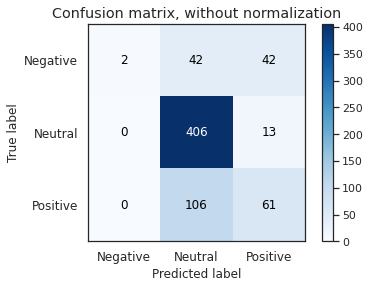

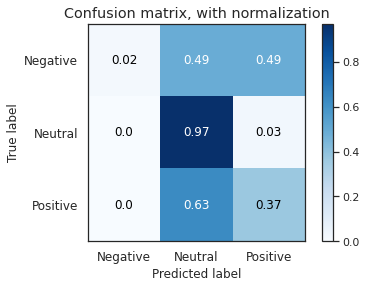

Starting epoch 4
Epoch: 4/30 Step: 10... Loss: 0.588294 Val Loss: 0.744423 Accuracy: 0.700893 F1 Score: 0.443165
Epoch: 4/30 Step: 20... Loss: 0.839744 Val Loss: 0.741756 Accuracy: 0.700893 F1 Score: 0.450180
Epoch: 4/30 Step: 30... Loss: 0.934896 Val Loss: 0.745128 Accuracy: 0.691964 F1 Score: 0.420077
Epoch: 4/30 Step: 40... Loss: 0.693879 Val Loss: 0.743610 Accuracy: 0.690476 F1 Score: 0.437130
Epoch: 4/30 Step: 50... Loss: 0.852923 Val Loss: 0.739348 Accuracy: 0.693452 F1 Score: 0.427053
Epoch: 4/30 Step: 60... Loss: 0.469761 Val Loss: 0.733374 Accuracy: 0.691964 F1 Score: 0.432694
Epoch: 4/30 Step: 70... Loss: 0.755384 Val Loss: 0.729782 Accuracy: 0.694940 F1 Score: 0.433484
Epoch: 4/30 Step: 80... Loss: 0.711039 Val Loss: 0.727086 Accuracy: 0.691964 F1 Score: 0.435593
87 steps in epoch 4

Epoch: 4, Average Accuracy: 0.69196429, Average f1: 0.43559300



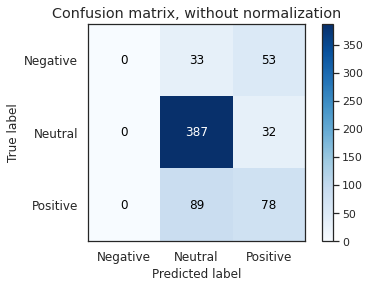

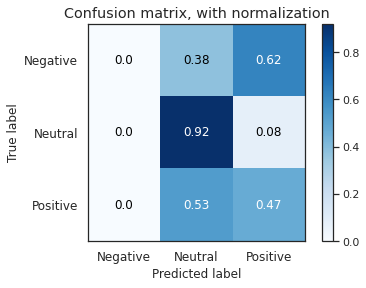

Starting epoch 5
Epoch: 5/30 Step: 10... Loss: 0.576628 Val Loss: 0.725609 Accuracy: 0.700893 F1 Score: 0.438281
Epoch: 5/30 Step: 20... Loss: 0.795503 Val Loss: 0.722150 Accuracy: 0.693452 F1 Score: 0.439273
Epoch: 5/30 Step: 30... Loss: 0.924192 Val Loss: 0.724893 Accuracy: 0.700893 F1 Score: 0.437685
Epoch: 5/30 Step: 40... Loss: 0.681092 Val Loss: 0.726011 Accuracy: 0.694940 F1 Score: 0.448144
Epoch: 5/30 Step: 50... Loss: 0.835005 Val Loss: 0.720543 Accuracy: 0.705357 F1 Score: 0.446760
Epoch: 5/30 Step: 60... Loss: 0.433024 Val Loss: 0.717443 Accuracy: 0.693452 F1 Score: 0.443657
Epoch: 5/30 Step: 70... Loss: 0.689685 Val Loss: 0.713597 Accuracy: 0.700893 F1 Score: 0.445611
Epoch: 5/30 Step: 80... Loss: 0.709906 Val Loss: 0.711616 Accuracy: 0.700893 F1 Score: 0.447173
87 steps in epoch 5

Epoch: 5, Average Accuracy: 0.70089286, Average f1: 0.44717282



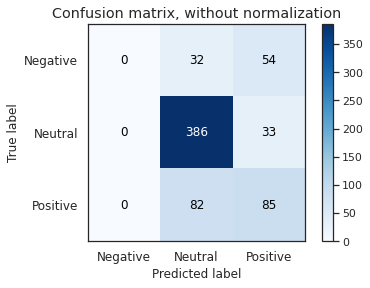

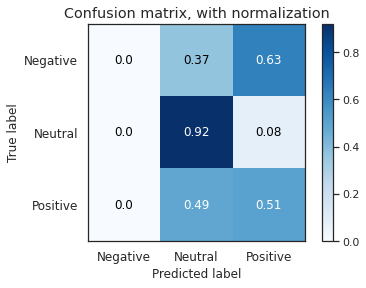

Starting epoch 6
Epoch: 6/30 Step: 10... Loss: 0.522260 Val Loss: 0.711862 Accuracy: 0.703869 F1 Score: 0.443033
Epoch: 6/30 Step: 20... Loss: 0.791334 Val Loss: 0.708117 Accuracy: 0.700893 F1 Score: 0.450723
Epoch: 6/30 Step: 30... Loss: 0.894855 Val Loss: 0.712033 Accuracy: 0.703869 F1 Score: 0.442487
Epoch: 6/30 Step: 40... Loss: 0.662435 Val Loss: 0.712583 Accuracy: 0.696429 F1 Score: 0.448719
Epoch: 6/30 Step: 50... Loss: 0.799179 Val Loss: 0.707259 Accuracy: 0.708333 F1 Score: 0.449520
Epoch: 6/30 Step: 60... Loss: 0.408616 Val Loss: 0.704653 Accuracy: 0.699405 F1 Score: 0.449259
Epoch: 6/30 Step: 70... Loss: 0.639336 Val Loss: 0.699412 Accuracy: 0.708333 F1 Score: 0.453685
Epoch: 6/30 Step: 80... Loss: 0.679000 Val Loss: 0.697014 Accuracy: 0.703869 F1 Score: 0.451550
87 steps in epoch 6

Epoch: 6, Average Accuracy: 0.70386905, Average f1: 0.45154986



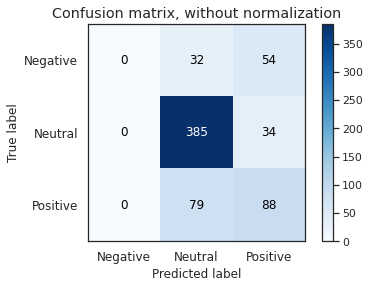

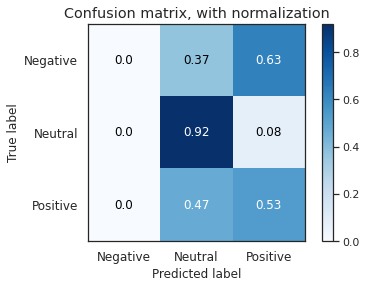

Starting epoch 7
Epoch: 7/30 Step: 10... Loss: 0.519938 Val Loss: 0.704624 Accuracy: 0.705357 F1 Score: 0.439631
Epoch: 7/30 Step: 20... Loss: 0.776406 Val Loss: 0.698985 Accuracy: 0.688988 F1 Score: 0.444221
Epoch: 7/30 Step: 30... Loss: 0.878624 Val Loss: 0.697547 Accuracy: 0.706845 F1 Score: 0.444334
Epoch: 7/30 Step: 40... Loss: 0.644600 Val Loss: 0.697844 Accuracy: 0.694940 F1 Score: 0.449226
Epoch: 7/30 Step: 50... Loss: 0.787403 Val Loss: 0.692687 Accuracy: 0.708333 F1 Score: 0.451097
Epoch: 7/30 Step: 60... Loss: 0.403370 Val Loss: 0.692158 Accuracy: 0.702381 F1 Score: 0.452523
Epoch: 7/30 Step: 70... Loss: 0.591449 Val Loss: 0.685199 Accuracy: 0.705357 F1 Score: 0.452916
Epoch: 7/30 Step: 80... Loss: 0.663738 Val Loss: 0.683396 Accuracy: 0.705357 F1 Score: 0.453548
87 steps in epoch 7

Epoch: 7, Average Accuracy: 0.70535714, Average f1: 0.45354793



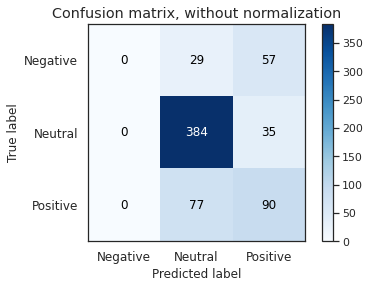

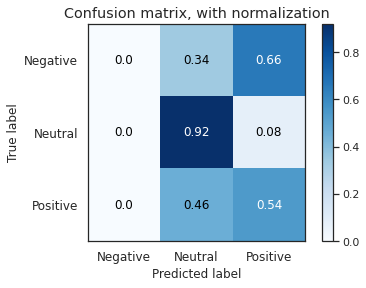

Starting epoch 8
Epoch: 8/30 Step: 10... Loss: 0.499413 Val Loss: 0.690520 Accuracy: 0.709821 F1 Score: 0.445438
Epoch: 8/30 Step: 20... Loss: 0.754132 Val Loss: 0.690901 Accuracy: 0.696429 F1 Score: 0.456403
Epoch: 8/30 Step: 30... Loss: 0.872454 Val Loss: 0.686745 Accuracy: 0.715774 F1 Score: 0.451627
Epoch: 8/30 Step: 40... Loss: 0.626158 Val Loss: 0.691911 Accuracy: 0.688988 F1 Score: 0.451197
Epoch: 8/30 Step: 50... Loss: 0.757158 Val Loss: 0.684000 Accuracy: 0.711310 F1 Score: 0.451600
Epoch: 8/30 Step: 60... Loss: 0.375786 Val Loss: 0.682121 Accuracy: 0.706845 F1 Score: 0.459610
Epoch: 8/30 Step: 70... Loss: 0.541689 Val Loss: 0.671344 Accuracy: 0.709821 F1 Score: 0.455296
Epoch: 8/30 Step: 80... Loss: 0.658029 Val Loss: 0.674992 Accuracy: 0.693452 F1 Score: 0.449408
87 steps in epoch 8

Epoch: 8, Average Accuracy: 0.69345238, Average f1: 0.44940816



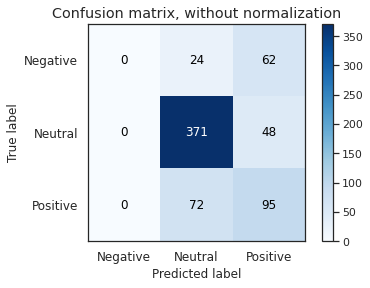

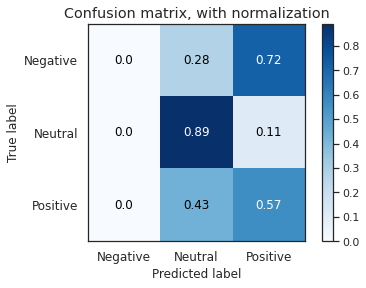

Starting epoch 9
Epoch: 9/30 Step: 10... Loss: 0.499698 Val Loss: 0.693692 Accuracy: 0.714286 F1 Score: 0.449232
Epoch: 9/30 Step: 20... Loss: 0.749226 Val Loss: 0.691654 Accuracy: 0.696429 F1 Score: 0.462344
Epoch: 9/30 Step: 30... Loss: 0.850072 Val Loss: 0.675706 Accuracy: 0.714286 F1 Score: 0.449965
Epoch: 9/30 Step: 40... Loss: 0.578685 Val Loss: 0.681423 Accuracy: 0.694940 F1 Score: 0.457247
Epoch: 9/30 Step: 50... Loss: 0.752184 Val Loss: 0.672329 Accuracy: 0.720238 F1 Score: 0.459232
Epoch: 9/30 Step: 60... Loss: 0.368496 Val Loss: 0.665853 Accuracy: 0.708333 F1 Score: 0.461250
Epoch: 9/30 Step: 70... Loss: 0.476264 Val Loss: 0.658421 Accuracy: 0.714286 F1 Score: 0.460905
Epoch: 9/30 Step: 80... Loss: 0.655575 Val Loss: 0.665395 Accuracy: 0.697917 F1 Score: 0.453595
87 steps in epoch 9

Epoch: 9, Average Accuracy: 0.69791667, Average f1: 0.45359507



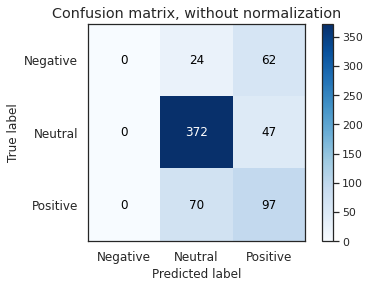

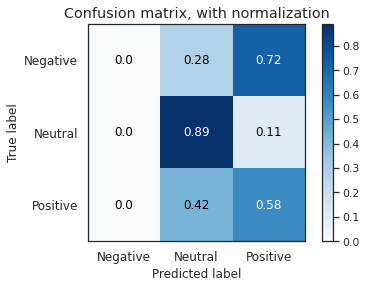

Starting epoch 10
Epoch: 10/30 Step: 10... Loss: 0.511855 Val Loss: 0.691451 Accuracy: 0.717262 F1 Score: 0.451849
Epoch: 10/30 Step: 20... Loss: 0.720264 Val Loss: 0.685898 Accuracy: 0.690476 F1 Score: 0.458725
Epoch: 10/30 Step: 30... Loss: 0.825085 Val Loss: 0.665709 Accuracy: 0.720238 F1 Score: 0.457253
Epoch: 10/30 Step: 40... Loss: 0.574444 Val Loss: 0.675843 Accuracy: 0.697917 F1 Score: 0.468060
Epoch: 10/30 Step: 50... Loss: 0.697750 Val Loss: 0.664515 Accuracy: 0.721726 F1 Score: 0.467649
Epoch: 10/30 Step: 60... Loss: 0.347553 Val Loss: 0.655487 Accuracy: 0.709821 F1 Score: 0.470187
Epoch: 10/30 Step: 70... Loss: 0.436093 Val Loss: 0.649793 Accuracy: 0.708333 F1 Score: 0.466068
Epoch: 10/30 Step: 80... Loss: 0.605891 Val Loss: 0.669846 Accuracy: 0.708333 F1 Score: 0.467157
87 steps in epoch 10

Epoch: 10, Average Accuracy: 0.70833333, Average f1: 0.46715672



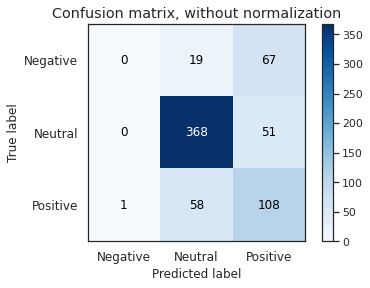

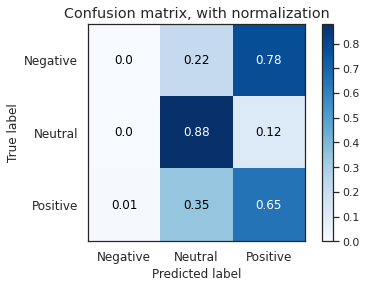

Starting epoch 11
Epoch: 11/30 Step: 10... Loss: 0.459918 Val Loss: 0.686518 Accuracy: 0.726190 F1 Score: 0.482375
Epoch: 11/30 Step: 20... Loss: 0.720589 Val Loss: 0.683945 Accuracy: 0.702381 F1 Score: 0.507567
Epoch: 11/30 Step: 30... Loss: 0.790395 Val Loss: 0.658147 Accuracy: 0.732143 F1 Score: 0.544609
Epoch: 11/30 Step: 40... Loss: 0.540916 Val Loss: 0.663706 Accuracy: 0.708333 F1 Score: 0.507188
Epoch: 11/30 Step: 50... Loss: 0.660603 Val Loss: 0.655222 Accuracy: 0.721726 F1 Score: 0.493219
Epoch: 11/30 Step: 60... Loss: 0.340640 Val Loss: 0.643847 Accuracy: 0.714286 F1 Score: 0.487647
Epoch: 11/30 Step: 70... Loss: 0.368359 Val Loss: 0.641331 Accuracy: 0.714286 F1 Score: 0.494078
Epoch: 11/30 Step: 80... Loss: 0.584952 Val Loss: 0.651636 Accuracy: 0.705357 F1 Score: 0.476769
87 steps in epoch 11

Epoch: 11, Average Accuracy: 0.70535714, Average f1: 0.47676887



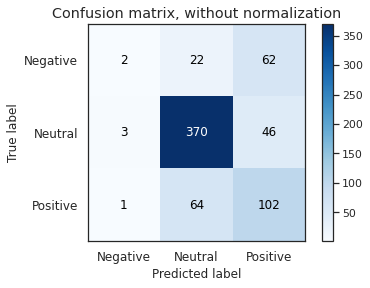

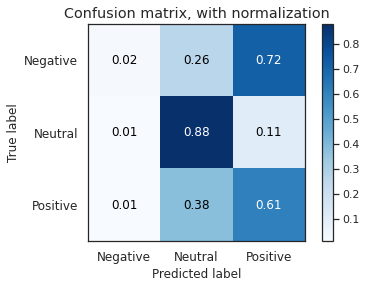

Starting epoch 12
Epoch: 12/30 Step: 10... Loss: 0.458910 Val Loss: 0.668352 Accuracy: 0.748512 F1 Score: 0.593451
Epoch: 12/30 Step: 20... Loss: 0.717675 Val Loss: 0.683137 Accuracy: 0.715774 F1 Score: 0.590307
Epoch: 12/30 Step: 30... Loss: 0.783370 Val Loss: 0.646683 Accuracy: 0.741071 F1 Score: 0.571249
Epoch: 12/30 Step: 40... Loss: 0.508540 Val Loss: 0.654620 Accuracy: 0.723214 F1 Score: 0.576992
Epoch: 12/30 Step: 50... Loss: 0.625313 Val Loss: 0.638607 Accuracy: 0.741071 F1 Score: 0.556216
Epoch: 12/30 Step: 60... Loss: 0.313830 Val Loss: 0.632870 Accuracy: 0.724702 F1 Score: 0.523625
Epoch: 12/30 Step: 70... Loss: 0.345236 Val Loss: 0.633137 Accuracy: 0.730655 F1 Score: 0.576953
Epoch: 12/30 Step: 80... Loss: 0.580633 Val Loss: 0.637764 Accuracy: 0.727679 F1 Score: 0.559451
87 steps in epoch 12

Epoch: 12, Average Accuracy: 0.72767857, Average f1: 0.55945085



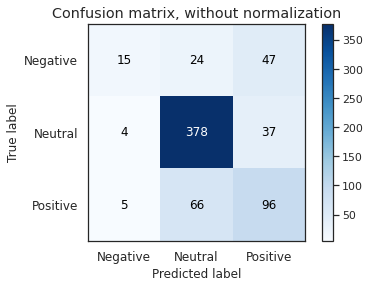

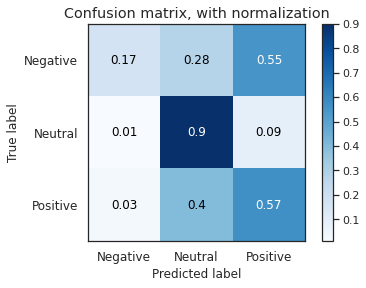

Starting epoch 13
Epoch: 13/30 Step: 10... Loss: 0.413089 Val Loss: 0.655415 Accuracy: 0.757440 F1 Score: 0.627351
Epoch: 13/30 Step: 20... Loss: 0.699913 Val Loss: 0.683539 Accuracy: 0.720238 F1 Score: 0.621901
Epoch: 13/30 Step: 30... Loss: 0.754388 Val Loss: 0.634006 Accuracy: 0.754464 F1 Score: 0.619723
Epoch: 13/30 Step: 40... Loss: 0.449472 Val Loss: 0.641355 Accuracy: 0.732143 F1 Score: 0.618326
Epoch: 13/30 Step: 50... Loss: 0.582917 Val Loss: 0.626160 Accuracy: 0.747024 F1 Score: 0.590754
Epoch: 13/30 Step: 60... Loss: 0.323475 Val Loss: 0.627578 Accuracy: 0.744048 F1 Score: 0.597425
Epoch: 13/30 Step: 70... Loss: 0.301989 Val Loss: 0.624219 Accuracy: 0.747024 F1 Score: 0.628511
Epoch: 13/30 Step: 80... Loss: 0.554128 Val Loss: 0.622104 Accuracy: 0.754464 F1 Score: 0.637713
87 steps in epoch 13

Epoch: 13, Average Accuracy: 0.75446429, Average f1: 0.63771303



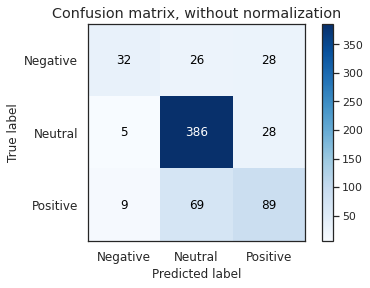

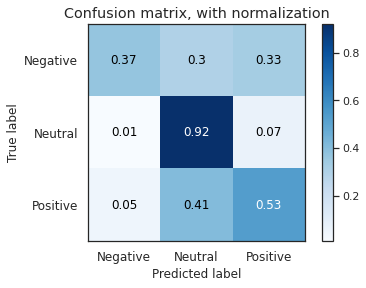

Starting epoch 14
Epoch: 14/30 Step: 10... Loss: 0.394144 Val Loss: 0.649521 Accuracy: 0.757440 F1 Score: 0.634949
Epoch: 14/30 Step: 20... Loss: 0.660035 Val Loss: 0.678124 Accuracy: 0.736607 F1 Score: 0.652541
Epoch: 14/30 Step: 30... Loss: 0.729465 Val Loss: 0.624547 Accuracy: 0.758929 F1 Score: 0.632438
Epoch: 14/30 Step: 40... Loss: 0.427178 Val Loss: 0.639525 Accuracy: 0.739583 F1 Score: 0.645311
Epoch: 14/30 Step: 50... Loss: 0.582172 Val Loss: 0.619085 Accuracy: 0.758929 F1 Score: 0.634167
Epoch: 14/30 Step: 60... Loss: 0.299645 Val Loss: 0.623274 Accuracy: 0.760417 F1 Score: 0.645001
Epoch: 14/30 Step: 70... Loss: 0.282937 Val Loss: 0.623645 Accuracy: 0.760417 F1 Score: 0.662193
Epoch: 14/30 Step: 80... Loss: 0.527114 Val Loss: 0.625721 Accuracy: 0.760417 F1 Score: 0.655961
87 steps in epoch 14

Epoch: 14, Average Accuracy: 0.76041667, Average f1: 0.65596083



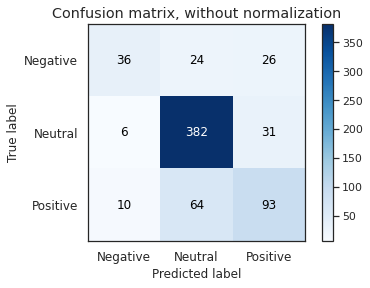

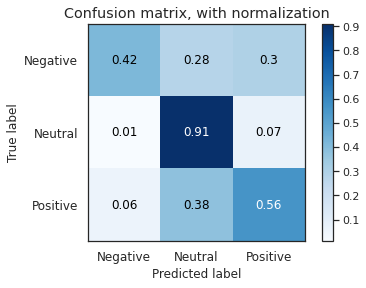

Starting epoch 15
Epoch: 15/30 Step: 10... Loss: 0.362410 Val Loss: 0.633493 Accuracy: 0.758929 F1 Score: 0.647020
Epoch: 15/30 Step: 20... Loss: 0.607972 Val Loss: 0.667890 Accuracy: 0.742560 F1 Score: 0.657804
Epoch: 15/30 Step: 30... Loss: 0.651764 Val Loss: 0.622280 Accuracy: 0.766369 F1 Score: 0.653591
Epoch: 15/30 Step: 40... Loss: 0.348256 Val Loss: 0.644812 Accuracy: 0.751488 F1 Score: 0.673346
Epoch: 15/30 Step: 50... Loss: 0.532309 Val Loss: 0.615596 Accuracy: 0.766369 F1 Score: 0.660093
Epoch: 15/30 Step: 60... Loss: 0.334326 Val Loss: 0.623772 Accuracy: 0.764881 F1 Score: 0.653168
Epoch: 15/30 Step: 70... Loss: 0.267829 Val Loss: 0.632279 Accuracy: 0.769345 F1 Score: 0.680855
Epoch: 15/30 Step: 80... Loss: 0.508431 Val Loss: 0.626574 Accuracy: 0.758929 F1 Score: 0.648494
87 steps in epoch 15

Epoch: 15, Average Accuracy: 0.75892857, Average f1: 0.64849379



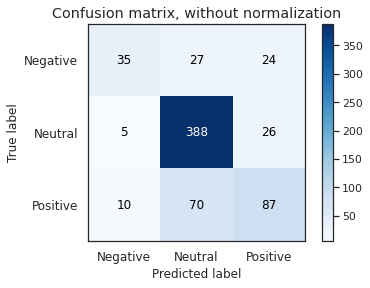

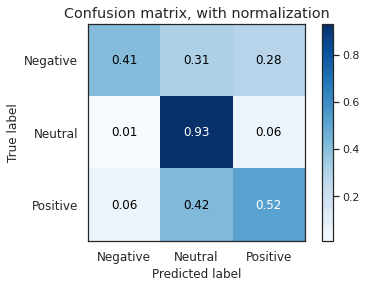

Starting epoch 16
Epoch: 16/30 Step: 10... Loss: 0.318609 Val Loss: 0.639426 Accuracy: 0.773810 F1 Score: 0.674157
Epoch: 16/30 Step: 20... Loss: 0.612030 Val Loss: 0.671121 Accuracy: 0.750000 F1 Score: 0.671535
Epoch: 16/30 Step: 30... Loss: 0.605362 Val Loss: 0.618971 Accuracy: 0.763393 F1 Score: 0.642702
Epoch: 16/30 Step: 40... Loss: 0.319183 Val Loss: 0.637823 Accuracy: 0.757440 F1 Score: 0.685056
Epoch: 16/30 Step: 50... Loss: 0.539005 Val Loss: 0.614781 Accuracy: 0.775298 F1 Score: 0.677373
Epoch: 16/30 Step: 60... Loss: 0.304410 Val Loss: 0.632211 Accuracy: 0.775298 F1 Score: 0.674008
Epoch: 16/30 Step: 70... Loss: 0.233136 Val Loss: 0.633297 Accuracy: 0.766369 F1 Score: 0.680651
Epoch: 16/30 Step: 80... Loss: 0.532715 Val Loss: 0.627088 Accuracy: 0.766369 F1 Score: 0.660381
87 steps in epoch 16

Epoch: 16, Average Accuracy: 0.76636905, Average f1: 0.66038066



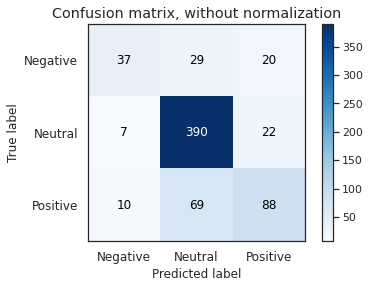

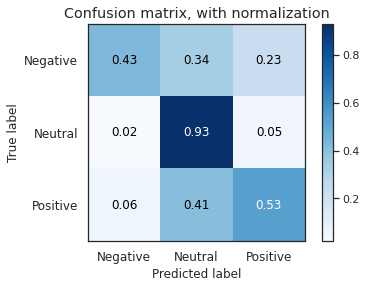

Starting epoch 17
Epoch: 17/30 Step: 10... Loss: 0.312601 Val Loss: 0.632614 Accuracy: 0.773810 F1 Score: 0.674157
Epoch: 17/30 Step: 20... Loss: 0.554243 Val Loss: 0.680868 Accuracy: 0.757440 F1 Score: 0.686709
Epoch: 17/30 Step: 30... Loss: 0.505594 Val Loss: 0.611336 Accuracy: 0.775298 F1 Score: 0.670758
Epoch: 17/30 Step: 40... Loss: 0.286723 Val Loss: 0.647999 Accuracy: 0.751488 F1 Score: 0.676642
Epoch: 17/30 Step: 50... Loss: 0.509902 Val Loss: 0.619710 Accuracy: 0.779762 F1 Score: 0.685115
Epoch: 17/30 Step: 60... Loss: 0.258849 Val Loss: 0.642558 Accuracy: 0.775298 F1 Score: 0.685536
Epoch: 17/30 Step: 70... Loss: 0.209573 Val Loss: 0.641243 Accuracy: 0.772321 F1 Score: 0.690334
Epoch: 17/30 Step: 80... Loss: 0.487040 Val Loss: 0.667575 Accuracy: 0.772321 F1 Score: 0.663936
87 steps in epoch 17

Epoch: 17, Average Accuracy: 0.77232143, Average f1: 0.66393583



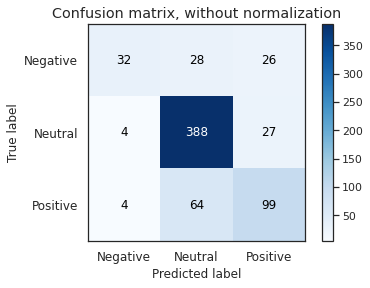

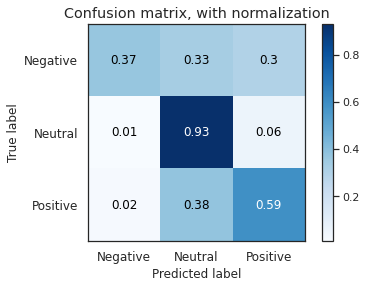

Starting epoch 18
Epoch: 18/30 Step: 10... Loss: 0.309318 Val Loss: 0.639991 Accuracy: 0.773810 F1 Score: 0.679029
Epoch: 18/30 Step: 20... Loss: 0.541626 Val Loss: 0.722342 Accuracy: 0.760417 F1 Score: 0.691702
Epoch: 18/30 Step: 30... Loss: 0.436270 Val Loss: 0.611410 Accuracy: 0.779762 F1 Score: 0.698437
Epoch: 18/30 Step: 40... Loss: 0.250377 Val Loss: 0.635282 Accuracy: 0.770833 F1 Score: 0.696032
Epoch: 18/30 Step: 50... Loss: 0.475982 Val Loss: 0.633546 Accuracy: 0.779762 F1 Score: 0.688039
Epoch: 18/30 Step: 60... Loss: 0.294382 Val Loss: 0.637628 Accuracy: 0.776786 F1 Score: 0.677929
Epoch: 18/30 Step: 70... Loss: 0.207920 Val Loss: 0.629135 Accuracy: 0.782738 F1 Score: 0.701678
Epoch: 18/30 Step: 80... Loss: 0.446235 Val Loss: 0.649882 Accuracy: 0.779762 F1 Score: 0.686967
87 steps in epoch 18

Epoch: 18, Average Accuracy: 0.77976190, Average f1: 0.68696733



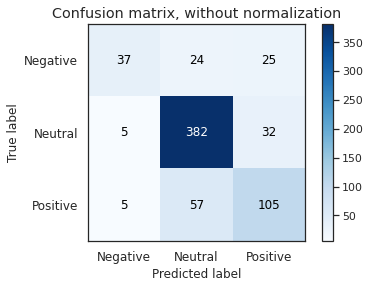

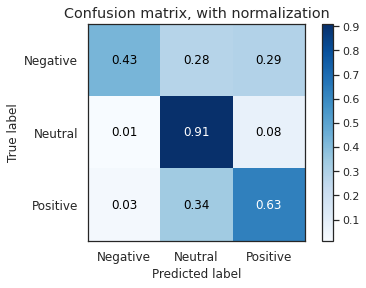

Starting epoch 19
Epoch: 19/30 Step: 10... Loss: 0.261706 Val Loss: 0.617025 Accuracy: 0.790179 F1 Score: 0.709685
Epoch: 19/30 Step: 20... Loss: 0.506515 Val Loss: 0.725360 Accuracy: 0.769345 F1 Score: 0.706175
Epoch: 19/30 Step: 30... Loss: 0.431235 Val Loss: 0.659005 Accuracy: 0.770833 F1 Score: 0.667209
Epoch: 19/30 Step: 40... Loss: 0.240076 Val Loss: 0.641414 Accuracy: 0.764881 F1 Score: 0.694415
Epoch: 19/30 Step: 50... Loss: 0.483040 Val Loss: 0.622261 Accuracy: 0.785714 F1 Score: 0.703400
Epoch: 19/30 Step: 60... Loss: 0.172511 Val Loss: 0.644738 Accuracy: 0.787202 F1 Score: 0.697305
Epoch: 19/30 Step: 70... Loss: 0.184621 Val Loss: 0.646319 Accuracy: 0.775298 F1 Score: 0.692887
Epoch: 19/30 Step: 80... Loss: 0.361433 Val Loss: 0.682846 Accuracy: 0.770833 F1 Score: 0.692753
87 steps in epoch 19

Epoch: 19, Average Accuracy: 0.77083333, Average f1: 0.69275250



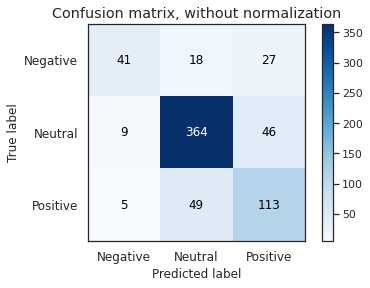

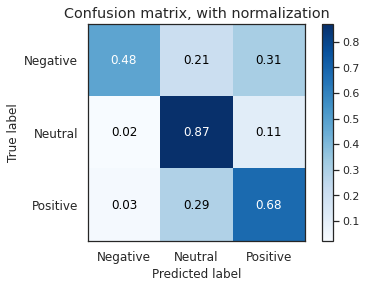

Starting epoch 20
Epoch: 20/30 Step: 10... Loss: 0.275779 Val Loss: 0.633606 Accuracy: 0.781250 F1 Score: 0.701012
Epoch: 20/30 Step: 20... Loss: 0.420612 Val Loss: 0.757364 Accuracy: 0.767857 F1 Score: 0.705990
Epoch: 20/30 Step: 30... Loss: 0.400142 Val Loss: 0.673809 Accuracy: 0.770833 F1 Score: 0.665276
Epoch: 20/30 Step: 40... Loss: 0.238515 Val Loss: 0.663874 Accuracy: 0.766369 F1 Score: 0.700431
Epoch: 20/30 Step: 50... Loss: 0.468807 Val Loss: 0.639169 Accuracy: 0.785714 F1 Score: 0.715085
Epoch: 20/30 Step: 60... Loss: 0.208545 Val Loss: 0.666570 Accuracy: 0.781250 F1 Score: 0.688550
Epoch: 20/30 Step: 70... Loss: 0.184990 Val Loss: 0.699448 Accuracy: 0.773810 F1 Score: 0.706166
Epoch: 20/30 Step: 80... Loss: 0.417340 Val Loss: 0.647520 Accuracy: 0.781250 F1 Score: 0.707368
87 steps in epoch 20

Epoch: 20, Average Accuracy: 0.78125000, Average f1: 0.70736780



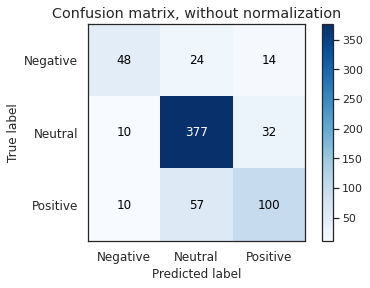

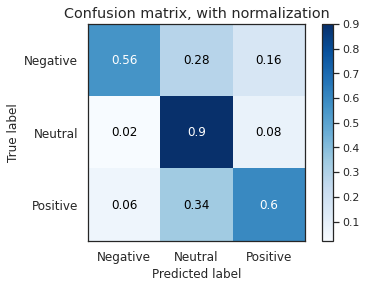

Starting epoch 21
Epoch: 21/30 Step: 10... Loss: 0.223665 Val Loss: 0.656607 Accuracy: 0.788690 F1 Score: 0.710039
Epoch: 21/30 Step: 20... Loss: 0.463836 Val Loss: 0.664991 Accuracy: 0.773810 F1 Score: 0.710786
Epoch: 21/30 Step: 30... Loss: 0.277143 Val Loss: 0.666779 Accuracy: 0.769345 F1 Score: 0.667002
Epoch: 21/30 Step: 40... Loss: 0.192210 Val Loss: 0.631132 Accuracy: 0.779762 F1 Score: 0.713079
Epoch: 21/30 Step: 50... Loss: 0.398144 Val Loss: 0.632065 Accuracy: 0.776786 F1 Score: 0.702689
Epoch: 21/30 Step: 60... Loss: 0.144045 Val Loss: 0.661217 Accuracy: 0.784226 F1 Score: 0.689128
Epoch: 21/30 Step: 70... Loss: 0.181187 Val Loss: 0.688968 Accuracy: 0.773810 F1 Score: 0.702779
Epoch: 21/30 Step: 80... Loss: 0.336403 Val Loss: 0.660257 Accuracy: 0.791667 F1 Score: 0.720372
87 steps in epoch 21

Epoch: 21, Average Accuracy: 0.79166667, Average f1: 0.72037205



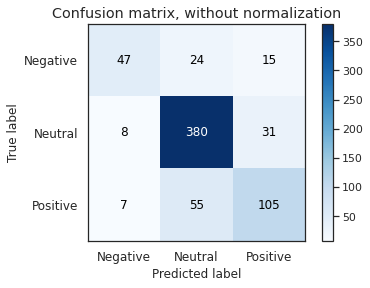

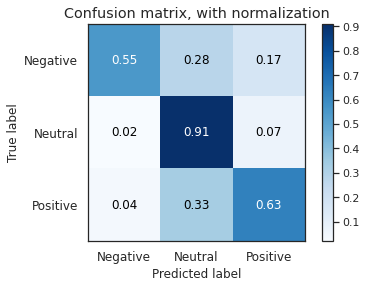

Starting epoch 22
Epoch: 22/30 Step: 10... Loss: 0.197478 Val Loss: 0.657061 Accuracy: 0.787202 F1 Score: 0.710262
Epoch: 22/30 Step: 20... Loss: 0.414210 Val Loss: 0.763178 Accuracy: 0.769345 F1 Score: 0.708842
Epoch: 22/30 Step: 30... Loss: 0.307348 Val Loss: 0.697688 Accuracy: 0.775298 F1 Score: 0.688125
Epoch: 22/30 Step: 40... Loss: 0.176956 Val Loss: 0.651049 Accuracy: 0.781250 F1 Score: 0.712343
Epoch: 22/30 Step: 50... Loss: 0.451245 Val Loss: 0.693698 Accuracy: 0.778274 F1 Score: 0.712994
Epoch: 22/30 Step: 60... Loss: 0.189651 Val Loss: 0.686457 Accuracy: 0.784226 F1 Score: 0.689665
Epoch: 22/30 Step: 70... Loss: 0.231469 Val Loss: 0.762688 Accuracy: 0.760417 F1 Score: 0.680108
Epoch: 22/30 Step: 80... Loss: 0.425941 Val Loss: 0.615238 Accuracy: 0.788690 F1 Score: 0.711670
87 steps in epoch 22

Epoch: 22, Average Accuracy: 0.78869048, Average f1: 0.71166997



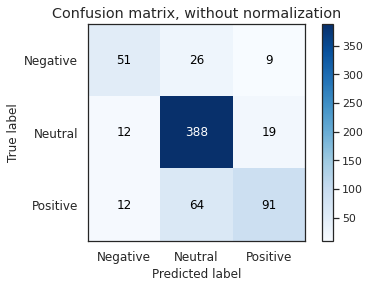

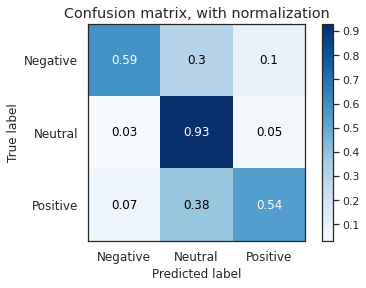

Starting epoch 23
Epoch: 23/30 Step: 10... Loss: 0.189272 Val Loss: 0.675101 Accuracy: 0.787202 F1 Score: 0.708573
Epoch: 23/30 Step: 20... Loss: 0.377181 Val Loss: 0.793756 Accuracy: 0.758929 F1 Score: 0.705661
Epoch: 23/30 Step: 30... Loss: 0.451810 Val Loss: 0.715827 Accuracy: 0.773810 F1 Score: 0.664971
Epoch: 23/30 Step: 40... Loss: 0.169598 Val Loss: 0.668516 Accuracy: 0.773810 F1 Score: 0.706631
Epoch: 23/30 Step: 50... Loss: 0.331427 Val Loss: 0.662712 Accuracy: 0.778274 F1 Score: 0.704635
Epoch: 23/30 Step: 60... Loss: 0.115819 Val Loss: 0.688620 Accuracy: 0.785714 F1 Score: 0.694775
Epoch: 23/30 Step: 70... Loss: 0.204049 Val Loss: 0.853078 Accuracy: 0.754464 F1 Score: 0.670011
Epoch: 23/30 Step: 80... Loss: 0.404924 Val Loss: 0.644095 Accuracy: 0.788690 F1 Score: 0.715030
87 steps in epoch 23

Epoch: 23, Average Accuracy: 0.78869048, Average f1: 0.71503011



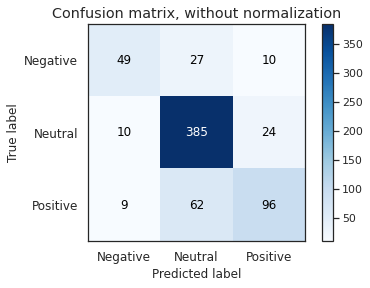

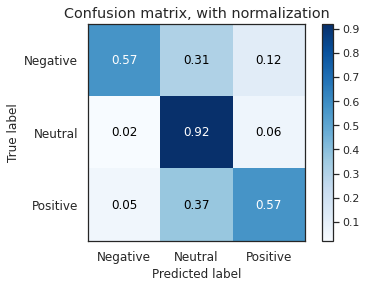

Starting epoch 24
Epoch: 24/30 Step: 10... Loss: 0.169524 Val Loss: 0.676622 Accuracy: 0.782738 F1 Score: 0.702827
Epoch: 24/30 Step: 20... Loss: 0.387182 Val Loss: 0.801738 Accuracy: 0.761905 F1 Score: 0.706603
Epoch: 24/30 Step: 30... Loss: 0.235004 Val Loss: 0.662820 Accuracy: 0.782738 F1 Score: 0.703612
Epoch: 24/30 Step: 40... Loss: 0.181266 Val Loss: 0.661623 Accuracy: 0.779762 F1 Score: 0.710823
Epoch: 24/30 Step: 50... Loss: 0.337212 Val Loss: 0.650351 Accuracy: 0.782738 F1 Score: 0.712476
Epoch: 24/30 Step: 60... Loss: 0.113515 Val Loss: 0.683967 Accuracy: 0.788690 F1 Score: 0.709194
Epoch: 24/30 Step: 70... Loss: 0.171693 Val Loss: 0.842671 Accuracy: 0.755952 F1 Score: 0.674998
Epoch: 24/30 Step: 80... Loss: 0.325323 Val Loss: 0.675109 Accuracy: 0.796131 F1 Score: 0.727612
87 steps in epoch 24

Epoch: 24, Average Accuracy: 0.79613095, Average f1: 0.72761180



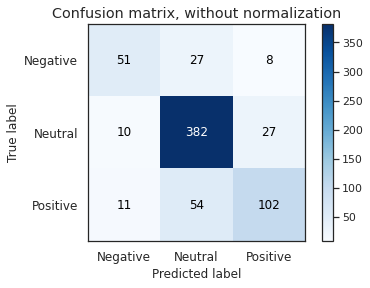

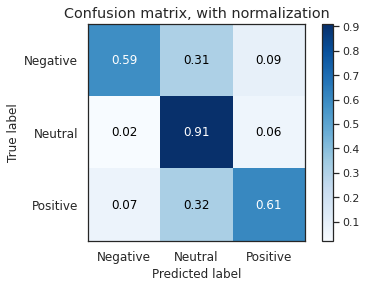

Starting epoch 25
Epoch: 25/30 Step: 10... Loss: 0.166432 Val Loss: 0.684549 Accuracy: 0.794643 F1 Score: 0.719760
Epoch: 25/30 Step: 20... Loss: 0.386164 Val Loss: 0.847438 Accuracy: 0.755952 F1 Score: 0.699043
Epoch: 25/30 Step: 30... Loss: 0.280516 Val Loss: 0.679273 Accuracy: 0.788690 F1 Score: 0.712958
Epoch: 25/30 Step: 40... Loss: 0.115175 Val Loss: 0.703922 Accuracy: 0.775298 F1 Score: 0.714710
Epoch: 25/30 Step: 50... Loss: 0.266150 Val Loss: 0.684518 Accuracy: 0.782738 F1 Score: 0.719038
Epoch: 25/30 Step: 60... Loss: 0.096959 Val Loss: 0.682572 Accuracy: 0.794643 F1 Score: 0.725411
Epoch: 25/30 Step: 70... Loss: 0.173279 Val Loss: 0.884479 Accuracy: 0.754464 F1 Score: 0.667973
Epoch: 25/30 Step: 80... Loss: 0.328087 Val Loss: 0.677357 Accuracy: 0.796131 F1 Score: 0.726608
87 steps in epoch 25

Epoch: 25, Average Accuracy: 0.79613095, Average f1: 0.72660843



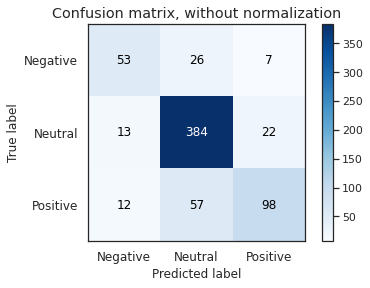

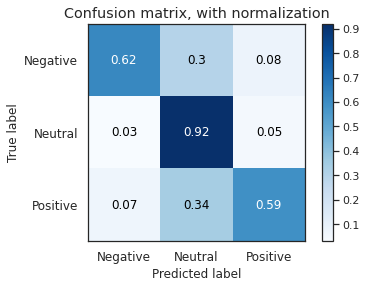

Starting epoch 26
Epoch: 26/30 Step: 10... Loss: 0.070296 Val Loss: 0.730520 Accuracy: 0.793155 F1 Score: 0.715058
Epoch: 26/30 Step: 20... Loss: 0.358229 Val Loss: 0.775862 Accuracy: 0.775298 F1 Score: 0.718963
Epoch: 26/30 Step: 30... Loss: 0.196410 Val Loss: 0.677066 Accuracy: 0.787202 F1 Score: 0.709459
Epoch: 26/30 Step: 40... Loss: 0.139865 Val Loss: 0.697371 Accuracy: 0.776786 F1 Score: 0.702818
Epoch: 26/30 Step: 50... Loss: 0.281969 Val Loss: 0.693392 Accuracy: 0.784226 F1 Score: 0.718341
Epoch: 26/30 Step: 60... Loss: 0.087404 Val Loss: 0.702965 Accuracy: 0.794643 F1 Score: 0.721861
Epoch: 26/30 Step: 70... Loss: 0.190046 Val Loss: 0.970801 Accuracy: 0.750000 F1 Score: 0.675371
Epoch: 26/30 Step: 80... Loss: 0.255889 Val Loss: 0.688148 Accuracy: 0.805060 F1 Score: 0.741516
87 steps in epoch 26

Epoch: 26, Average Accuracy: 0.80505952, Average f1: 0.74151647



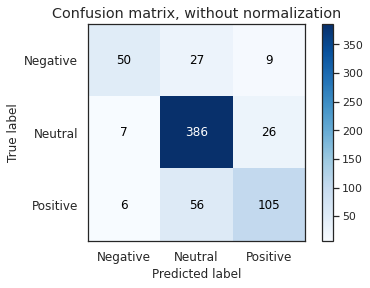

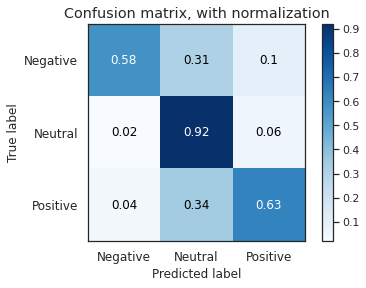

Starting epoch 27
Epoch: 27/30 Step: 10... Loss: 0.103940 Val Loss: 0.759985 Accuracy: 0.785714 F1 Score: 0.717915
Epoch: 27/30 Step: 20... Loss: 0.402631 Val Loss: 0.737378 Accuracy: 0.781250 F1 Score: 0.711104
Epoch: 27/30 Step: 30... Loss: 0.243682 Val Loss: 0.754853 Accuracy: 0.779762 F1 Score: 0.722535
Epoch: 27/30 Step: 40... Loss: 0.136202 Val Loss: 0.660947 Accuracy: 0.794643 F1 Score: 0.718285
Epoch: 27/30 Step: 50... Loss: 0.419579 Val Loss: 0.812769 Accuracy: 0.776786 F1 Score: 0.725338
Epoch: 27/30 Step: 60... Loss: 0.180913 Val Loss: 0.706036 Accuracy: 0.803571 F1 Score: 0.727090
Epoch: 27/30 Step: 70... Loss: 0.169320 Val Loss: 0.938644 Accuracy: 0.748512 F1 Score: 0.673211
Epoch: 27/30 Step: 80... Loss: 0.229904 Val Loss: 0.643482 Accuracy: 0.800595 F1 Score: 0.719475
87 steps in epoch 27

Epoch: 27, Average Accuracy: 0.80059524, Average f1: 0.71947539



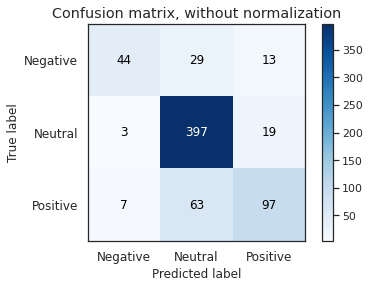

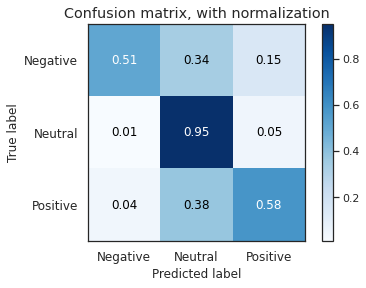

Starting epoch 28
Epoch: 28/30 Step: 10... Loss: 0.197838 Val Loss: 0.765982 Accuracy: 0.767857 F1 Score: 0.697527
Epoch: 28/30 Step: 20... Loss: 0.342416 Val Loss: 0.676220 Accuracy: 0.794643 F1 Score: 0.721688
Epoch: 28/30 Step: 30... Loss: 0.143476 Val Loss: 0.777491 Accuracy: 0.773810 F1 Score: 0.708401
Epoch: 28/30 Step: 40... Loss: 0.254665 Val Loss: 0.686727 Accuracy: 0.797619 F1 Score: 0.714420
Epoch: 28/30 Step: 50... Loss: 0.476516 Val Loss: 0.879148 Accuracy: 0.766369 F1 Score: 0.721527
Epoch: 28/30 Step: 60... Loss: 0.117544 Val Loss: 0.718235 Accuracy: 0.799107 F1 Score: 0.719824
Epoch: 28/30 Step: 70... Loss: 0.138588 Val Loss: 0.951703 Accuracy: 0.760417 F1 Score: 0.665104
Epoch: 28/30 Step: 80... Loss: 0.214221 Val Loss: 0.638717 Accuracy: 0.803571 F1 Score: 0.740915
87 steps in epoch 28

Epoch: 28, Average Accuracy: 0.80357143, Average f1: 0.74091547



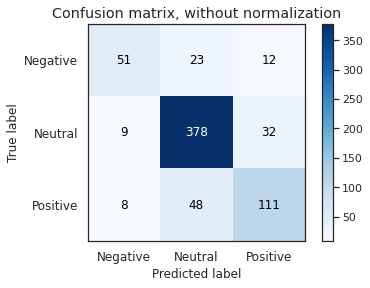

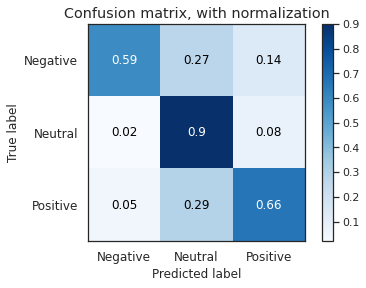

Starting epoch 29
Epoch: 29/30 Step: 10... Loss: 0.318643 Val Loss: 0.847782 Accuracy: 0.773810 F1 Score: 0.713143
Epoch: 29/30 Step: 20... Loss: 0.479478 Val Loss: 0.650583 Accuracy: 0.806548 F1 Score: 0.740967
Epoch: 29/30 Step: 30... Loss: 0.168969 Val Loss: 0.815995 Accuracy: 0.769345 F1 Score: 0.703224
Epoch: 29/30 Step: 40... Loss: 0.212939 Val Loss: 0.686162 Accuracy: 0.802083 F1 Score: 0.730007
Epoch: 29/30 Step: 50... Loss: 0.312591 Val Loss: 0.834771 Accuracy: 0.772321 F1 Score: 0.727844
Epoch: 29/30 Step: 60... Loss: 0.090639 Val Loss: 0.689718 Accuracy: 0.802083 F1 Score: 0.727022
Epoch: 29/30 Step: 70... Loss: 0.146571 Val Loss: 0.931228 Accuracy: 0.767857 F1 Score: 0.682727
Epoch: 29/30 Step: 80... Loss: 0.168702 Val Loss: 0.694241 Accuracy: 0.800595 F1 Score: 0.733809
87 steps in epoch 29

Epoch: 29, Average Accuracy: 0.80059524, Average f1: 0.73380948



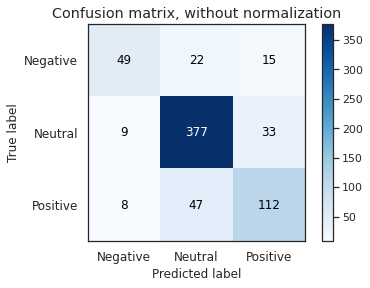

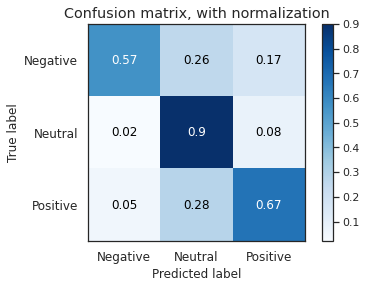

Starting epoch 30
Epoch: 30/30 Step: 10... Loss: 0.345577 Val Loss: 0.934897 Accuracy: 0.751488 F1 Score: 0.677055
Epoch: 30/30 Step: 20... Loss: 0.328312 Val Loss: 0.696209 Accuracy: 0.805060 F1 Score: 0.736973
Epoch: 30/30 Step: 30... Loss: 0.126779 Val Loss: 0.752744 Accuracy: 0.790179 F1 Score: 0.724599
Epoch: 30/30 Step: 40... Loss: 0.077518 Val Loss: 0.698108 Accuracy: 0.799107 F1 Score: 0.728780
Epoch: 30/30 Step: 50... Loss: 0.264576 Val Loss: 0.804070 Accuracy: 0.790179 F1 Score: 0.736314
Epoch: 30/30 Step: 60... Loss: 0.071538 Val Loss: 0.725391 Accuracy: 0.800595 F1 Score: 0.727614
Epoch: 30/30 Step: 70... Loss: 0.084220 Val Loss: 0.932188 Accuracy: 0.778274 F1 Score: 0.700336
Epoch: 30/30 Step: 80... Loss: 0.188243 Val Loss: 0.808179 Accuracy: 0.779762 F1 Score: 0.715431
87 steps in epoch 30

Epoch: 30, Average Accuracy: 0.77976190, Average f1: 0.71543150



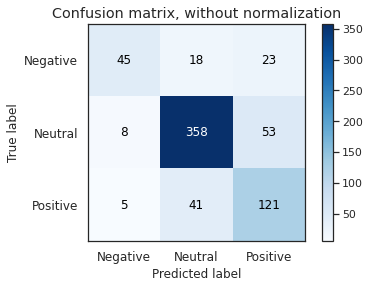

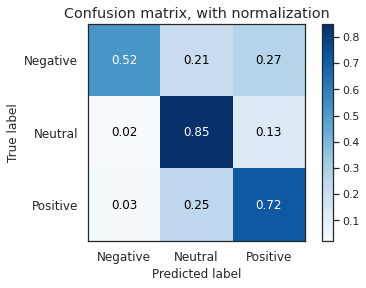

########## END ##########
Best Epoch: 26, Best F1: 0.74151647


In [99]:
best_acc, best_f1, best_epoch = train_model(model)

In [100]:
print("Accuracy: %.8f, F1: %.8f at Epoch: %d" % (best_acc, best_f1, best_epoch))

result_df.loc['D: LSTM+GloVe'] = (round(best_acc,4), round(best_f1,4))
result_df

Accuracy: 0.80505952, F1: 0.74151647 at Epoch: 26


Accuracy      F1
A: Lexicon      0.6522  0.4506
B: Tfidf        0.8145  0.7195
C: LSTM         0.8185  0.7657
D: LSTM+GloVe   0.8051  0.7415
E: BERT            NaN     NaN
F: ALBERT          NaN     NaN

# E. BERT Model

<table><tr><td><img src="./docs/bert_model.png" width=400></td><td><img src="./docs/transformer.png" width=550></td></tr></table>

![Comparison](./docs/bert-vs-openai-vs-elmo.png)

### Define functions

In [101]:
from torch.utils.data import DataLoader, TensorDataset
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_Bert, get_linear_schedule_with_warmup

In [102]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments
        }
        self.label = label

In [103]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=80):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

### Input Data

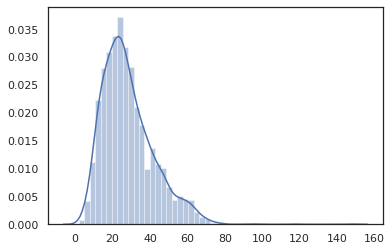

In [104]:
# Check the distribution to decide the maximum length
sns.distplot([len(tokenizer.tokenize(text)) for text in train_df['sentence']])

In [105]:
# Prepare training data
train_set = []
max_seq_length = 48

for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

train_labels = train_df['label'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

### Define Bert Model

In [106]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [107]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple



tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
(tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward>), tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2184e-02,  5.7299e-01,  6.2331e-02,  5.9587e-02, -9.9965e-01,
          5.0147e-02,  4.4756e-01,  9.7612e-01,  3.3988e-02,  8.4494e-01,
         -3.6905e-01,  9.8650e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,
          6.8965e-01, -6.1042e-01,  8.7136e-01,  9.4158e-01,  5.7372e-01,
  

In [108]:
# Test Tokenizer - Own Implementation
# bert_model = BertTextClassifier(768, 128, 3, dropout=0.1)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
pad_masks = torch.tensor(pad_masks).unsqueeze(0)
#print('pad_masks: ',pad_masks)
segment_ids = torch.tensor(segment_ids).unsqueeze(0)
#print('segment_ids: ',segment_ids)

#outputs = bert_model(text_ids)
outputs = bert_model(text_ids, pad_masks, segment_ids)

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

text_ids: 
 [101, 7592, 1010, 2026, 3899, 2003, 10140, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text_ids (torch.tensor): 
 tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
text_ids (unsqueezed): 
 tensor([[  101,  7592,  1010,  2026,  3899,  20

### Train

In [109]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 20
batch_size = 32
patience = 7
warm_up_proportion = 0.1
max_grad_norm = 1.0
file_name = 'model'
bert_hidden_size = 768
bert_dense_size = 128

In [110]:
def train_bert(fold, train_indices, valid_indices):
    
    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
    #bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, 3, dropout=0.1)
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)
    
    ## Set Loss Function
    ## If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    # loss_fn = torch.nn.CrossEntropyLoss()

    ## Set Optimizer
    ## Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    ## If we use torch.optim.Adam, set with parameter groups like this:
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    logger.info('Total Training Steps: {}'.format(num_total_opt_steps))
    optimizer = AdamW_Bert(bert_model.parameters(), lr=learning_rate, correct_bias=False) # To reproduce BertAdam specific behavior set correct_bias=False
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)

            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, y_truth = batch

            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = bert_model(x_ids, labels=y_truth)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        bert_model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, y_truth = batch
                loss, logits = bert_model(x_ids, labels=y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'finphrase_model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.5f, f1: %5f, best_f1: %.5f\n, last lr: %.6f' %
            (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        bert_model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'r-o')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'finphrase_model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, y_truth = batch
            loss, logits = bert_model(x_ids, labels=y_truth)
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()

    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in train_valid_labels[valid_indices]]
    predicted_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()

    return bert_model, acc, f1

[2020-09-20 09:14:16,741][INFO] ## ================     fold 0        ===============
[2020-09-20 09:14:16,741][INFO] ## ================     fold 0        ===============
[2020-09-20 09:14:16,741][INFO] ## ================     fold 0        ===============
[2020-09-20 09:14:16,741][INFO] ## ================     fold 0        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining mode

[2020-09-20 09:15:19,395][INFO] ## epoch: 1, train loss: 0.53933737, valid loss: 0.28053030, acc: 0.91886, f1: 0.899708, best_f1: 0.89971
, last lr: 0.000050
[2020-09-20 09:15:19,395][INFO] ## epoch: 1, train loss: 0.53933737, valid loss: 0.28053030, acc: 0.91886, f1: 0.899708, best_f1: 0.89971
, last lr: 0.000050
[2020-09-20 09:15:19,395][INFO] ## epoch: 1, train loss: 0.53933737, valid loss: 0.28053030, acc: 0.91886, f1: 0.899708, best_f1: 0.89971
, last lr: 0.000050
[2020-09-20 09:15:19,395][INFO] ## epoch: 1, train loss: 0.53933737, valid loss: 0.28053030, acc: 0.91886, f1: 0.899708, best_f1: 0.89971
, last lr: 0.000050
[2020-09-20 09:15:19,520][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:15:19,520][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:15:19,520][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:15:19,520][INFO] ## ================     epoch 2        ===============


[2020-09-20 09:16:13,935][INFO] ## epoch: 2, train loss: 0.32404838, valid loss: 0.43791432, acc: 0.89858, f1: 0.844733, best_f1: 0.89971
, last lr: 0.000100
[2020-09-20 09:16:13,935][INFO] ## epoch: 2, train loss: 0.32404838, valid loss: 0.43791432, acc: 0.89858, f1: 0.844733, best_f1: 0.89971
, last lr: 0.000100
[2020-09-20 09:16:13,935][INFO] ## epoch: 2, train loss: 0.32404838, valid loss: 0.43791432, acc: 0.89858, f1: 0.844733, best_f1: 0.89971
, last lr: 0.000100
[2020-09-20 09:16:13,935][INFO] ## epoch: 2, train loss: 0.32404838, valid loss: 0.43791432, acc: 0.89858, f1: 0.844733, best_f1: 0.89971
, last lr: 0.000100
[2020-09-20 09:16:14,066][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:16:14,066][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:16:14,066][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:16:14,066][INFO] ## ================     epoch 3        ===============


[2020-09-20 09:17:08,394][INFO] ## epoch: 3, train loss: 0.32348842, valid loss: 0.36954711, acc: 0.89452, f1: 0.850038, best_f1: 0.89971
, last lr: 0.000094
[2020-09-20 09:17:08,394][INFO] ## epoch: 3, train loss: 0.32348842, valid loss: 0.36954711, acc: 0.89452, f1: 0.850038, best_f1: 0.89971
, last lr: 0.000094
[2020-09-20 09:17:08,394][INFO] ## epoch: 3, train loss: 0.32348842, valid loss: 0.36954711, acc: 0.89452, f1: 0.850038, best_f1: 0.89971
, last lr: 0.000094
[2020-09-20 09:17:08,394][INFO] ## epoch: 3, train loss: 0.32348842, valid loss: 0.36954711, acc: 0.89452, f1: 0.850038, best_f1: 0.89971
, last lr: 0.000094
[2020-09-20 09:17:08,522][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:17:08,522][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:17:08,522][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:17:08,522][INFO] ## ================     epoch 4        ===============


[2020-09-20 09:18:02,883][INFO] ## epoch: 4, train loss: 0.22939543, valid loss: 0.45721750, acc: 0.89655, f1: 0.842276, best_f1: 0.89971
, last lr: 0.000089
[2020-09-20 09:18:02,883][INFO] ## epoch: 4, train loss: 0.22939543, valid loss: 0.45721750, acc: 0.89655, f1: 0.842276, best_f1: 0.89971
, last lr: 0.000089
[2020-09-20 09:18:02,883][INFO] ## epoch: 4, train loss: 0.22939543, valid loss: 0.45721750, acc: 0.89655, f1: 0.842276, best_f1: 0.89971
, last lr: 0.000089
[2020-09-20 09:18:02,883][INFO] ## epoch: 4, train loss: 0.22939543, valid loss: 0.45721750, acc: 0.89655, f1: 0.842276, best_f1: 0.89971
, last lr: 0.000089
[2020-09-20 09:18:03,013][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:18:03,013][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:18:03,013][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:18:03,013][INFO] ## ================     epoch 5        ===============


[2020-09-20 09:18:59,675][INFO] ## epoch: 5, train loss: 0.16815026, valid loss: 0.31022180, acc: 0.93306, f1: 0.910281, best_f1: 0.91028
, last lr: 0.000083
[2020-09-20 09:18:59,675][INFO] ## epoch: 5, train loss: 0.16815026, valid loss: 0.31022180, acc: 0.93306, f1: 0.910281, best_f1: 0.91028
, last lr: 0.000083
[2020-09-20 09:18:59,675][INFO] ## epoch: 5, train loss: 0.16815026, valid loss: 0.31022180, acc: 0.93306, f1: 0.910281, best_f1: 0.91028
, last lr: 0.000083
[2020-09-20 09:18:59,675][INFO] ## epoch: 5, train loss: 0.16815026, valid loss: 0.31022180, acc: 0.93306, f1: 0.910281, best_f1: 0.91028
, last lr: 0.000083
[2020-09-20 09:18:59,805][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:18:59,805][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:18:59,805][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:18:59,805][INFO] ## ================     epoch 6        ===============


[2020-09-20 09:19:54,012][INFO] ## epoch: 6, train loss: 0.12633500, valid loss: 0.33561574, acc: 0.93509, f1: 0.909998, best_f1: 0.91028
, last lr: 0.000078
[2020-09-20 09:19:54,012][INFO] ## epoch: 6, train loss: 0.12633500, valid loss: 0.33561574, acc: 0.93509, f1: 0.909998, best_f1: 0.91028
, last lr: 0.000078
[2020-09-20 09:19:54,012][INFO] ## epoch: 6, train loss: 0.12633500, valid loss: 0.33561574, acc: 0.93509, f1: 0.909998, best_f1: 0.91028
, last lr: 0.000078
[2020-09-20 09:19:54,012][INFO] ## epoch: 6, train loss: 0.12633500, valid loss: 0.33561574, acc: 0.93509, f1: 0.909998, best_f1: 0.91028
, last lr: 0.000078
[2020-09-20 09:19:54,147][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:19:54,147][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:19:54,147][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:19:54,147][INFO] ## ================     epoch 7        ===============


[2020-09-20 09:20:48,141][INFO] ## epoch: 7, train loss: 0.10153239, valid loss: 0.34444631, acc: 0.92089, f1: 0.882221, best_f1: 0.91028
, last lr: 0.000072
[2020-09-20 09:20:48,141][INFO] ## epoch: 7, train loss: 0.10153239, valid loss: 0.34444631, acc: 0.92089, f1: 0.882221, best_f1: 0.91028
, last lr: 0.000072
[2020-09-20 09:20:48,141][INFO] ## epoch: 7, train loss: 0.10153239, valid loss: 0.34444631, acc: 0.92089, f1: 0.882221, best_f1: 0.91028
, last lr: 0.000072
[2020-09-20 09:20:48,141][INFO] ## epoch: 7, train loss: 0.10153239, valid loss: 0.34444631, acc: 0.92089, f1: 0.882221, best_f1: 0.91028
, last lr: 0.000072
[2020-09-20 09:20:48,274][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:20:48,274][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:20:48,274][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:20:48,274][INFO] ## ================     epoch 8        ===============


[2020-09-20 09:21:44,796][INFO] ## epoch: 8, train loss: 0.09514311, valid loss: 0.27415083, acc: 0.94320, f1: 0.912163, best_f1: 0.91216
, last lr: 0.000067
[2020-09-20 09:21:44,796][INFO] ## epoch: 8, train loss: 0.09514311, valid loss: 0.27415083, acc: 0.94320, f1: 0.912163, best_f1: 0.91216
, last lr: 0.000067
[2020-09-20 09:21:44,796][INFO] ## epoch: 8, train loss: 0.09514311, valid loss: 0.27415083, acc: 0.94320, f1: 0.912163, best_f1: 0.91216
, last lr: 0.000067
[2020-09-20 09:21:44,796][INFO] ## epoch: 8, train loss: 0.09514311, valid loss: 0.27415083, acc: 0.94320, f1: 0.912163, best_f1: 0.91216
, last lr: 0.000067
[2020-09-20 09:21:44,929][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:21:44,929][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:21:44,929][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:21:44,929][INFO] ## ================     epoch 9        ===============


[2020-09-20 09:22:41,471][INFO] ## epoch: 9, train loss: 0.05507769, valid loss: 0.28872894, acc: 0.94523, f1: 0.920866, best_f1: 0.92087
, last lr: 0.000061
[2020-09-20 09:22:41,471][INFO] ## epoch: 9, train loss: 0.05507769, valid loss: 0.28872894, acc: 0.94523, f1: 0.920866, best_f1: 0.92087
, last lr: 0.000061
[2020-09-20 09:22:41,471][INFO] ## epoch: 9, train loss: 0.05507769, valid loss: 0.28872894, acc: 0.94523, f1: 0.920866, best_f1: 0.92087
, last lr: 0.000061
[2020-09-20 09:22:41,471][INFO] ## epoch: 9, train loss: 0.05507769, valid loss: 0.28872894, acc: 0.94523, f1: 0.920866, best_f1: 0.92087
, last lr: 0.000061
[2020-09-20 09:22:41,606][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:22:41,606][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:22:41,606][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:22:41,606][INFO] ## ================     epoch 10        ===============


[2020-09-20 09:23:35,451][INFO] ## epoch: 10, train loss: 0.04040627, valid loss: 0.41022571, acc: 0.93509, f1: 0.904688, best_f1: 0.92087
, last lr: 0.000056
[2020-09-20 09:23:35,451][INFO] ## epoch: 10, train loss: 0.04040627, valid loss: 0.41022571, acc: 0.93509, f1: 0.904688, best_f1: 0.92087
, last lr: 0.000056
[2020-09-20 09:23:35,451][INFO] ## epoch: 10, train loss: 0.04040627, valid loss: 0.41022571, acc: 0.93509, f1: 0.904688, best_f1: 0.92087
, last lr: 0.000056
[2020-09-20 09:23:35,451][INFO] ## epoch: 10, train loss: 0.04040627, valid loss: 0.41022571, acc: 0.93509, f1: 0.904688, best_f1: 0.92087
, last lr: 0.000056
[2020-09-20 09:23:35,576][INFO] ## ================     epoch 11        ===============
[2020-09-20 09:23:35,576][INFO] ## ================     epoch 11        ===============
[2020-09-20 09:23:35,576][INFO] ## ================     epoch 11        ===============
[2020-09-20 09:23:35,576][INFO] ## ================     epoch 11        ===============


[2020-09-20 09:24:29,327][INFO] ## epoch: 11, train loss: 0.03564401, valid loss: 0.44970101, acc: 0.93712, f1: 0.913877, best_f1: 0.92087
, last lr: 0.000050
[2020-09-20 09:24:29,327][INFO] ## epoch: 11, train loss: 0.03564401, valid loss: 0.44970101, acc: 0.93712, f1: 0.913877, best_f1: 0.92087
, last lr: 0.000050
[2020-09-20 09:24:29,327][INFO] ## epoch: 11, train loss: 0.03564401, valid loss: 0.44970101, acc: 0.93712, f1: 0.913877, best_f1: 0.92087
, last lr: 0.000050
[2020-09-20 09:24:29,327][INFO] ## epoch: 11, train loss: 0.03564401, valid loss: 0.44970101, acc: 0.93712, f1: 0.913877, best_f1: 0.92087
, last lr: 0.000050
[2020-09-20 09:24:29,457][INFO] ## ================     epoch 12        ===============
[2020-09-20 09:24:29,457][INFO] ## ================     epoch 12        ===============
[2020-09-20 09:24:29,457][INFO] ## ================     epoch 12        ===============
[2020-09-20 09:24:29,457][INFO] ## ================     epoch 12        ===============


[2020-09-20 09:25:23,235][INFO] ## epoch: 12, train loss: 0.04304386, valid loss: 0.31877396, acc: 0.93712, f1: 0.905093, best_f1: 0.92087
, last lr: 0.000044
[2020-09-20 09:25:23,235][INFO] ## epoch: 12, train loss: 0.04304386, valid loss: 0.31877396, acc: 0.93712, f1: 0.905093, best_f1: 0.92087
, last lr: 0.000044
[2020-09-20 09:25:23,235][INFO] ## epoch: 12, train loss: 0.04304386, valid loss: 0.31877396, acc: 0.93712, f1: 0.905093, best_f1: 0.92087
, last lr: 0.000044
[2020-09-20 09:25:23,235][INFO] ## epoch: 12, train loss: 0.04304386, valid loss: 0.31877396, acc: 0.93712, f1: 0.905093, best_f1: 0.92087
, last lr: 0.000044
[2020-09-20 09:25:23,375][INFO] ## ================     epoch 13        ===============
[2020-09-20 09:25:23,375][INFO] ## ================     epoch 13        ===============
[2020-09-20 09:25:23,375][INFO] ## ================     epoch 13        ===============
[2020-09-20 09:25:23,375][INFO] ## ================     epoch 13        ===============


[2020-09-20 09:26:17,117][INFO] ## epoch: 13, train loss: 0.02092284, valid loss: 0.37268707, acc: 0.94118, f1: 0.916423, best_f1: 0.92087
, last lr: 0.000039
[2020-09-20 09:26:17,117][INFO] ## epoch: 13, train loss: 0.02092284, valid loss: 0.37268707, acc: 0.94118, f1: 0.916423, best_f1: 0.92087
, last lr: 0.000039
[2020-09-20 09:26:17,117][INFO] ## epoch: 13, train loss: 0.02092284, valid loss: 0.37268707, acc: 0.94118, f1: 0.916423, best_f1: 0.92087
, last lr: 0.000039
[2020-09-20 09:26:17,117][INFO] ## epoch: 13, train loss: 0.02092284, valid loss: 0.37268707, acc: 0.94118, f1: 0.916423, best_f1: 0.92087
, last lr: 0.000039
[2020-09-20 09:26:17,252][INFO] ## ================     epoch 14        ===============
[2020-09-20 09:26:17,252][INFO] ## ================     epoch 14        ===============
[2020-09-20 09:26:17,252][INFO] ## ================     epoch 14        ===============
[2020-09-20 09:26:17,252][INFO] ## ================     epoch 14        ===============


[2020-09-20 09:27:13,536][INFO] ## epoch: 14, train loss: 0.01471687, valid loss: 0.33882286, acc: 0.94523, f1: 0.921158, best_f1: 0.92116
, last lr: 0.000033
[2020-09-20 09:27:13,536][INFO] ## epoch: 14, train loss: 0.01471687, valid loss: 0.33882286, acc: 0.94523, f1: 0.921158, best_f1: 0.92116
, last lr: 0.000033
[2020-09-20 09:27:13,536][INFO] ## epoch: 14, train loss: 0.01471687, valid loss: 0.33882286, acc: 0.94523, f1: 0.921158, best_f1: 0.92116
, last lr: 0.000033
[2020-09-20 09:27:13,536][INFO] ## epoch: 14, train loss: 0.01471687, valid loss: 0.33882286, acc: 0.94523, f1: 0.921158, best_f1: 0.92116
, last lr: 0.000033
[2020-09-20 09:27:13,694][INFO] ## ================     epoch 15        ===============
[2020-09-20 09:27:13,694][INFO] ## ================     epoch 15        ===============
[2020-09-20 09:27:13,694][INFO] ## ================     epoch 15        ===============
[2020-09-20 09:27:13,694][INFO] ## ================     epoch 15        ===============


[2020-09-20 09:28:10,542][INFO] ## epoch: 15, train loss: 0.01312715, valid loss: 0.38287777, acc: 0.94929, f1: 0.926665, best_f1: 0.92666
, last lr: 0.000028
[2020-09-20 09:28:10,542][INFO] ## epoch: 15, train loss: 0.01312715, valid loss: 0.38287777, acc: 0.94929, f1: 0.926665, best_f1: 0.92666
, last lr: 0.000028
[2020-09-20 09:28:10,542][INFO] ## epoch: 15, train loss: 0.01312715, valid loss: 0.38287777, acc: 0.94929, f1: 0.926665, best_f1: 0.92666
, last lr: 0.000028
[2020-09-20 09:28:10,542][INFO] ## epoch: 15, train loss: 0.01312715, valid loss: 0.38287777, acc: 0.94929, f1: 0.926665, best_f1: 0.92666
, last lr: 0.000028
[2020-09-20 09:28:10,708][INFO] ## ================     epoch 16        ===============
[2020-09-20 09:28:10,708][INFO] ## ================     epoch 16        ===============
[2020-09-20 09:28:10,708][INFO] ## ================     epoch 16        ===============
[2020-09-20 09:28:10,708][INFO] ## ================     epoch 16        ===============


[2020-09-20 09:29:04,453][INFO] ## epoch: 16, train loss: 0.00787185, valid loss: 0.43255488, acc: 0.93915, f1: 0.908797, best_f1: 0.92666
, last lr: 0.000022
[2020-09-20 09:29:04,453][INFO] ## epoch: 16, train loss: 0.00787185, valid loss: 0.43255488, acc: 0.93915, f1: 0.908797, best_f1: 0.92666
, last lr: 0.000022
[2020-09-20 09:29:04,453][INFO] ## epoch: 16, train loss: 0.00787185, valid loss: 0.43255488, acc: 0.93915, f1: 0.908797, best_f1: 0.92666
, last lr: 0.000022
[2020-09-20 09:29:04,453][INFO] ## epoch: 16, train loss: 0.00787185, valid loss: 0.43255488, acc: 0.93915, f1: 0.908797, best_f1: 0.92666
, last lr: 0.000022
[2020-09-20 09:29:04,583][INFO] ## ================     epoch 17        ===============
[2020-09-20 09:29:04,583][INFO] ## ================     epoch 17        ===============
[2020-09-20 09:29:04,583][INFO] ## ================     epoch 17        ===============
[2020-09-20 09:29:04,583][INFO] ## ================     epoch 17        ===============


[2020-09-20 09:29:58,273][INFO] ## epoch: 17, train loss: 0.00496864, valid loss: 0.45031837, acc: 0.94320, f1: 0.915129, best_f1: 0.92666
, last lr: 0.000017
[2020-09-20 09:29:58,273][INFO] ## epoch: 17, train loss: 0.00496864, valid loss: 0.45031837, acc: 0.94320, f1: 0.915129, best_f1: 0.92666
, last lr: 0.000017
[2020-09-20 09:29:58,273][INFO] ## epoch: 17, train loss: 0.00496864, valid loss: 0.45031837, acc: 0.94320, f1: 0.915129, best_f1: 0.92666
, last lr: 0.000017
[2020-09-20 09:29:58,273][INFO] ## epoch: 17, train loss: 0.00496864, valid loss: 0.45031837, acc: 0.94320, f1: 0.915129, best_f1: 0.92666
, last lr: 0.000017
[2020-09-20 09:29:58,399][INFO] ## ================     epoch 18        ===============
[2020-09-20 09:29:58,399][INFO] ## ================     epoch 18        ===============
[2020-09-20 09:29:58,399][INFO] ## ================     epoch 18        ===============
[2020-09-20 09:29:58,399][INFO] ## ================     epoch 18        ===============


[2020-09-20 09:30:51,978][INFO] ## epoch: 18, train loss: 0.00275982, valid loss: 0.44164442, acc: 0.93915, f1: 0.907515, best_f1: 0.92666
, last lr: 0.000011
[2020-09-20 09:30:51,978][INFO] ## epoch: 18, train loss: 0.00275982, valid loss: 0.44164442, acc: 0.93915, f1: 0.907515, best_f1: 0.92666
, last lr: 0.000011
[2020-09-20 09:30:51,978][INFO] ## epoch: 18, train loss: 0.00275982, valid loss: 0.44164442, acc: 0.93915, f1: 0.907515, best_f1: 0.92666
, last lr: 0.000011
[2020-09-20 09:30:51,978][INFO] ## epoch: 18, train loss: 0.00275982, valid loss: 0.44164442, acc: 0.93915, f1: 0.907515, best_f1: 0.92666
, last lr: 0.000011
[2020-09-20 09:30:52,108][INFO] ## ================     epoch 19        ===============
[2020-09-20 09:30:52,108][INFO] ## ================     epoch 19        ===============
[2020-09-20 09:30:52,108][INFO] ## ================     epoch 19        ===============
[2020-09-20 09:30:52,108][INFO] ## ================     epoch 19        ===============


[2020-09-20 09:31:45,727][INFO] ## epoch: 19, train loss: 0.00445524, valid loss: 0.46774699, acc: 0.94118, f1: 0.909281, best_f1: 0.92666
, last lr: 0.000006
[2020-09-20 09:31:45,727][INFO] ## epoch: 19, train loss: 0.00445524, valid loss: 0.46774699, acc: 0.94118, f1: 0.909281, best_f1: 0.92666
, last lr: 0.000006
[2020-09-20 09:31:45,727][INFO] ## epoch: 19, train loss: 0.00445524, valid loss: 0.46774699, acc: 0.94118, f1: 0.909281, best_f1: 0.92666
, last lr: 0.000006
[2020-09-20 09:31:45,727][INFO] ## epoch: 19, train loss: 0.00445524, valid loss: 0.46774699, acc: 0.94118, f1: 0.909281, best_f1: 0.92666
, last lr: 0.000006
[2020-09-20 09:31:45,856][INFO] ## ================     epoch 20        ===============
[2020-09-20 09:31:45,856][INFO] ## ================     epoch 20        ===============
[2020-09-20 09:31:45,856][INFO] ## ================     epoch 20        ===============
[2020-09-20 09:31:45,856][INFO] ## ================     epoch 20        ===============


[2020-09-20 09:32:39,452][INFO] ## epoch: 20, train loss: 0.00261905, valid loss: 0.47029699, acc: 0.94118, f1: 0.909281, best_f1: 0.92666
, last lr: 0.000000
[2020-09-20 09:32:39,452][INFO] ## epoch: 20, train loss: 0.00261905, valid loss: 0.47029699, acc: 0.94118, f1: 0.909281, best_f1: 0.92666
, last lr: 0.000000
[2020-09-20 09:32:39,452][INFO] ## epoch: 20, train loss: 0.00261905, valid loss: 0.47029699, acc: 0.94118, f1: 0.909281, best_f1: 0.92666
, last lr: 0.000000
[2020-09-20 09:32:39,452][INFO] ## epoch: 20, train loss: 0.00261905, valid loss: 0.47029699, acc: 0.94118, f1: 0.909281, best_f1: 0.92666
, last lr: 0.000000
No handles with labels found to put in legend.


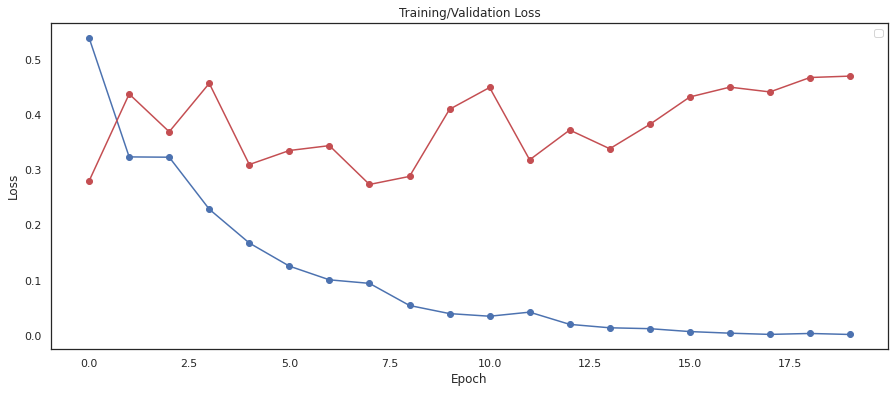

[2020-09-20 09:32:43,772][INFO] ## epoch: best, acc: 0.94929006, f1: 0.92666462, best_f1: 0.92666462

[2020-09-20 09:32:43,772][INFO] ## epoch: best, acc: 0.94929006, f1: 0.92666462, best_f1: 0.92666462

[2020-09-20 09:32:43,772][INFO] ## epoch: best, acc: 0.94929006, f1: 0.92666462, best_f1: 0.92666462

[2020-09-20 09:32:43,772][INFO] ## epoch: best, acc: 0.94929006, f1: 0.92666462, best_f1: 0.92666462



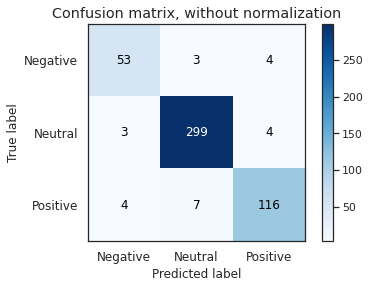

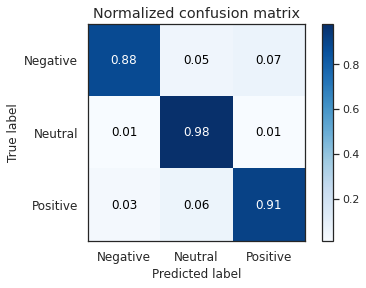

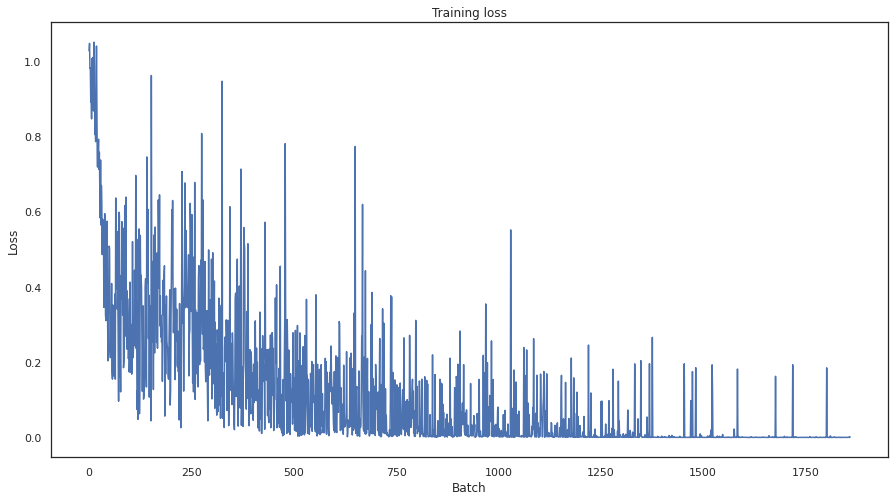

[2020-09-20 09:32:44,658][INFO] ## ================     fold 1        ===============
[2020-09-20 09:32:44,658][INFO] ## ================     fold 1        ===============
[2020-09-20 09:32:44,658][INFO] ## ================     fold 1        ===============
[2020-09-20 09:32:44,658][INFO] ## ================     fold 1        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining mode

[2020-09-20 09:33:47,638][INFO] ## epoch: 1, train loss: 0.60294969, valid loss: 0.34049974, acc: 0.89858, f1: 0.871312, best_f1: 0.87131
, last lr: 0.000050
[2020-09-20 09:33:47,638][INFO] ## epoch: 1, train loss: 0.60294969, valid loss: 0.34049974, acc: 0.89858, f1: 0.871312, best_f1: 0.87131
, last lr: 0.000050
[2020-09-20 09:33:47,638][INFO] ## epoch: 1, train loss: 0.60294969, valid loss: 0.34049974, acc: 0.89858, f1: 0.871312, best_f1: 0.87131
, last lr: 0.000050
[2020-09-20 09:33:47,638][INFO] ## epoch: 1, train loss: 0.60294969, valid loss: 0.34049974, acc: 0.89858, f1: 0.871312, best_f1: 0.87131
, last lr: 0.000050
[2020-09-20 09:33:47,744][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:33:47,744][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:33:47,744][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:33:47,744][INFO] ## ================     epoch 2        ===============


[2020-09-20 09:34:42,137][INFO] ## epoch: 2, train loss: 0.32341117, valid loss: 0.35769267, acc: 0.85193, f1: 0.793172, best_f1: 0.87131
, last lr: 0.000100
[2020-09-20 09:34:42,137][INFO] ## epoch: 2, train loss: 0.32341117, valid loss: 0.35769267, acc: 0.85193, f1: 0.793172, best_f1: 0.87131
, last lr: 0.000100
[2020-09-20 09:34:42,137][INFO] ## epoch: 2, train loss: 0.32341117, valid loss: 0.35769267, acc: 0.85193, f1: 0.793172, best_f1: 0.87131
, last lr: 0.000100
[2020-09-20 09:34:42,137][INFO] ## epoch: 2, train loss: 0.32341117, valid loss: 0.35769267, acc: 0.85193, f1: 0.793172, best_f1: 0.87131
, last lr: 0.000100
[2020-09-20 09:34:42,256][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:34:42,256][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:34:42,256][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:34:42,256][INFO] ## ================     epoch 3        ===============


[2020-09-20 09:35:36,652][INFO] ## epoch: 3, train loss: 0.36025776, valid loss: 0.59252989, acc: 0.86410, f1: 0.821971, best_f1: 0.87131
, last lr: 0.000094
[2020-09-20 09:35:36,652][INFO] ## epoch: 3, train loss: 0.36025776, valid loss: 0.59252989, acc: 0.86410, f1: 0.821971, best_f1: 0.87131
, last lr: 0.000094
[2020-09-20 09:35:36,652][INFO] ## epoch: 3, train loss: 0.36025776, valid loss: 0.59252989, acc: 0.86410, f1: 0.821971, best_f1: 0.87131
, last lr: 0.000094
[2020-09-20 09:35:36,652][INFO] ## epoch: 3, train loss: 0.36025776, valid loss: 0.59252989, acc: 0.86410, f1: 0.821971, best_f1: 0.87131
, last lr: 0.000094
[2020-09-20 09:35:36,763][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:35:36,763][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:35:36,763][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:35:36,763][INFO] ## ================     epoch 4        ===============


[2020-09-20 09:36:31,078][INFO] ## epoch: 4, train loss: 0.31519271, valid loss: 0.47240234, acc: 0.85801, f1: 0.812113, best_f1: 0.87131
, last lr: 0.000089
[2020-09-20 09:36:31,078][INFO] ## epoch: 4, train loss: 0.31519271, valid loss: 0.47240234, acc: 0.85801, f1: 0.812113, best_f1: 0.87131
, last lr: 0.000089
[2020-09-20 09:36:31,078][INFO] ## epoch: 4, train loss: 0.31519271, valid loss: 0.47240234, acc: 0.85801, f1: 0.812113, best_f1: 0.87131
, last lr: 0.000089
[2020-09-20 09:36:31,078][INFO] ## epoch: 4, train loss: 0.31519271, valid loss: 0.47240234, acc: 0.85801, f1: 0.812113, best_f1: 0.87131
, last lr: 0.000089
[2020-09-20 09:36:31,196][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:36:31,196][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:36:31,196][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:36:31,196][INFO] ## ================     epoch 5        ===============


[2020-09-20 09:37:25,522][INFO] ## epoch: 5, train loss: 0.27863265, valid loss: 0.48274641, acc: 0.89655, f1: 0.849319, best_f1: 0.87131
, last lr: 0.000083
[2020-09-20 09:37:25,522][INFO] ## epoch: 5, train loss: 0.27863265, valid loss: 0.48274641, acc: 0.89655, f1: 0.849319, best_f1: 0.87131
, last lr: 0.000083
[2020-09-20 09:37:25,522][INFO] ## epoch: 5, train loss: 0.27863265, valid loss: 0.48274641, acc: 0.89655, f1: 0.849319, best_f1: 0.87131
, last lr: 0.000083
[2020-09-20 09:37:25,522][INFO] ## epoch: 5, train loss: 0.27863265, valid loss: 0.48274641, acc: 0.89655, f1: 0.849319, best_f1: 0.87131
, last lr: 0.000083
[2020-09-20 09:37:25,634][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:37:25,634][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:37:25,634][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:37:25,634][INFO] ## ================     epoch 6        ===============


[2020-09-20 09:38:19,889][INFO] ## epoch: 6, train loss: 0.23112503, valid loss: 0.65616343, acc: 0.78296, f1: 0.738698, best_f1: 0.87131
, last lr: 0.000078
[2020-09-20 09:38:19,889][INFO] ## epoch: 6, train loss: 0.23112503, valid loss: 0.65616343, acc: 0.78296, f1: 0.738698, best_f1: 0.87131
, last lr: 0.000078
[2020-09-20 09:38:19,889][INFO] ## epoch: 6, train loss: 0.23112503, valid loss: 0.65616343, acc: 0.78296, f1: 0.738698, best_f1: 0.87131
, last lr: 0.000078
[2020-09-20 09:38:19,889][INFO] ## epoch: 6, train loss: 0.23112503, valid loss: 0.65616343, acc: 0.78296, f1: 0.738698, best_f1: 0.87131
, last lr: 0.000078
[2020-09-20 09:38:20,010][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:38:20,010][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:38:20,010][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:38:20,010][INFO] ## ================     epoch 7        ===============


[2020-09-20 09:39:17,067][INFO] ## epoch: 7, train loss: 0.21148318, valid loss: 0.33362196, acc: 0.91075, f1: 0.876577, best_f1: 0.87658
, last lr: 0.000072
[2020-09-20 09:39:17,067][INFO] ## epoch: 7, train loss: 0.21148318, valid loss: 0.33362196, acc: 0.91075, f1: 0.876577, best_f1: 0.87658
, last lr: 0.000072
[2020-09-20 09:39:17,067][INFO] ## epoch: 7, train loss: 0.21148318, valid loss: 0.33362196, acc: 0.91075, f1: 0.876577, best_f1: 0.87658
, last lr: 0.000072
[2020-09-20 09:39:17,067][INFO] ## epoch: 7, train loss: 0.21148318, valid loss: 0.33362196, acc: 0.91075, f1: 0.876577, best_f1: 0.87658
, last lr: 0.000072
[2020-09-20 09:39:17,217][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:39:17,217][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:39:17,217][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:39:17,217][INFO] ## ================     epoch 8        ===============


[2020-09-20 09:40:11,364][INFO] ## epoch: 8, train loss: 0.14330315, valid loss: 0.48005801, acc: 0.88438, f1: 0.841501, best_f1: 0.87658
, last lr: 0.000067
[2020-09-20 09:40:11,364][INFO] ## epoch: 8, train loss: 0.14330315, valid loss: 0.48005801, acc: 0.88438, f1: 0.841501, best_f1: 0.87658
, last lr: 0.000067
[2020-09-20 09:40:11,364][INFO] ## epoch: 8, train loss: 0.14330315, valid loss: 0.48005801, acc: 0.88438, f1: 0.841501, best_f1: 0.87658
, last lr: 0.000067
[2020-09-20 09:40:11,364][INFO] ## epoch: 8, train loss: 0.14330315, valid loss: 0.48005801, acc: 0.88438, f1: 0.841501, best_f1: 0.87658
, last lr: 0.000067
[2020-09-20 09:40:11,474][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:40:11,474][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:40:11,474][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:40:11,474][INFO] ## ================     epoch 9        ===============


[2020-09-20 09:41:05,511][INFO] ## epoch: 9, train loss: 0.13107755, valid loss: 0.47866489, acc: 0.89655, f1: 0.860986, best_f1: 0.87658
, last lr: 0.000061
[2020-09-20 09:41:05,511][INFO] ## epoch: 9, train loss: 0.13107755, valid loss: 0.47866489, acc: 0.89655, f1: 0.860986, best_f1: 0.87658
, last lr: 0.000061
[2020-09-20 09:41:05,511][INFO] ## epoch: 9, train loss: 0.13107755, valid loss: 0.47866489, acc: 0.89655, f1: 0.860986, best_f1: 0.87658
, last lr: 0.000061
[2020-09-20 09:41:05,511][INFO] ## epoch: 9, train loss: 0.13107755, valid loss: 0.47866489, acc: 0.89655, f1: 0.860986, best_f1: 0.87658
, last lr: 0.000061
[2020-09-20 09:41:05,628][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:41:05,628][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:41:05,628][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:41:05,628][INFO] ## ================     epoch 10        ===============


[2020-09-20 09:42:02,288][INFO] ## epoch: 10, train loss: 0.10414767, valid loss: 0.42659679, acc: 0.91075, f1: 0.879183, best_f1: 0.87918
, last lr: 0.000056
[2020-09-20 09:42:02,288][INFO] ## epoch: 10, train loss: 0.10414767, valid loss: 0.42659679, acc: 0.91075, f1: 0.879183, best_f1: 0.87918
, last lr: 0.000056
[2020-09-20 09:42:02,288][INFO] ## epoch: 10, train loss: 0.10414767, valid loss: 0.42659679, acc: 0.91075, f1: 0.879183, best_f1: 0.87918
, last lr: 0.000056
[2020-09-20 09:42:02,288][INFO] ## epoch: 10, train loss: 0.10414767, valid loss: 0.42659679, acc: 0.91075, f1: 0.879183, best_f1: 0.87918
, last lr: 0.000056
[2020-09-20 09:42:02,436][INFO] ## ================     epoch 11        ===============
[2020-09-20 09:42:02,436][INFO] ## ================     epoch 11        ===============
[2020-09-20 09:42:02,436][INFO] ## ================     epoch 11        ===============
[2020-09-20 09:42:02,436][INFO] ## ================     epoch 11        ===============


[2020-09-20 09:42:56,264][INFO] ## epoch: 11, train loss: 0.08460716, valid loss: 0.47267582, acc: 0.90872, f1: 0.874395, best_f1: 0.87918
, last lr: 0.000050
[2020-09-20 09:42:56,264][INFO] ## epoch: 11, train loss: 0.08460716, valid loss: 0.47267582, acc: 0.90872, f1: 0.874395, best_f1: 0.87918
, last lr: 0.000050
[2020-09-20 09:42:56,264][INFO] ## epoch: 11, train loss: 0.08460716, valid loss: 0.47267582, acc: 0.90872, f1: 0.874395, best_f1: 0.87918
, last lr: 0.000050
[2020-09-20 09:42:56,264][INFO] ## epoch: 11, train loss: 0.08460716, valid loss: 0.47267582, acc: 0.90872, f1: 0.874395, best_f1: 0.87918
, last lr: 0.000050
[2020-09-20 09:42:56,375][INFO] ## ================     epoch 12        ===============
[2020-09-20 09:42:56,375][INFO] ## ================     epoch 12        ===============
[2020-09-20 09:42:56,375][INFO] ## ================     epoch 12        ===============
[2020-09-20 09:42:56,375][INFO] ## ================     epoch 12        ===============


[2020-09-20 09:43:52,824][INFO] ## epoch: 12, train loss: 0.07561377, valid loss: 0.50048118, acc: 0.90872, f1: 0.881360, best_f1: 0.88136
, last lr: 0.000044
[2020-09-20 09:43:52,824][INFO] ## epoch: 12, train loss: 0.07561377, valid loss: 0.50048118, acc: 0.90872, f1: 0.881360, best_f1: 0.88136
, last lr: 0.000044
[2020-09-20 09:43:52,824][INFO] ## epoch: 12, train loss: 0.07561377, valid loss: 0.50048118, acc: 0.90872, f1: 0.881360, best_f1: 0.88136
, last lr: 0.000044
[2020-09-20 09:43:52,824][INFO] ## epoch: 12, train loss: 0.07561377, valid loss: 0.50048118, acc: 0.90872, f1: 0.881360, best_f1: 0.88136
, last lr: 0.000044
[2020-09-20 09:43:52,940][INFO] ## ================     epoch 13        ===============
[2020-09-20 09:43:52,940][INFO] ## ================     epoch 13        ===============
[2020-09-20 09:43:52,940][INFO] ## ================     epoch 13        ===============
[2020-09-20 09:43:52,940][INFO] ## ================     epoch 13        ===============


[2020-09-20 09:44:46,737][INFO] ## epoch: 13, train loss: 0.04426928, valid loss: 0.50306567, acc: 0.90669, f1: 0.875684, best_f1: 0.88136
, last lr: 0.000039
[2020-09-20 09:44:46,737][INFO] ## epoch: 13, train loss: 0.04426928, valid loss: 0.50306567, acc: 0.90669, f1: 0.875684, best_f1: 0.88136
, last lr: 0.000039
[2020-09-20 09:44:46,737][INFO] ## epoch: 13, train loss: 0.04426928, valid loss: 0.50306567, acc: 0.90669, f1: 0.875684, best_f1: 0.88136
, last lr: 0.000039
[2020-09-20 09:44:46,737][INFO] ## epoch: 13, train loss: 0.04426928, valid loss: 0.50306567, acc: 0.90669, f1: 0.875684, best_f1: 0.88136
, last lr: 0.000039
[2020-09-20 09:44:46,848][INFO] ## ================     epoch 14        ===============
[2020-09-20 09:44:46,848][INFO] ## ================     epoch 14        ===============
[2020-09-20 09:44:46,848][INFO] ## ================     epoch 14        ===============
[2020-09-20 09:44:46,848][INFO] ## ================     epoch 14        ===============


[2020-09-20 09:45:43,179][INFO] ## epoch: 14, train loss: 0.04358156, valid loss: 0.54962227, acc: 0.91075, f1: 0.881419, best_f1: 0.88142
, last lr: 0.000033
[2020-09-20 09:45:43,179][INFO] ## epoch: 14, train loss: 0.04358156, valid loss: 0.54962227, acc: 0.91075, f1: 0.881419, best_f1: 0.88142
, last lr: 0.000033
[2020-09-20 09:45:43,179][INFO] ## epoch: 14, train loss: 0.04358156, valid loss: 0.54962227, acc: 0.91075, f1: 0.881419, best_f1: 0.88142
, last lr: 0.000033
[2020-09-20 09:45:43,179][INFO] ## epoch: 14, train loss: 0.04358156, valid loss: 0.54962227, acc: 0.91075, f1: 0.881419, best_f1: 0.88142
, last lr: 0.000033
[2020-09-20 09:45:43,289][INFO] ## ================     epoch 15        ===============
[2020-09-20 09:45:43,289][INFO] ## ================     epoch 15        ===============
[2020-09-20 09:45:43,289][INFO] ## ================     epoch 15        ===============
[2020-09-20 09:45:43,289][INFO] ## ================     epoch 15        ===============


[2020-09-20 09:46:39,816][INFO] ## epoch: 15, train loss: 0.02972927, valid loss: 0.50065594, acc: 0.91684, f1: 0.888275, best_f1: 0.88828
, last lr: 0.000028
[2020-09-20 09:46:39,816][INFO] ## epoch: 15, train loss: 0.02972927, valid loss: 0.50065594, acc: 0.91684, f1: 0.888275, best_f1: 0.88828
, last lr: 0.000028
[2020-09-20 09:46:39,816][INFO] ## epoch: 15, train loss: 0.02972927, valid loss: 0.50065594, acc: 0.91684, f1: 0.888275, best_f1: 0.88828
, last lr: 0.000028
[2020-09-20 09:46:39,816][INFO] ## epoch: 15, train loss: 0.02972927, valid loss: 0.50065594, acc: 0.91684, f1: 0.888275, best_f1: 0.88828
, last lr: 0.000028
[2020-09-20 09:46:39,969][INFO] ## ================     epoch 16        ===============
[2020-09-20 09:46:39,969][INFO] ## ================     epoch 16        ===============
[2020-09-20 09:46:39,969][INFO] ## ================     epoch 16        ===============
[2020-09-20 09:46:39,969][INFO] ## ================     epoch 16        ===============


[2020-09-20 09:47:33,934][INFO] ## epoch: 16, train loss: 0.02297111, valid loss: 0.53630339, acc: 0.91684, f1: 0.886817, best_f1: 0.88828
, last lr: 0.000022
[2020-09-20 09:47:33,934][INFO] ## epoch: 16, train loss: 0.02297111, valid loss: 0.53630339, acc: 0.91684, f1: 0.886817, best_f1: 0.88828
, last lr: 0.000022
[2020-09-20 09:47:33,934][INFO] ## epoch: 16, train loss: 0.02297111, valid loss: 0.53630339, acc: 0.91684, f1: 0.886817, best_f1: 0.88828
, last lr: 0.000022
[2020-09-20 09:47:33,934][INFO] ## epoch: 16, train loss: 0.02297111, valid loss: 0.53630339, acc: 0.91684, f1: 0.886817, best_f1: 0.88828
, last lr: 0.000022
[2020-09-20 09:47:34,049][INFO] ## ================     epoch 17        ===============
[2020-09-20 09:47:34,049][INFO] ## ================     epoch 17        ===============
[2020-09-20 09:47:34,049][INFO] ## ================     epoch 17        ===============
[2020-09-20 09:47:34,049][INFO] ## ================     epoch 17        ===============


[2020-09-20 09:48:27,746][INFO] ## epoch: 17, train loss: 0.02077665, valid loss: 0.57000290, acc: 0.90467, f1: 0.875256, best_f1: 0.88828
, last lr: 0.000017
[2020-09-20 09:48:27,746][INFO] ## epoch: 17, train loss: 0.02077665, valid loss: 0.57000290, acc: 0.90467, f1: 0.875256, best_f1: 0.88828
, last lr: 0.000017
[2020-09-20 09:48:27,746][INFO] ## epoch: 17, train loss: 0.02077665, valid loss: 0.57000290, acc: 0.90467, f1: 0.875256, best_f1: 0.88828
, last lr: 0.000017
[2020-09-20 09:48:27,746][INFO] ## epoch: 17, train loss: 0.02077665, valid loss: 0.57000290, acc: 0.90467, f1: 0.875256, best_f1: 0.88828
, last lr: 0.000017
[2020-09-20 09:48:27,857][INFO] ## ================     epoch 18        ===============
[2020-09-20 09:48:27,857][INFO] ## ================     epoch 18        ===============
[2020-09-20 09:48:27,857][INFO] ## ================     epoch 18        ===============
[2020-09-20 09:48:27,857][INFO] ## ================     epoch 18        ===============


[2020-09-20 09:49:21,525][INFO] ## epoch: 18, train loss: 0.01773506, valid loss: 0.56921508, acc: 0.91075, f1: 0.880392, best_f1: 0.88828
, last lr: 0.000011
[2020-09-20 09:49:21,525][INFO] ## epoch: 18, train loss: 0.01773506, valid loss: 0.56921508, acc: 0.91075, f1: 0.880392, best_f1: 0.88828
, last lr: 0.000011
[2020-09-20 09:49:21,525][INFO] ## epoch: 18, train loss: 0.01773506, valid loss: 0.56921508, acc: 0.91075, f1: 0.880392, best_f1: 0.88828
, last lr: 0.000011
[2020-09-20 09:49:21,525][INFO] ## epoch: 18, train loss: 0.01773506, valid loss: 0.56921508, acc: 0.91075, f1: 0.880392, best_f1: 0.88828
, last lr: 0.000011
[2020-09-20 09:49:21,636][INFO] ## ================     epoch 19        ===============
[2020-09-20 09:49:21,636][INFO] ## ================     epoch 19        ===============
[2020-09-20 09:49:21,636][INFO] ## ================     epoch 19        ===============
[2020-09-20 09:49:21,636][INFO] ## ================     epoch 19        ===============


[2020-09-20 09:50:15,325][INFO] ## epoch: 19, train loss: 0.01703926, valid loss: 0.58180386, acc: 0.90669, f1: 0.873023, best_f1: 0.88828
, last lr: 0.000006
[2020-09-20 09:50:15,325][INFO] ## epoch: 19, train loss: 0.01703926, valid loss: 0.58180386, acc: 0.90669, f1: 0.873023, best_f1: 0.88828
, last lr: 0.000006
[2020-09-20 09:50:15,325][INFO] ## epoch: 19, train loss: 0.01703926, valid loss: 0.58180386, acc: 0.90669, f1: 0.873023, best_f1: 0.88828
, last lr: 0.000006
[2020-09-20 09:50:15,325][INFO] ## epoch: 19, train loss: 0.01703926, valid loss: 0.58180386, acc: 0.90669, f1: 0.873023, best_f1: 0.88828
, last lr: 0.000006
[2020-09-20 09:50:15,438][INFO] ## ================     epoch 20        ===============
[2020-09-20 09:50:15,438][INFO] ## ================     epoch 20        ===============
[2020-09-20 09:50:15,438][INFO] ## ================     epoch 20        ===============
[2020-09-20 09:50:15,438][INFO] ## ================     epoch 20        ===============


[2020-09-20 09:51:09,129][INFO] ## epoch: 20, train loss: 0.01404661, valid loss: 0.58472124, acc: 0.90872, f1: 0.874746, best_f1: 0.88828
, last lr: 0.000000
[2020-09-20 09:51:09,129][INFO] ## epoch: 20, train loss: 0.01404661, valid loss: 0.58472124, acc: 0.90872, f1: 0.874746, best_f1: 0.88828
, last lr: 0.000000
[2020-09-20 09:51:09,129][INFO] ## epoch: 20, train loss: 0.01404661, valid loss: 0.58472124, acc: 0.90872, f1: 0.874746, best_f1: 0.88828
, last lr: 0.000000
[2020-09-20 09:51:09,129][INFO] ## epoch: 20, train loss: 0.01404661, valid loss: 0.58472124, acc: 0.90872, f1: 0.874746, best_f1: 0.88828
, last lr: 0.000000
No handles with labels found to put in legend.


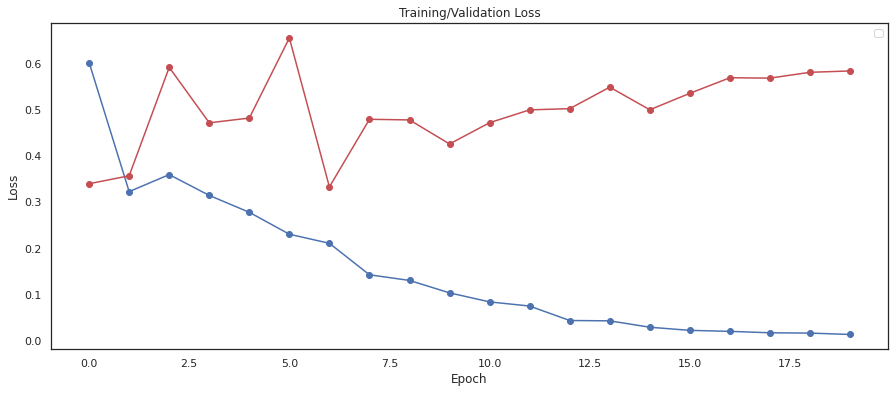

[2020-09-20 09:51:13,331][INFO] ## epoch: best, acc: 0.91683570, f1: 0.88827541, best_f1: 0.88827541

[2020-09-20 09:51:13,331][INFO] ## epoch: best, acc: 0.91683570, f1: 0.88827541, best_f1: 0.88827541

[2020-09-20 09:51:13,331][INFO] ## epoch: best, acc: 0.91683570, f1: 0.88827541, best_f1: 0.88827541

[2020-09-20 09:51:13,331][INFO] ## epoch: best, acc: 0.91683570, f1: 0.88827541, best_f1: 0.88827541



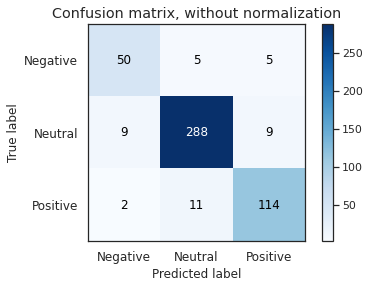

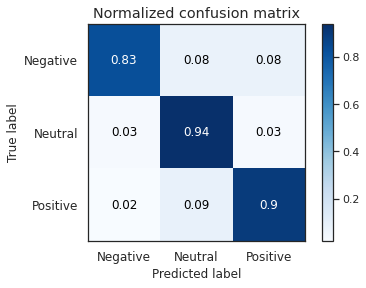

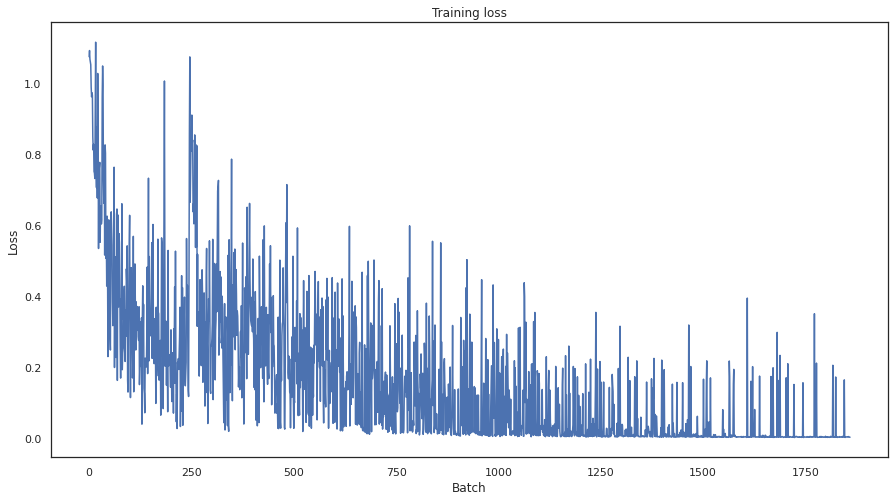

[2020-09-20 09:51:14,140][INFO] ## ================     fold 2        ===============
[2020-09-20 09:51:14,140][INFO] ## ================     fold 2        ===============
[2020-09-20 09:51:14,140][INFO] ## ================     fold 2        ===============
[2020-09-20 09:51:14,140][INFO] ## ================     fold 2        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining mode

[2020-09-20 09:52:23,915][INFO] ## epoch: 1, train loss: 0.66620987, valid loss: 0.39004320, acc: 0.87424, f1: 0.840526, best_f1: 0.84053
, last lr: 0.000050
[2020-09-20 09:52:23,915][INFO] ## epoch: 1, train loss: 0.66620987, valid loss: 0.39004320, acc: 0.87424, f1: 0.840526, best_f1: 0.84053
, last lr: 0.000050
[2020-09-20 09:52:23,915][INFO] ## epoch: 1, train loss: 0.66620987, valid loss: 0.39004320, acc: 0.87424, f1: 0.840526, best_f1: 0.84053
, last lr: 0.000050
[2020-09-20 09:52:23,915][INFO] ## epoch: 1, train loss: 0.66620987, valid loss: 0.39004320, acc: 0.87424, f1: 0.840526, best_f1: 0.84053
, last lr: 0.000050
[2020-09-20 09:52:24,075][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:52:24,075][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:52:24,075][INFO] ## ================     epoch 2        ===============
[2020-09-20 09:52:24,075][INFO] ## ================     epoch 2        ===============


[2020-09-20 09:53:18,459][INFO] ## epoch: 2, train loss: 0.31045376, valid loss: 0.46112566, acc: 0.85598, f1: 0.829092, best_f1: 0.84053
, last lr: 0.000100
[2020-09-20 09:53:18,459][INFO] ## epoch: 2, train loss: 0.31045376, valid loss: 0.46112566, acc: 0.85598, f1: 0.829092, best_f1: 0.84053
, last lr: 0.000100
[2020-09-20 09:53:18,459][INFO] ## epoch: 2, train loss: 0.31045376, valid loss: 0.46112566, acc: 0.85598, f1: 0.829092, best_f1: 0.84053
, last lr: 0.000100
[2020-09-20 09:53:18,459][INFO] ## epoch: 2, train loss: 0.31045376, valid loss: 0.46112566, acc: 0.85598, f1: 0.829092, best_f1: 0.84053
, last lr: 0.000100
[2020-09-20 09:53:18,585][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:53:18,585][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:53:18,585][INFO] ## ================     epoch 3        ===============
[2020-09-20 09:53:18,585][INFO] ## ================     epoch 3        ===============


[2020-09-20 09:54:13,026][INFO] ## epoch: 3, train loss: 0.26550777, valid loss: 0.59650900, acc: 0.83976, f1: 0.790505, best_f1: 0.84053
, last lr: 0.000094
[2020-09-20 09:54:13,026][INFO] ## epoch: 3, train loss: 0.26550777, valid loss: 0.59650900, acc: 0.83976, f1: 0.790505, best_f1: 0.84053
, last lr: 0.000094
[2020-09-20 09:54:13,026][INFO] ## epoch: 3, train loss: 0.26550777, valid loss: 0.59650900, acc: 0.83976, f1: 0.790505, best_f1: 0.84053
, last lr: 0.000094
[2020-09-20 09:54:13,026][INFO] ## epoch: 3, train loss: 0.26550777, valid loss: 0.59650900, acc: 0.83976, f1: 0.790505, best_f1: 0.84053
, last lr: 0.000094
[2020-09-20 09:54:13,157][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:54:13,157][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:54:13,157][INFO] ## ================     epoch 4        ===============
[2020-09-20 09:54:13,157][INFO] ## ================     epoch 4        ===============


[2020-09-20 09:55:07,486][INFO] ## epoch: 4, train loss: 0.19584895, valid loss: 0.58218628, acc: 0.87830, f1: 0.831917, best_f1: 0.84053
, last lr: 0.000089
[2020-09-20 09:55:07,486][INFO] ## epoch: 4, train loss: 0.19584895, valid loss: 0.58218628, acc: 0.87830, f1: 0.831917, best_f1: 0.84053
, last lr: 0.000089
[2020-09-20 09:55:07,486][INFO] ## epoch: 4, train loss: 0.19584895, valid loss: 0.58218628, acc: 0.87830, f1: 0.831917, best_f1: 0.84053
, last lr: 0.000089
[2020-09-20 09:55:07,486][INFO] ## epoch: 4, train loss: 0.19584895, valid loss: 0.58218628, acc: 0.87830, f1: 0.831917, best_f1: 0.84053
, last lr: 0.000089
[2020-09-20 09:55:07,625][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:55:07,625][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:55:07,625][INFO] ## ================     epoch 5        ===============
[2020-09-20 09:55:07,625][INFO] ## ================     epoch 5        ===============


[2020-09-20 09:56:04,270][INFO] ## epoch: 5, train loss: 0.15772247, valid loss: 0.44101000, acc: 0.89655, f1: 0.870222, best_f1: 0.87022
, last lr: 0.000083
[2020-09-20 09:56:04,270][INFO] ## epoch: 5, train loss: 0.15772247, valid loss: 0.44101000, acc: 0.89655, f1: 0.870222, best_f1: 0.87022
, last lr: 0.000083
[2020-09-20 09:56:04,270][INFO] ## epoch: 5, train loss: 0.15772247, valid loss: 0.44101000, acc: 0.89655, f1: 0.870222, best_f1: 0.87022
, last lr: 0.000083
[2020-09-20 09:56:04,270][INFO] ## epoch: 5, train loss: 0.15772247, valid loss: 0.44101000, acc: 0.89655, f1: 0.870222, best_f1: 0.87022
, last lr: 0.000083
[2020-09-20 09:56:04,416][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:56:04,416][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:56:04,416][INFO] ## ================     epoch 6        ===============
[2020-09-20 09:56:04,416][INFO] ## ================     epoch 6        ===============


[2020-09-20 09:56:58,764][INFO] ## epoch: 6, train loss: 0.12678814, valid loss: 0.54554647, acc: 0.87424, f1: 0.829796, best_f1: 0.87022
, last lr: 0.000078
[2020-09-20 09:56:58,764][INFO] ## epoch: 6, train loss: 0.12678814, valid loss: 0.54554647, acc: 0.87424, f1: 0.829796, best_f1: 0.87022
, last lr: 0.000078
[2020-09-20 09:56:58,764][INFO] ## epoch: 6, train loss: 0.12678814, valid loss: 0.54554647, acc: 0.87424, f1: 0.829796, best_f1: 0.87022
, last lr: 0.000078
[2020-09-20 09:56:58,764][INFO] ## epoch: 6, train loss: 0.12678814, valid loss: 0.54554647, acc: 0.87424, f1: 0.829796, best_f1: 0.87022
, last lr: 0.000078
[2020-09-20 09:56:58,900][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:56:58,900][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:56:58,900][INFO] ## ================     epoch 7        ===============
[2020-09-20 09:56:58,900][INFO] ## ================     epoch 7        ===============


[2020-09-20 09:57:52,986][INFO] ## epoch: 7, train loss: 0.08398169, valid loss: 0.83161959, acc: 0.84990, f1: 0.820272, best_f1: 0.87022
, last lr: 0.000072
[2020-09-20 09:57:52,986][INFO] ## epoch: 7, train loss: 0.08398169, valid loss: 0.83161959, acc: 0.84990, f1: 0.820272, best_f1: 0.87022
, last lr: 0.000072
[2020-09-20 09:57:52,986][INFO] ## epoch: 7, train loss: 0.08398169, valid loss: 0.83161959, acc: 0.84990, f1: 0.820272, best_f1: 0.87022
, last lr: 0.000072
[2020-09-20 09:57:52,986][INFO] ## epoch: 7, train loss: 0.08398169, valid loss: 0.83161959, acc: 0.84990, f1: 0.820272, best_f1: 0.87022
, last lr: 0.000072
[2020-09-20 09:57:53,129][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:57:53,129][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:57:53,129][INFO] ## ================     epoch 8        ===============
[2020-09-20 09:57:53,129][INFO] ## ================     epoch 8        ===============


[2020-09-20 09:58:47,243][INFO] ## epoch: 8, train loss: 0.05598880, valid loss: 0.75262539, acc: 0.87627, f1: 0.858612, best_f1: 0.87022
, last lr: 0.000067
[2020-09-20 09:58:47,243][INFO] ## epoch: 8, train loss: 0.05598880, valid loss: 0.75262539, acc: 0.87627, f1: 0.858612, best_f1: 0.87022
, last lr: 0.000067
[2020-09-20 09:58:47,243][INFO] ## epoch: 8, train loss: 0.05598880, valid loss: 0.75262539, acc: 0.87627, f1: 0.858612, best_f1: 0.87022
, last lr: 0.000067
[2020-09-20 09:58:47,243][INFO] ## epoch: 8, train loss: 0.05598880, valid loss: 0.75262539, acc: 0.87627, f1: 0.858612, best_f1: 0.87022
, last lr: 0.000067
[2020-09-20 09:58:47,384][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:58:47,384][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:58:47,384][INFO] ## ================     epoch 9        ===============
[2020-09-20 09:58:47,384][INFO] ## ================     epoch 9        ===============


[2020-09-20 09:59:43,745][INFO] ## epoch: 9, train loss: 0.04162227, valid loss: 0.70069870, acc: 0.89858, f1: 0.874125, best_f1: 0.87412
, last lr: 0.000061
[2020-09-20 09:59:43,745][INFO] ## epoch: 9, train loss: 0.04162227, valid loss: 0.70069870, acc: 0.89858, f1: 0.874125, best_f1: 0.87412
, last lr: 0.000061
[2020-09-20 09:59:43,745][INFO] ## epoch: 9, train loss: 0.04162227, valid loss: 0.70069870, acc: 0.89858, f1: 0.874125, best_f1: 0.87412
, last lr: 0.000061
[2020-09-20 09:59:43,745][INFO] ## epoch: 9, train loss: 0.04162227, valid loss: 0.70069870, acc: 0.89858, f1: 0.874125, best_f1: 0.87412
, last lr: 0.000061
[2020-09-20 09:59:43,876][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:59:43,876][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:59:43,876][INFO] ## ================     epoch 10        ===============
[2020-09-20 09:59:43,876][INFO] ## ================     epoch 10        ===============


[2020-09-20 10:00:41,067][INFO] ## epoch: 10, train loss: 0.02293342, valid loss: 0.65257108, acc: 0.90264, f1: 0.878990, best_f1: 0.87899
, last lr: 0.000056
[2020-09-20 10:00:41,067][INFO] ## epoch: 10, train loss: 0.02293342, valid loss: 0.65257108, acc: 0.90264, f1: 0.878990, best_f1: 0.87899
, last lr: 0.000056
[2020-09-20 10:00:41,067][INFO] ## epoch: 10, train loss: 0.02293342, valid loss: 0.65257108, acc: 0.90264, f1: 0.878990, best_f1: 0.87899
, last lr: 0.000056
[2020-09-20 10:00:41,067][INFO] ## epoch: 10, train loss: 0.02293342, valid loss: 0.65257108, acc: 0.90264, f1: 0.878990, best_f1: 0.87899
, last lr: 0.000056
[2020-09-20 10:00:41,219][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:00:41,219][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:00:41,219][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:00:41,219][INFO] ## ================     epoch 11        ===============


[2020-09-20 10:01:35,170][INFO] ## epoch: 11, train loss: 0.02197038, valid loss: 0.77429353, acc: 0.88844, f1: 0.858944, best_f1: 0.87899
, last lr: 0.000050
[2020-09-20 10:01:35,170][INFO] ## epoch: 11, train loss: 0.02197038, valid loss: 0.77429353, acc: 0.88844, f1: 0.858944, best_f1: 0.87899
, last lr: 0.000050
[2020-09-20 10:01:35,170][INFO] ## epoch: 11, train loss: 0.02197038, valid loss: 0.77429353, acc: 0.88844, f1: 0.858944, best_f1: 0.87899
, last lr: 0.000050
[2020-09-20 10:01:35,170][INFO] ## epoch: 11, train loss: 0.02197038, valid loss: 0.77429353, acc: 0.88844, f1: 0.858944, best_f1: 0.87899
, last lr: 0.000050
[2020-09-20 10:01:35,298][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:01:35,298][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:01:35,298][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:01:35,298][INFO] ## ================     epoch 12        ===============


[2020-09-20 10:02:29,079][INFO] ## epoch: 12, train loss: 0.01261154, valid loss: 0.75127899, acc: 0.88438, f1: 0.850242, best_f1: 0.87899
, last lr: 0.000044
[2020-09-20 10:02:29,079][INFO] ## epoch: 12, train loss: 0.01261154, valid loss: 0.75127899, acc: 0.88438, f1: 0.850242, best_f1: 0.87899
, last lr: 0.000044
[2020-09-20 10:02:29,079][INFO] ## epoch: 12, train loss: 0.01261154, valid loss: 0.75127899, acc: 0.88438, f1: 0.850242, best_f1: 0.87899
, last lr: 0.000044
[2020-09-20 10:02:29,079][INFO] ## epoch: 12, train loss: 0.01261154, valid loss: 0.75127899, acc: 0.88438, f1: 0.850242, best_f1: 0.87899
, last lr: 0.000044
[2020-09-20 10:02:29,214][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:02:29,214][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:02:29,214][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:02:29,214][INFO] ## ================     epoch 13        ===============


[2020-09-20 10:03:22,928][INFO] ## epoch: 13, train loss: 0.00419835, valid loss: 0.79121171, acc: 0.88844, f1: 0.855508, best_f1: 0.87899
, last lr: 0.000039
[2020-09-20 10:03:22,928][INFO] ## epoch: 13, train loss: 0.00419835, valid loss: 0.79121171, acc: 0.88844, f1: 0.855508, best_f1: 0.87899
, last lr: 0.000039
[2020-09-20 10:03:22,928][INFO] ## epoch: 13, train loss: 0.00419835, valid loss: 0.79121171, acc: 0.88844, f1: 0.855508, best_f1: 0.87899
, last lr: 0.000039
[2020-09-20 10:03:22,928][INFO] ## epoch: 13, train loss: 0.00419835, valid loss: 0.79121171, acc: 0.88844, f1: 0.855508, best_f1: 0.87899
, last lr: 0.000039
[2020-09-20 10:03:23,057][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:03:23,057][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:03:23,057][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:03:23,057][INFO] ## ================     epoch 14        ===============


[2020-09-20 10:04:16,725][INFO] ## epoch: 14, train loss: 0.00261649, valid loss: 0.79519084, acc: 0.89047, f1: 0.861981, best_f1: 0.87899
, last lr: 0.000033
[2020-09-20 10:04:16,725][INFO] ## epoch: 14, train loss: 0.00261649, valid loss: 0.79519084, acc: 0.89047, f1: 0.861981, best_f1: 0.87899
, last lr: 0.000033
[2020-09-20 10:04:16,725][INFO] ## epoch: 14, train loss: 0.00261649, valid loss: 0.79519084, acc: 0.89047, f1: 0.861981, best_f1: 0.87899
, last lr: 0.000033
[2020-09-20 10:04:16,725][INFO] ## epoch: 14, train loss: 0.00261649, valid loss: 0.79519084, acc: 0.89047, f1: 0.861981, best_f1: 0.87899
, last lr: 0.000033
[2020-09-20 10:04:16,855][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:04:16,855][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:04:16,855][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:04:16,855][INFO] ## ================     epoch 15        ===============


[2020-09-20 10:05:10,537][INFO] ## epoch: 15, train loss: 0.00255444, valid loss: 0.81799882, acc: 0.88844, f1: 0.858005, best_f1: 0.87899
, last lr: 0.000028
[2020-09-20 10:05:10,537][INFO] ## epoch: 15, train loss: 0.00255444, valid loss: 0.81799882, acc: 0.88844, f1: 0.858005, best_f1: 0.87899
, last lr: 0.000028
[2020-09-20 10:05:10,537][INFO] ## epoch: 15, train loss: 0.00255444, valid loss: 0.81799882, acc: 0.88844, f1: 0.858005, best_f1: 0.87899
, last lr: 0.000028
[2020-09-20 10:05:10,537][INFO] ## epoch: 15, train loss: 0.00255444, valid loss: 0.81799882, acc: 0.88844, f1: 0.858005, best_f1: 0.87899
, last lr: 0.000028
[2020-09-20 10:05:10,664][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:05:10,664][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:05:10,664][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:05:10,664][INFO] ## ================     epoch 16        ===============


[2020-09-20 10:06:04,330][INFO] ## epoch: 16, train loss: 0.00236619, valid loss: 0.78954042, acc: 0.89655, f1: 0.870634, best_f1: 0.87899
, last lr: 0.000022
[2020-09-20 10:06:04,330][INFO] ## epoch: 16, train loss: 0.00236619, valid loss: 0.78954042, acc: 0.89655, f1: 0.870634, best_f1: 0.87899
, last lr: 0.000022
[2020-09-20 10:06:04,330][INFO] ## epoch: 16, train loss: 0.00236619, valid loss: 0.78954042, acc: 0.89655, f1: 0.870634, best_f1: 0.87899
, last lr: 0.000022
[2020-09-20 10:06:04,330][INFO] ## epoch: 16, train loss: 0.00236619, valid loss: 0.78954042, acc: 0.89655, f1: 0.870634, best_f1: 0.87899
, last lr: 0.000022
[2020-09-20 10:06:04,460][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:06:04,460][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:06:04,460][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:06:04,460][INFO] ## ================     epoch 17        ===============


[2020-09-20 10:06:58,118][INFO] ## epoch: 17, train loss: 0.00237263, valid loss: 0.79865739, acc: 0.89655, f1: 0.873066, best_f1: 0.87899
, last lr: 0.000017
[2020-09-20 10:06:58,118][INFO] ## epoch: 17, train loss: 0.00237263, valid loss: 0.79865739, acc: 0.89655, f1: 0.873066, best_f1: 0.87899
, last lr: 0.000017
[2020-09-20 10:06:58,118][INFO] ## epoch: 17, train loss: 0.00237263, valid loss: 0.79865739, acc: 0.89655, f1: 0.873066, best_f1: 0.87899
, last lr: 0.000017
[2020-09-20 10:06:58,118][INFO] ## epoch: 17, train loss: 0.00237263, valid loss: 0.79865739, acc: 0.89655, f1: 0.873066, best_f1: 0.87899
, last lr: 0.000017
No handles with labels found to put in legend.


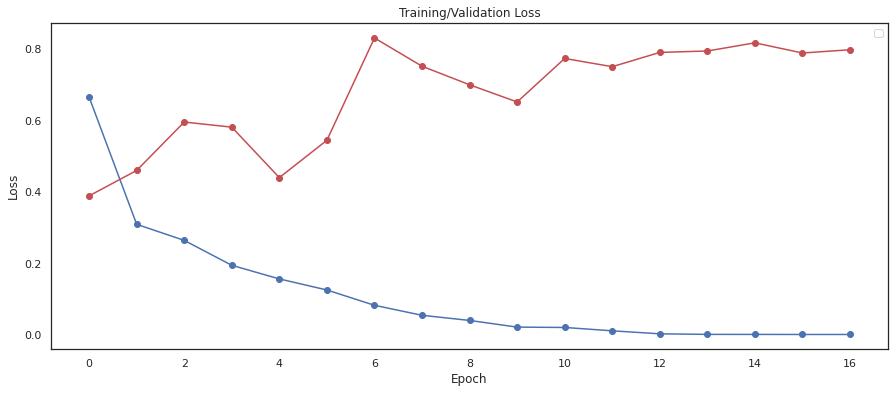

[2020-09-20 10:07:02,321][INFO] ## epoch: best, acc: 0.90263692, f1: 0.87899004, best_f1: 0.87899004

[2020-09-20 10:07:02,321][INFO] ## epoch: best, acc: 0.90263692, f1: 0.87899004, best_f1: 0.87899004

[2020-09-20 10:07:02,321][INFO] ## epoch: best, acc: 0.90263692, f1: 0.87899004, best_f1: 0.87899004

[2020-09-20 10:07:02,321][INFO] ## epoch: best, acc: 0.90263692, f1: 0.87899004, best_f1: 0.87899004



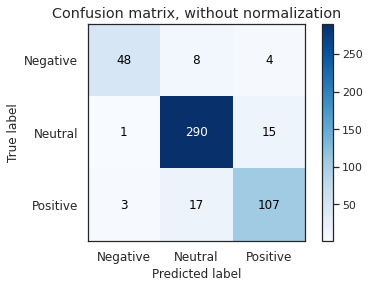

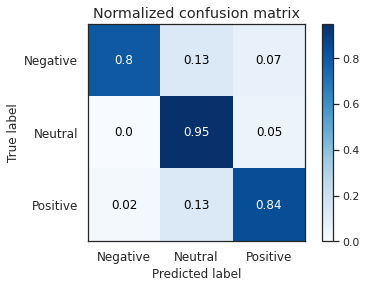

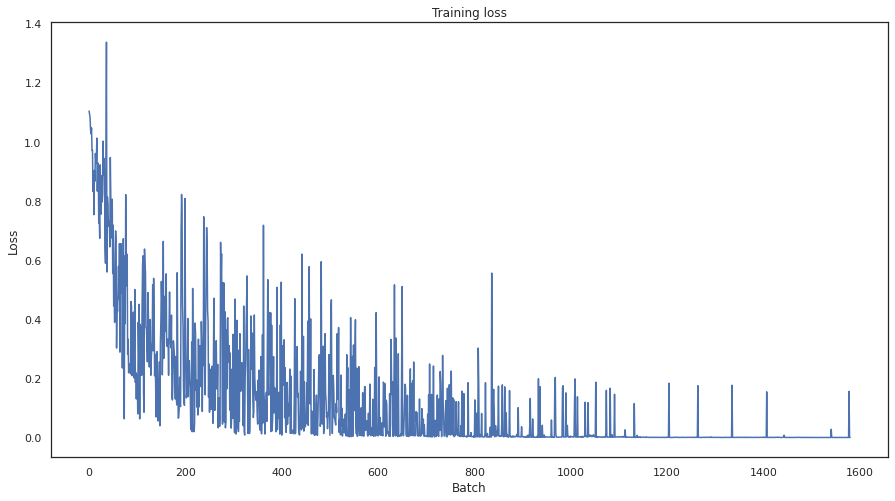

[2020-09-20 10:07:03,162][INFO] ## ================     fold 3        ===============
[2020-09-20 10:07:03,162][INFO] ## ================     fold 3        ===============
[2020-09-20 10:07:03,162][INFO] ## ================     fold 3        ===============
[2020-09-20 10:07:03,162][INFO] ## ================     fold 3        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining mode

[2020-09-20 10:08:11,566][INFO] ## epoch: 1, train loss: 0.57921508, valid loss: 0.25431798, acc: 0.92089, f1: 0.892912, best_f1: 0.89291
, last lr: 0.000050
[2020-09-20 10:08:11,566][INFO] ## epoch: 1, train loss: 0.57921508, valid loss: 0.25431798, acc: 0.92089, f1: 0.892912, best_f1: 0.89291
, last lr: 0.000050
[2020-09-20 10:08:11,566][INFO] ## epoch: 1, train loss: 0.57921508, valid loss: 0.25431798, acc: 0.92089, f1: 0.892912, best_f1: 0.89291
, last lr: 0.000050
[2020-09-20 10:08:11,566][INFO] ## epoch: 1, train loss: 0.57921508, valid loss: 0.25431798, acc: 0.92089, f1: 0.892912, best_f1: 0.89291
, last lr: 0.000050
[2020-09-20 10:08:11,689][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:08:11,689][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:08:11,689][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:08:11,689][INFO] ## ================     epoch 2        ===============


[2020-09-20 10:09:06,200][INFO] ## epoch: 2, train loss: 0.36200860, valid loss: 0.40164569, acc: 0.89249, f1: 0.861698, best_f1: 0.89291
, last lr: 0.000100
[2020-09-20 10:09:06,200][INFO] ## epoch: 2, train loss: 0.36200860, valid loss: 0.40164569, acc: 0.89249, f1: 0.861698, best_f1: 0.89291
, last lr: 0.000100
[2020-09-20 10:09:06,200][INFO] ## epoch: 2, train loss: 0.36200860, valid loss: 0.40164569, acc: 0.89249, f1: 0.861698, best_f1: 0.89291
, last lr: 0.000100
[2020-09-20 10:09:06,200][INFO] ## epoch: 2, train loss: 0.36200860, valid loss: 0.40164569, acc: 0.89249, f1: 0.861698, best_f1: 0.89291
, last lr: 0.000100
[2020-09-20 10:09:06,297][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:09:06,297][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:09:06,297][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:09:06,297][INFO] ## ================     epoch 3        ===============


[2020-09-20 10:10:00,725][INFO] ## epoch: 3, train loss: 0.32844967, valid loss: 0.37248449, acc: 0.89858, f1: 0.875746, best_f1: 0.89291
, last lr: 0.000094
[2020-09-20 10:10:00,725][INFO] ## epoch: 3, train loss: 0.32844967, valid loss: 0.37248449, acc: 0.89858, f1: 0.875746, best_f1: 0.89291
, last lr: 0.000094
[2020-09-20 10:10:00,725][INFO] ## epoch: 3, train loss: 0.32844967, valid loss: 0.37248449, acc: 0.89858, f1: 0.875746, best_f1: 0.89291
, last lr: 0.000094
[2020-09-20 10:10:00,725][INFO] ## epoch: 3, train loss: 0.32844967, valid loss: 0.37248449, acc: 0.89858, f1: 0.875746, best_f1: 0.89291
, last lr: 0.000094
[2020-09-20 10:10:00,831][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:10:00,831][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:10:00,831][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:10:00,831][INFO] ## ================     epoch 4        ===============


[2020-09-20 10:10:55,160][INFO] ## epoch: 4, train loss: 0.29046719, valid loss: 0.39332688, acc: 0.88844, f1: 0.865256, best_f1: 0.89291
, last lr: 0.000089
[2020-09-20 10:10:55,160][INFO] ## epoch: 4, train loss: 0.29046719, valid loss: 0.39332688, acc: 0.88844, f1: 0.865256, best_f1: 0.89291
, last lr: 0.000089
[2020-09-20 10:10:55,160][INFO] ## epoch: 4, train loss: 0.29046719, valid loss: 0.39332688, acc: 0.88844, f1: 0.865256, best_f1: 0.89291
, last lr: 0.000089
[2020-09-20 10:10:55,160][INFO] ## epoch: 4, train loss: 0.29046719, valid loss: 0.39332688, acc: 0.88844, f1: 0.865256, best_f1: 0.89291
, last lr: 0.000089
[2020-09-20 10:10:55,259][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:10:55,259][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:10:55,259][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:10:55,259][INFO] ## ================     epoch 5        ===============


[2020-09-20 10:11:49,668][INFO] ## epoch: 5, train loss: 0.20290449, valid loss: 0.31809687, acc: 0.92089, f1: 0.889673, best_f1: 0.89291
, last lr: 0.000083
[2020-09-20 10:11:49,668][INFO] ## epoch: 5, train loss: 0.20290449, valid loss: 0.31809687, acc: 0.92089, f1: 0.889673, best_f1: 0.89291
, last lr: 0.000083
[2020-09-20 10:11:49,668][INFO] ## epoch: 5, train loss: 0.20290449, valid loss: 0.31809687, acc: 0.92089, f1: 0.889673, best_f1: 0.89291
, last lr: 0.000083
[2020-09-20 10:11:49,668][INFO] ## epoch: 5, train loss: 0.20290449, valid loss: 0.31809687, acc: 0.92089, f1: 0.889673, best_f1: 0.89291
, last lr: 0.000083
[2020-09-20 10:11:49,776][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:11:49,776][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:11:49,776][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:11:49,776][INFO] ## ================     epoch 6        ===============


[2020-09-20 10:12:43,985][INFO] ## epoch: 6, train loss: 0.18174952, valid loss: 0.33239025, acc: 0.92089, f1: 0.886889, best_f1: 0.89291
, last lr: 0.000078
[2020-09-20 10:12:43,985][INFO] ## epoch: 6, train loss: 0.18174952, valid loss: 0.33239025, acc: 0.92089, f1: 0.886889, best_f1: 0.89291
, last lr: 0.000078
[2020-09-20 10:12:43,985][INFO] ## epoch: 6, train loss: 0.18174952, valid loss: 0.33239025, acc: 0.92089, f1: 0.886889, best_f1: 0.89291
, last lr: 0.000078
[2020-09-20 10:12:43,985][INFO] ## epoch: 6, train loss: 0.18174952, valid loss: 0.33239025, acc: 0.92089, f1: 0.886889, best_f1: 0.89291
, last lr: 0.000078
[2020-09-20 10:12:44,087][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:12:44,087][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:12:44,087][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:12:44,087][INFO] ## ================     epoch 7        ===============


[2020-09-20 10:13:38,194][INFO] ## epoch: 7, train loss: 0.14733106, valid loss: 0.35097131, acc: 0.92089, f1: 0.891389, best_f1: 0.89291
, last lr: 0.000072
[2020-09-20 10:13:38,194][INFO] ## epoch: 7, train loss: 0.14733106, valid loss: 0.35097131, acc: 0.92089, f1: 0.891389, best_f1: 0.89291
, last lr: 0.000072
[2020-09-20 10:13:38,194][INFO] ## epoch: 7, train loss: 0.14733106, valid loss: 0.35097131, acc: 0.92089, f1: 0.891389, best_f1: 0.89291
, last lr: 0.000072
[2020-09-20 10:13:38,194][INFO] ## epoch: 7, train loss: 0.14733106, valid loss: 0.35097131, acc: 0.92089, f1: 0.891389, best_f1: 0.89291
, last lr: 0.000072
[2020-09-20 10:13:38,291][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:13:38,291][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:13:38,291][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:13:38,291][INFO] ## ================     epoch 8        ===============


[2020-09-20 10:14:32,456][INFO] ## epoch: 8, train loss: 0.11870851, valid loss: 0.36762226, acc: 0.92495, f1: 0.891822, best_f1: 0.89291
, last lr: 0.000067
[2020-09-20 10:14:32,456][INFO] ## epoch: 8, train loss: 0.11870851, valid loss: 0.36762226, acc: 0.92495, f1: 0.891822, best_f1: 0.89291
, last lr: 0.000067
[2020-09-20 10:14:32,456][INFO] ## epoch: 8, train loss: 0.11870851, valid loss: 0.36762226, acc: 0.92495, f1: 0.891822, best_f1: 0.89291
, last lr: 0.000067
[2020-09-20 10:14:32,456][INFO] ## epoch: 8, train loss: 0.11870851, valid loss: 0.36762226, acc: 0.92495, f1: 0.891822, best_f1: 0.89291
, last lr: 0.000067
No handles with labels found to put in legend.


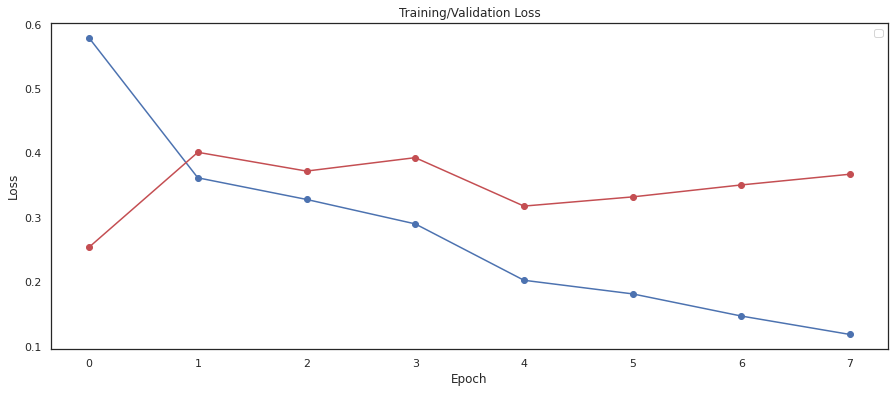

[2020-09-20 10:14:36,590][INFO] ## epoch: best, acc: 0.92089249, f1: 0.89291217, best_f1: 0.89291217

[2020-09-20 10:14:36,590][INFO] ## epoch: best, acc: 0.92089249, f1: 0.89291217, best_f1: 0.89291217

[2020-09-20 10:14:36,590][INFO] ## epoch: best, acc: 0.92089249, f1: 0.89291217, best_f1: 0.89291217

[2020-09-20 10:14:36,590][INFO] ## epoch: best, acc: 0.92089249, f1: 0.89291217, best_f1: 0.89291217



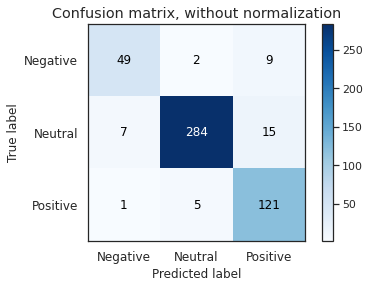

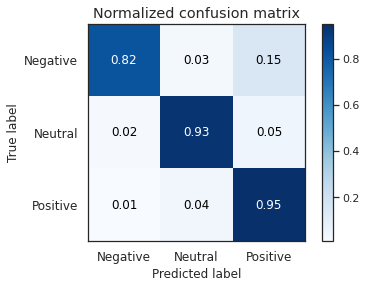

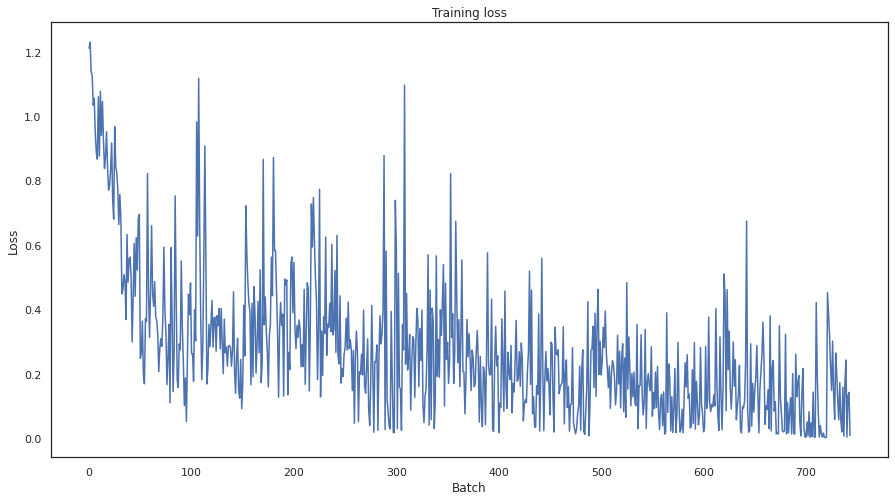

[2020-09-20 10:14:37,413][INFO] ## ================     fold 4        ===============
[2020-09-20 10:14:37,413][INFO] ## ================     fold 4        ===============
[2020-09-20 10:14:37,413][INFO] ## ================     fold 4        ===============
[2020-09-20 10:14:37,413][INFO] ## ================     fold 4        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining mode

[2020-09-20 10:15:39,859][INFO] ## epoch: 1, train loss: 0.57068041, valid loss: 0.32882777, acc: 0.88618, f1: 0.858331, best_f1: 0.85833
, last lr: 0.000050
[2020-09-20 10:15:39,859][INFO] ## epoch: 1, train loss: 0.57068041, valid loss: 0.32882777, acc: 0.88618, f1: 0.858331, best_f1: 0.85833
, last lr: 0.000050
[2020-09-20 10:15:39,859][INFO] ## epoch: 1, train loss: 0.57068041, valid loss: 0.32882777, acc: 0.88618, f1: 0.858331, best_f1: 0.85833
, last lr: 0.000050
[2020-09-20 10:15:39,859][INFO] ## epoch: 1, train loss: 0.57068041, valid loss: 0.32882777, acc: 0.88618, f1: 0.858331, best_f1: 0.85833
, last lr: 0.000050
[2020-09-20 10:15:39,969][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:15:39,969][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:15:39,969][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:15:39,969][INFO] ## ================     epoch 2        ===============


[2020-09-20 10:16:36,849][INFO] ## epoch: 2, train loss: 0.28331063, valid loss: 0.33019691, acc: 0.91260, f1: 0.879201, best_f1: 0.87920
, last lr: 0.000100
[2020-09-20 10:16:36,849][INFO] ## epoch: 2, train loss: 0.28331063, valid loss: 0.33019691, acc: 0.91260, f1: 0.879201, best_f1: 0.87920
, last lr: 0.000100
[2020-09-20 10:16:36,849][INFO] ## epoch: 2, train loss: 0.28331063, valid loss: 0.33019691, acc: 0.91260, f1: 0.879201, best_f1: 0.87920
, last lr: 0.000100
[2020-09-20 10:16:36,849][INFO] ## epoch: 2, train loss: 0.28331063, valid loss: 0.33019691, acc: 0.91260, f1: 0.879201, best_f1: 0.87920
, last lr: 0.000100
[2020-09-20 10:16:36,971][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:16:36,971][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:16:36,971][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:16:36,971][INFO] ## ================     epoch 3        ===============


[2020-09-20 10:17:31,459][INFO] ## epoch: 3, train loss: 0.24451032, valid loss: 0.36307443, acc: 0.88415, f1: 0.846386, best_f1: 0.87920
, last lr: 0.000094
[2020-09-20 10:17:31,459][INFO] ## epoch: 3, train loss: 0.24451032, valid loss: 0.36307443, acc: 0.88415, f1: 0.846386, best_f1: 0.87920
, last lr: 0.000094
[2020-09-20 10:17:31,459][INFO] ## epoch: 3, train loss: 0.24451032, valid loss: 0.36307443, acc: 0.88415, f1: 0.846386, best_f1: 0.87920
, last lr: 0.000094
[2020-09-20 10:17:31,459][INFO] ## epoch: 3, train loss: 0.24451032, valid loss: 0.36307443, acc: 0.88415, f1: 0.846386, best_f1: 0.87920
, last lr: 0.000094
[2020-09-20 10:17:31,572][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:17:31,572][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:17:31,572][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:17:31,572][INFO] ## ================     epoch 4        ===============


[2020-09-20 10:18:25,946][INFO] ## epoch: 4, train loss: 0.17880370, valid loss: 0.57741946, acc: 0.86179, f1: 0.825542, best_f1: 0.87920
, last lr: 0.000089
[2020-09-20 10:18:25,946][INFO] ## epoch: 4, train loss: 0.17880370, valid loss: 0.57741946, acc: 0.86179, f1: 0.825542, best_f1: 0.87920
, last lr: 0.000089
[2020-09-20 10:18:25,946][INFO] ## epoch: 4, train loss: 0.17880370, valid loss: 0.57741946, acc: 0.86179, f1: 0.825542, best_f1: 0.87920
, last lr: 0.000089
[2020-09-20 10:18:25,946][INFO] ## epoch: 4, train loss: 0.17880370, valid loss: 0.57741946, acc: 0.86179, f1: 0.825542, best_f1: 0.87920
, last lr: 0.000089
[2020-09-20 10:18:26,062][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:18:26,062][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:18:26,062][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:18:26,062][INFO] ## ================     epoch 5        ===============


[2020-09-20 10:19:20,292][INFO] ## epoch: 5, train loss: 0.12127237, valid loss: 0.49429501, acc: 0.89024, f1: 0.860934, best_f1: 0.87920
, last lr: 0.000083
[2020-09-20 10:19:20,292][INFO] ## epoch: 5, train loss: 0.12127237, valid loss: 0.49429501, acc: 0.89024, f1: 0.860934, best_f1: 0.87920
, last lr: 0.000083
[2020-09-20 10:19:20,292][INFO] ## epoch: 5, train loss: 0.12127237, valid loss: 0.49429501, acc: 0.89024, f1: 0.860934, best_f1: 0.87920
, last lr: 0.000083
[2020-09-20 10:19:20,292][INFO] ## epoch: 5, train loss: 0.12127237, valid loss: 0.49429501, acc: 0.89024, f1: 0.860934, best_f1: 0.87920
, last lr: 0.000083
[2020-09-20 10:19:20,406][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:19:20,406][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:19:20,406][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:19:20,406][INFO] ## ================     epoch 6        ===============


[2020-09-20 10:20:14,607][INFO] ## epoch: 6, train loss: 0.08986353, valid loss: 0.66414916, acc: 0.88618, f1: 0.852320, best_f1: 0.87920
, last lr: 0.000078
[2020-09-20 10:20:14,607][INFO] ## epoch: 6, train loss: 0.08986353, valid loss: 0.66414916, acc: 0.88618, f1: 0.852320, best_f1: 0.87920
, last lr: 0.000078
[2020-09-20 10:20:14,607][INFO] ## epoch: 6, train loss: 0.08986353, valid loss: 0.66414916, acc: 0.88618, f1: 0.852320, best_f1: 0.87920
, last lr: 0.000078
[2020-09-20 10:20:14,607][INFO] ## epoch: 6, train loss: 0.08986353, valid loss: 0.66414916, acc: 0.88618, f1: 0.852320, best_f1: 0.87920
, last lr: 0.000078
[2020-09-20 10:20:14,721][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:20:14,721][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:20:14,721][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:20:14,721][INFO] ## ================     epoch 7        ===============


[2020-09-20 10:21:08,879][INFO] ## epoch: 7, train loss: 0.06392498, valid loss: 0.52228783, acc: 0.89837, f1: 0.864657, best_f1: 0.87920
, last lr: 0.000072
[2020-09-20 10:21:08,879][INFO] ## epoch: 7, train loss: 0.06392498, valid loss: 0.52228783, acc: 0.89837, f1: 0.864657, best_f1: 0.87920
, last lr: 0.000072
[2020-09-20 10:21:08,879][INFO] ## epoch: 7, train loss: 0.06392498, valid loss: 0.52228783, acc: 0.89837, f1: 0.864657, best_f1: 0.87920
, last lr: 0.000072
[2020-09-20 10:21:08,879][INFO] ## epoch: 7, train loss: 0.06392498, valid loss: 0.52228783, acc: 0.89837, f1: 0.864657, best_f1: 0.87920
, last lr: 0.000072
[2020-09-20 10:21:08,996][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:21:08,996][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:21:08,996][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:21:08,996][INFO] ## ================     epoch 8        ===============


[2020-09-20 10:22:03,024][INFO] ## epoch: 8, train loss: 0.03889625, valid loss: 0.73454717, acc: 0.88008, f1: 0.857172, best_f1: 0.87920
, last lr: 0.000067
[2020-09-20 10:22:03,024][INFO] ## epoch: 8, train loss: 0.03889625, valid loss: 0.73454717, acc: 0.88008, f1: 0.857172, best_f1: 0.87920
, last lr: 0.000067
[2020-09-20 10:22:03,024][INFO] ## epoch: 8, train loss: 0.03889625, valid loss: 0.73454717, acc: 0.88008, f1: 0.857172, best_f1: 0.87920
, last lr: 0.000067
[2020-09-20 10:22:03,024][INFO] ## epoch: 8, train loss: 0.03889625, valid loss: 0.73454717, acc: 0.88008, f1: 0.857172, best_f1: 0.87920
, last lr: 0.000067
[2020-09-20 10:22:03,141][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:22:03,141][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:22:03,141][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:22:03,141][INFO] ## ================     epoch 9        ===============


[2020-09-20 10:22:57,133][INFO] ## epoch: 9, train loss: 0.02980910, valid loss: 0.69297173, acc: 0.89837, f1: 0.874138, best_f1: 0.87920
, last lr: 0.000061
[2020-09-20 10:22:57,133][INFO] ## epoch: 9, train loss: 0.02980910, valid loss: 0.69297173, acc: 0.89837, f1: 0.874138, best_f1: 0.87920
, last lr: 0.000061
[2020-09-20 10:22:57,133][INFO] ## epoch: 9, train loss: 0.02980910, valid loss: 0.69297173, acc: 0.89837, f1: 0.874138, best_f1: 0.87920
, last lr: 0.000061
[2020-09-20 10:22:57,133][INFO] ## epoch: 9, train loss: 0.02980910, valid loss: 0.69297173, acc: 0.89837, f1: 0.874138, best_f1: 0.87920
, last lr: 0.000061
No handles with labels found to put in legend.


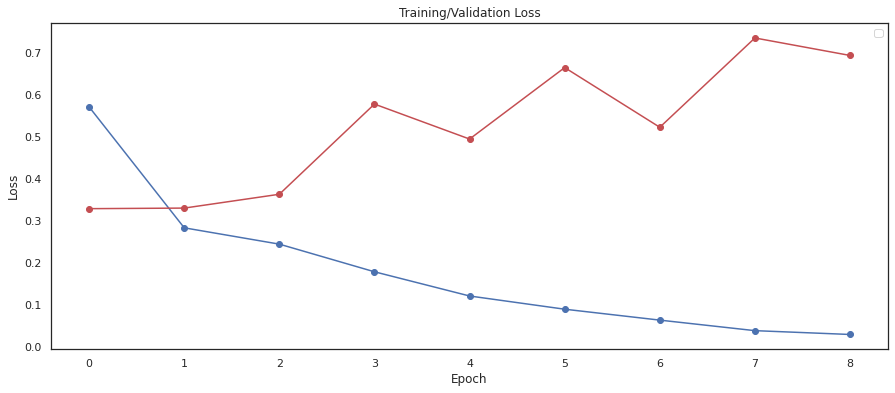

[2020-09-20 10:23:01,335][INFO] ## epoch: best, acc: 0.91260163, f1: 0.87920100, best_f1: 0.87920100

[2020-09-20 10:23:01,335][INFO] ## epoch: best, acc: 0.91260163, f1: 0.87920100, best_f1: 0.87920100

[2020-09-20 10:23:01,335][INFO] ## epoch: best, acc: 0.91260163, f1: 0.87920100, best_f1: 0.87920100

[2020-09-20 10:23:01,335][INFO] ## epoch: best, acc: 0.91260163, f1: 0.87920100, best_f1: 0.87920100



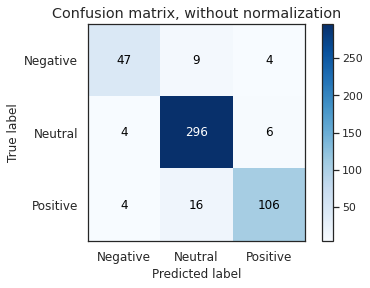

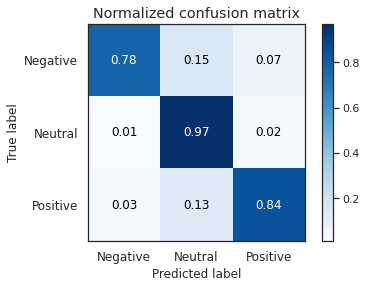

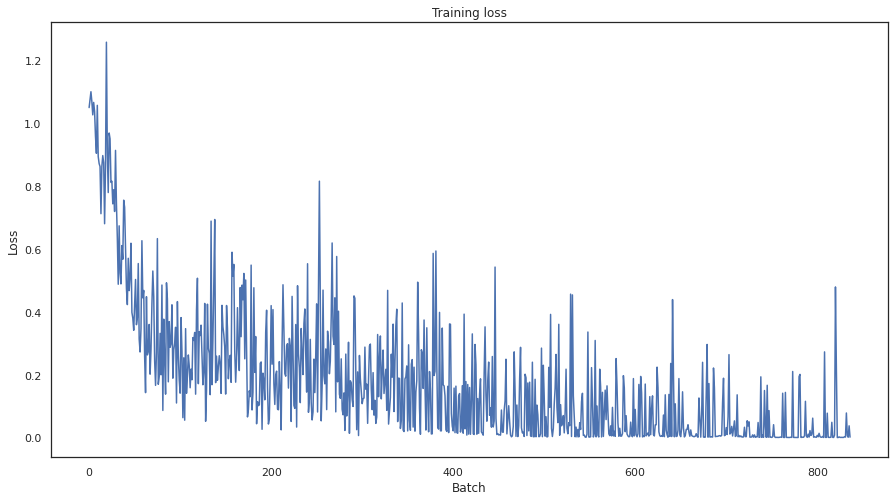

[2020-09-20 10:23:02,173][INFO] ## ================     fold 5        ===============
[2020-09-20 10:23:02,173][INFO] ## ================     fold 5        ===============
[2020-09-20 10:23:02,173][INFO] ## ================     fold 5        ===============
[2020-09-20 10:23:02,173][INFO] ## ================     fold 5        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining mode

[2020-09-20 10:24:04,796][INFO] ## epoch: 1, train loss: 0.56958965, valid loss: 0.48530008, acc: 0.81707, f1: 0.805060, best_f1: 0.80506
, last lr: 0.000050
[2020-09-20 10:24:04,796][INFO] ## epoch: 1, train loss: 0.56958965, valid loss: 0.48530008, acc: 0.81707, f1: 0.805060, best_f1: 0.80506
, last lr: 0.000050
[2020-09-20 10:24:04,796][INFO] ## epoch: 1, train loss: 0.56958965, valid loss: 0.48530008, acc: 0.81707, f1: 0.805060, best_f1: 0.80506
, last lr: 0.000050
[2020-09-20 10:24:04,796][INFO] ## epoch: 1, train loss: 0.56958965, valid loss: 0.48530008, acc: 0.81707, f1: 0.805060, best_f1: 0.80506
, last lr: 0.000050
[2020-09-20 10:24:04,911][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:24:04,911][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:24:04,911][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:24:04,911][INFO] ## ================     epoch 2        ===============


[2020-09-20 10:25:02,004][INFO] ## epoch: 2, train loss: 0.30216441, valid loss: 0.47600265, acc: 0.87805, f1: 0.839777, best_f1: 0.83978
, last lr: 0.000100
[2020-09-20 10:25:02,004][INFO] ## epoch: 2, train loss: 0.30216441, valid loss: 0.47600265, acc: 0.87805, f1: 0.839777, best_f1: 0.83978
, last lr: 0.000100
[2020-09-20 10:25:02,004][INFO] ## epoch: 2, train loss: 0.30216441, valid loss: 0.47600265, acc: 0.87805, f1: 0.839777, best_f1: 0.83978
, last lr: 0.000100
[2020-09-20 10:25:02,004][INFO] ## epoch: 2, train loss: 0.30216441, valid loss: 0.47600265, acc: 0.87805, f1: 0.839777, best_f1: 0.83978
, last lr: 0.000100
[2020-09-20 10:25:02,121][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:25:02,121][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:25:02,121][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:25:02,121][INFO] ## ================     epoch 3        ===============


[2020-09-20 10:25:59,336][INFO] ## epoch: 3, train loss: 0.26568433, valid loss: 0.41078479, acc: 0.88821, f1: 0.860486, best_f1: 0.86049
, last lr: 0.000094
[2020-09-20 10:25:59,336][INFO] ## epoch: 3, train loss: 0.26568433, valid loss: 0.41078479, acc: 0.88821, f1: 0.860486, best_f1: 0.86049
, last lr: 0.000094
[2020-09-20 10:25:59,336][INFO] ## epoch: 3, train loss: 0.26568433, valid loss: 0.41078479, acc: 0.88821, f1: 0.860486, best_f1: 0.86049
, last lr: 0.000094
[2020-09-20 10:25:59,336][INFO] ## epoch: 3, train loss: 0.26568433, valid loss: 0.41078479, acc: 0.88821, f1: 0.860486, best_f1: 0.86049
, last lr: 0.000094
[2020-09-20 10:25:59,467][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:25:59,467][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:25:59,467][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:25:59,467][INFO] ## ================     epoch 4        ===============


[2020-09-20 10:26:56,207][INFO] ## epoch: 4, train loss: 0.21317005, valid loss: 0.42615238, acc: 0.91057, f1: 0.877990, best_f1: 0.87799
, last lr: 0.000089
[2020-09-20 10:26:56,207][INFO] ## epoch: 4, train loss: 0.21317005, valid loss: 0.42615238, acc: 0.91057, f1: 0.877990, best_f1: 0.87799
, last lr: 0.000089
[2020-09-20 10:26:56,207][INFO] ## epoch: 4, train loss: 0.21317005, valid loss: 0.42615238, acc: 0.91057, f1: 0.877990, best_f1: 0.87799
, last lr: 0.000089
[2020-09-20 10:26:56,207][INFO] ## epoch: 4, train loss: 0.21317005, valid loss: 0.42615238, acc: 0.91057, f1: 0.877990, best_f1: 0.87799
, last lr: 0.000089
[2020-09-20 10:26:56,331][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:26:56,331][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:26:56,331][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:26:56,331][INFO] ## ================     epoch 5        ===============


[2020-09-20 10:27:50,638][INFO] ## epoch: 5, train loss: 0.16821979, valid loss: 0.39168762, acc: 0.90854, f1: 0.871468, best_f1: 0.87799
, last lr: 0.000083
[2020-09-20 10:27:50,638][INFO] ## epoch: 5, train loss: 0.16821979, valid loss: 0.39168762, acc: 0.90854, f1: 0.871468, best_f1: 0.87799
, last lr: 0.000083
[2020-09-20 10:27:50,638][INFO] ## epoch: 5, train loss: 0.16821979, valid loss: 0.39168762, acc: 0.90854, f1: 0.871468, best_f1: 0.87799
, last lr: 0.000083
[2020-09-20 10:27:50,638][INFO] ## epoch: 5, train loss: 0.16821979, valid loss: 0.39168762, acc: 0.90854, f1: 0.871468, best_f1: 0.87799
, last lr: 0.000083
[2020-09-20 10:27:50,752][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:27:50,752][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:27:50,752][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:27:50,752][INFO] ## ================     epoch 6        ===============


[2020-09-20 10:28:44,945][INFO] ## epoch: 6, train loss: 0.11829330, valid loss: 0.37015808, acc: 0.91260, f1: 0.874491, best_f1: 0.87799
, last lr: 0.000078
[2020-09-20 10:28:44,945][INFO] ## epoch: 6, train loss: 0.11829330, valid loss: 0.37015808, acc: 0.91260, f1: 0.874491, best_f1: 0.87799
, last lr: 0.000078
[2020-09-20 10:28:44,945][INFO] ## epoch: 6, train loss: 0.11829330, valid loss: 0.37015808, acc: 0.91260, f1: 0.874491, best_f1: 0.87799
, last lr: 0.000078
[2020-09-20 10:28:44,945][INFO] ## epoch: 6, train loss: 0.11829330, valid loss: 0.37015808, acc: 0.91260, f1: 0.874491, best_f1: 0.87799
, last lr: 0.000078
[2020-09-20 10:28:45,068][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:28:45,068][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:28:45,068][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:28:45,068][INFO] ## ================     epoch 7        ===============


[2020-09-20 10:29:39,230][INFO] ## epoch: 7, train loss: 0.11032416, valid loss: 0.51384820, acc: 0.89228, f1: 0.844224, best_f1: 0.87799
, last lr: 0.000072
[2020-09-20 10:29:39,230][INFO] ## epoch: 7, train loss: 0.11032416, valid loss: 0.51384820, acc: 0.89228, f1: 0.844224, best_f1: 0.87799
, last lr: 0.000072
[2020-09-20 10:29:39,230][INFO] ## epoch: 7, train loss: 0.11032416, valid loss: 0.51384820, acc: 0.89228, f1: 0.844224, best_f1: 0.87799
, last lr: 0.000072
[2020-09-20 10:29:39,230][INFO] ## epoch: 7, train loss: 0.11032416, valid loss: 0.51384820, acc: 0.89228, f1: 0.844224, best_f1: 0.87799
, last lr: 0.000072
[2020-09-20 10:29:39,343][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:29:39,343][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:29:39,343][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:29:39,343][INFO] ## ================     epoch 8        ===============


[2020-09-20 10:30:35,814][INFO] ## epoch: 8, train loss: 0.08128174, valid loss: 0.49606373, acc: 0.91463, f1: 0.891173, best_f1: 0.89117
, last lr: 0.000067
[2020-09-20 10:30:35,814][INFO] ## epoch: 8, train loss: 0.08128174, valid loss: 0.49606373, acc: 0.91463, f1: 0.891173, best_f1: 0.89117
, last lr: 0.000067
[2020-09-20 10:30:35,814][INFO] ## epoch: 8, train loss: 0.08128174, valid loss: 0.49606373, acc: 0.91463, f1: 0.891173, best_f1: 0.89117
, last lr: 0.000067
[2020-09-20 10:30:35,814][INFO] ## epoch: 8, train loss: 0.08128174, valid loss: 0.49606373, acc: 0.91463, f1: 0.891173, best_f1: 0.89117
, last lr: 0.000067
[2020-09-20 10:30:35,938][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:30:35,938][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:30:35,938][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:30:35,938][INFO] ## ================     epoch 9        ===============


[2020-09-20 10:31:29,981][INFO] ## epoch: 9, train loss: 0.06381345, valid loss: 0.59610118, acc: 0.89228, f1: 0.862654, best_f1: 0.89117
, last lr: 0.000061
[2020-09-20 10:31:29,981][INFO] ## epoch: 9, train loss: 0.06381345, valid loss: 0.59610118, acc: 0.89228, f1: 0.862654, best_f1: 0.89117
, last lr: 0.000061
[2020-09-20 10:31:29,981][INFO] ## epoch: 9, train loss: 0.06381345, valid loss: 0.59610118, acc: 0.89228, f1: 0.862654, best_f1: 0.89117
, last lr: 0.000061
[2020-09-20 10:31:29,981][INFO] ## epoch: 9, train loss: 0.06381345, valid loss: 0.59610118, acc: 0.89228, f1: 0.862654, best_f1: 0.89117
, last lr: 0.000061
[2020-09-20 10:31:30,097][INFO] ## ================     epoch 10        ===============
[2020-09-20 10:31:30,097][INFO] ## ================     epoch 10        ===============
[2020-09-20 10:31:30,097][INFO] ## ================     epoch 10        ===============
[2020-09-20 10:31:30,097][INFO] ## ================     epoch 10        ===============


[2020-09-20 10:32:24,199][INFO] ## epoch: 10, train loss: 0.06417501, valid loss: 0.49944829, acc: 0.91667, f1: 0.889961, best_f1: 0.89117
, last lr: 0.000056
[2020-09-20 10:32:24,199][INFO] ## epoch: 10, train loss: 0.06417501, valid loss: 0.49944829, acc: 0.91667, f1: 0.889961, best_f1: 0.89117
, last lr: 0.000056
[2020-09-20 10:32:24,199][INFO] ## epoch: 10, train loss: 0.06417501, valid loss: 0.49944829, acc: 0.91667, f1: 0.889961, best_f1: 0.89117
, last lr: 0.000056
[2020-09-20 10:32:24,199][INFO] ## epoch: 10, train loss: 0.06417501, valid loss: 0.49944829, acc: 0.91667, f1: 0.889961, best_f1: 0.89117
, last lr: 0.000056
[2020-09-20 10:32:24,312][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:32:24,312][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:32:24,312][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:32:24,312][INFO] ## ================     epoch 11        ===============


[2020-09-20 10:33:20,609][INFO] ## epoch: 11, train loss: 0.03494046, valid loss: 0.56651165, acc: 0.91667, f1: 0.893278, best_f1: 0.89328
, last lr: 0.000050
[2020-09-20 10:33:20,609][INFO] ## epoch: 11, train loss: 0.03494046, valid loss: 0.56651165, acc: 0.91667, f1: 0.893278, best_f1: 0.89328
, last lr: 0.000050
[2020-09-20 10:33:20,609][INFO] ## epoch: 11, train loss: 0.03494046, valid loss: 0.56651165, acc: 0.91667, f1: 0.893278, best_f1: 0.89328
, last lr: 0.000050
[2020-09-20 10:33:20,609][INFO] ## epoch: 11, train loss: 0.03494046, valid loss: 0.56651165, acc: 0.91667, f1: 0.893278, best_f1: 0.89328
, last lr: 0.000050
[2020-09-20 10:33:20,757][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:33:20,757][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:33:20,757][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:33:20,757][INFO] ## ================     epoch 12        ===============


[2020-09-20 10:34:17,178][INFO] ## epoch: 12, train loss: 0.02548151, valid loss: 0.54492686, acc: 0.92073, f1: 0.900216, best_f1: 0.90022
, last lr: 0.000044
[2020-09-20 10:34:17,178][INFO] ## epoch: 12, train loss: 0.02548151, valid loss: 0.54492686, acc: 0.92073, f1: 0.900216, best_f1: 0.90022
, last lr: 0.000044
[2020-09-20 10:34:17,178][INFO] ## epoch: 12, train loss: 0.02548151, valid loss: 0.54492686, acc: 0.92073, f1: 0.900216, best_f1: 0.90022
, last lr: 0.000044
[2020-09-20 10:34:17,178][INFO] ## epoch: 12, train loss: 0.02548151, valid loss: 0.54492686, acc: 0.92073, f1: 0.900216, best_f1: 0.90022
, last lr: 0.000044
[2020-09-20 10:34:17,300][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:34:17,300][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:34:17,300][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:34:17,300][INFO] ## ================     epoch 13        ===============


[2020-09-20 10:35:11,177][INFO] ## epoch: 13, train loss: 0.01638778, valid loss: 0.51555771, acc: 0.91870, f1: 0.891064, best_f1: 0.90022
, last lr: 0.000039
[2020-09-20 10:35:11,177][INFO] ## epoch: 13, train loss: 0.01638778, valid loss: 0.51555771, acc: 0.91870, f1: 0.891064, best_f1: 0.90022
, last lr: 0.000039
[2020-09-20 10:35:11,177][INFO] ## epoch: 13, train loss: 0.01638778, valid loss: 0.51555771, acc: 0.91870, f1: 0.891064, best_f1: 0.90022
, last lr: 0.000039
[2020-09-20 10:35:11,177][INFO] ## epoch: 13, train loss: 0.01638778, valid loss: 0.51555771, acc: 0.91870, f1: 0.891064, best_f1: 0.90022
, last lr: 0.000039
[2020-09-20 10:35:11,299][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:35:11,299][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:35:11,299][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:35:11,299][INFO] ## ================     epoch 14        ===============


[2020-09-20 10:36:05,164][INFO] ## epoch: 14, train loss: 0.00699673, valid loss: 0.62084003, acc: 0.91260, f1: 0.889933, best_f1: 0.90022
, last lr: 0.000033
[2020-09-20 10:36:05,164][INFO] ## epoch: 14, train loss: 0.00699673, valid loss: 0.62084003, acc: 0.91260, f1: 0.889933, best_f1: 0.90022
, last lr: 0.000033
[2020-09-20 10:36:05,164][INFO] ## epoch: 14, train loss: 0.00699673, valid loss: 0.62084003, acc: 0.91260, f1: 0.889933, best_f1: 0.90022
, last lr: 0.000033
[2020-09-20 10:36:05,164][INFO] ## epoch: 14, train loss: 0.00699673, valid loss: 0.62084003, acc: 0.91260, f1: 0.889933, best_f1: 0.90022
, last lr: 0.000033
[2020-09-20 10:36:05,284][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:36:05,284][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:36:05,284][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:36:05,284][INFO] ## ================     epoch 15        ===============


[2020-09-20 10:36:59,097][INFO] ## epoch: 15, train loss: 0.00673357, valid loss: 0.65711934, acc: 0.91260, f1: 0.889183, best_f1: 0.90022
, last lr: 0.000028
[2020-09-20 10:36:59,097][INFO] ## epoch: 15, train loss: 0.00673357, valid loss: 0.65711934, acc: 0.91260, f1: 0.889183, best_f1: 0.90022
, last lr: 0.000028
[2020-09-20 10:36:59,097][INFO] ## epoch: 15, train loss: 0.00673357, valid loss: 0.65711934, acc: 0.91260, f1: 0.889183, best_f1: 0.90022
, last lr: 0.000028
[2020-09-20 10:36:59,097][INFO] ## epoch: 15, train loss: 0.00673357, valid loss: 0.65711934, acc: 0.91260, f1: 0.889183, best_f1: 0.90022
, last lr: 0.000028
[2020-09-20 10:36:59,209][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:36:59,209][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:36:59,209][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:36:59,209][INFO] ## ================     epoch 16        ===============


[2020-09-20 10:37:55,360][INFO] ## epoch: 16, train loss: 0.00475527, valid loss: 0.66475507, acc: 0.92073, f1: 0.900371, best_f1: 0.90037
, last lr: 0.000022
[2020-09-20 10:37:55,360][INFO] ## epoch: 16, train loss: 0.00475527, valid loss: 0.66475507, acc: 0.92073, f1: 0.900371, best_f1: 0.90037
, last lr: 0.000022
[2020-09-20 10:37:55,360][INFO] ## epoch: 16, train loss: 0.00475527, valid loss: 0.66475507, acc: 0.92073, f1: 0.900371, best_f1: 0.90037
, last lr: 0.000022
[2020-09-20 10:37:55,360][INFO] ## epoch: 16, train loss: 0.00475527, valid loss: 0.66475507, acc: 0.92073, f1: 0.900371, best_f1: 0.90037
, last lr: 0.000022
[2020-09-20 10:37:55,479][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:37:55,479][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:37:55,479][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:37:55,479][INFO] ## ================     epoch 17        ===============


[2020-09-20 10:38:49,285][INFO] ## epoch: 17, train loss: 0.00115735, valid loss: 0.67978939, acc: 0.92073, f1: 0.899982, best_f1: 0.90037
, last lr: 0.000017
[2020-09-20 10:38:49,285][INFO] ## epoch: 17, train loss: 0.00115735, valid loss: 0.67978939, acc: 0.92073, f1: 0.899982, best_f1: 0.90037
, last lr: 0.000017
[2020-09-20 10:38:49,285][INFO] ## epoch: 17, train loss: 0.00115735, valid loss: 0.67978939, acc: 0.92073, f1: 0.899982, best_f1: 0.90037
, last lr: 0.000017
[2020-09-20 10:38:49,285][INFO] ## epoch: 17, train loss: 0.00115735, valid loss: 0.67978939, acc: 0.92073, f1: 0.899982, best_f1: 0.90037
, last lr: 0.000017
[2020-09-20 10:38:49,400][INFO] ## ================     epoch 18        ===============
[2020-09-20 10:38:49,400][INFO] ## ================     epoch 18        ===============
[2020-09-20 10:38:49,400][INFO] ## ================     epoch 18        ===============
[2020-09-20 10:38:49,400][INFO] ## ================     epoch 18        ===============


[2020-09-20 10:39:43,043][INFO] ## epoch: 18, train loss: 0.00027067, valid loss: 0.69047883, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000011
[2020-09-20 10:39:43,043][INFO] ## epoch: 18, train loss: 0.00027067, valid loss: 0.69047883, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000011
[2020-09-20 10:39:43,043][INFO] ## epoch: 18, train loss: 0.00027067, valid loss: 0.69047883, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000011
[2020-09-20 10:39:43,043][INFO] ## epoch: 18, train loss: 0.00027067, valid loss: 0.69047883, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000011
[2020-09-20 10:39:43,157][INFO] ## ================     epoch 19        ===============
[2020-09-20 10:39:43,157][INFO] ## ================     epoch 19        ===============
[2020-09-20 10:39:43,157][INFO] ## ================     epoch 19        ===============
[2020-09-20 10:39:43,157][INFO] ## ================     epoch 19        ===============


[2020-09-20 10:40:36,996][INFO] ## epoch: 19, train loss: 0.00024074, valid loss: 0.69151659, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000006
[2020-09-20 10:40:36,996][INFO] ## epoch: 19, train loss: 0.00024074, valid loss: 0.69151659, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000006
[2020-09-20 10:40:36,996][INFO] ## epoch: 19, train loss: 0.00024074, valid loss: 0.69151659, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000006
[2020-09-20 10:40:36,996][INFO] ## epoch: 19, train loss: 0.00024074, valid loss: 0.69151659, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000006
[2020-09-20 10:40:37,115][INFO] ## ================     epoch 20        ===============
[2020-09-20 10:40:37,115][INFO] ## ================     epoch 20        ===============
[2020-09-20 10:40:37,115][INFO] ## ================     epoch 20        ===============
[2020-09-20 10:40:37,115][INFO] ## ================     epoch 20        ===============


[2020-09-20 10:41:30,927][INFO] ## epoch: 20, train loss: 0.00050576, valid loss: 0.69169642, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000000
[2020-09-20 10:41:30,927][INFO] ## epoch: 20, train loss: 0.00050576, valid loss: 0.69169642, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000000
[2020-09-20 10:41:30,927][INFO] ## epoch: 20, train loss: 0.00050576, valid loss: 0.69169642, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000000
[2020-09-20 10:41:30,927][INFO] ## epoch: 20, train loss: 0.00050576, valid loss: 0.69169642, acc: 0.91870, f1: 0.898268, best_f1: 0.90037
, last lr: 0.000000
No handles with labels found to put in legend.


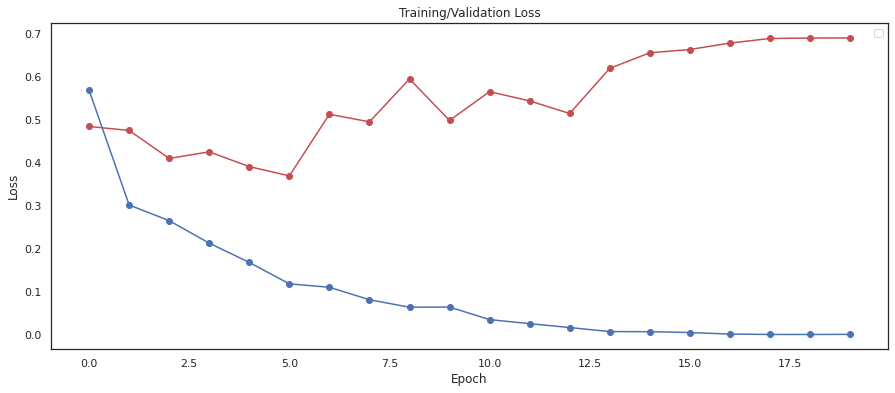

[2020-09-20 10:41:35,043][INFO] ## epoch: best, acc: 0.92073171, f1: 0.90037122, best_f1: 0.90037122

[2020-09-20 10:41:35,043][INFO] ## epoch: best, acc: 0.92073171, f1: 0.90037122, best_f1: 0.90037122

[2020-09-20 10:41:35,043][INFO] ## epoch: best, acc: 0.92073171, f1: 0.90037122, best_f1: 0.90037122

[2020-09-20 10:41:35,043][INFO] ## epoch: best, acc: 0.92073171, f1: 0.90037122, best_f1: 0.90037122



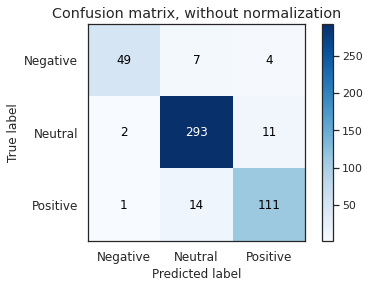

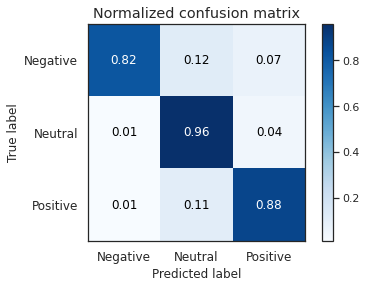

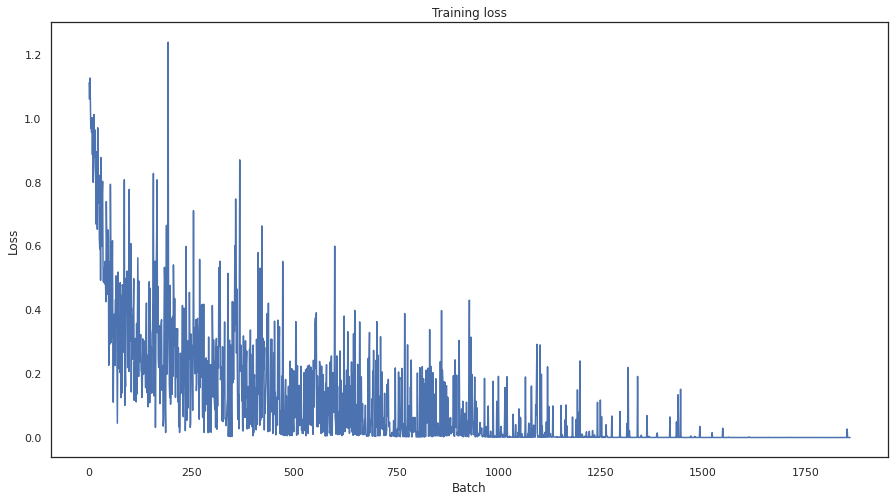

[2020-09-20 10:41:35,861][INFO] ## ================     fold 6        ===============
[2020-09-20 10:41:35,861][INFO] ## ================     fold 6        ===============
[2020-09-20 10:41:35,861][INFO] ## ================     fold 6        ===============
[2020-09-20 10:41:35,861][INFO] ## ================     fold 6        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining mode

[2020-09-20 10:42:38,844][INFO] ## epoch: 1, train loss: 0.61401933, valid loss: 0.33154774, acc: 0.89024, f1: 0.875349, best_f1: 0.87535
, last lr: 0.000050
[2020-09-20 10:42:38,844][INFO] ## epoch: 1, train loss: 0.61401933, valid loss: 0.33154774, acc: 0.89024, f1: 0.875349, best_f1: 0.87535
, last lr: 0.000050
[2020-09-20 10:42:38,844][INFO] ## epoch: 1, train loss: 0.61401933, valid loss: 0.33154774, acc: 0.89024, f1: 0.875349, best_f1: 0.87535
, last lr: 0.000050
[2020-09-20 10:42:38,844][INFO] ## epoch: 1, train loss: 0.61401933, valid loss: 0.33154774, acc: 0.89024, f1: 0.875349, best_f1: 0.87535
, last lr: 0.000050
[2020-09-20 10:42:38,955][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:42:38,955][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:42:38,955][INFO] ## ================     epoch 2        ===============
[2020-09-20 10:42:38,955][INFO] ## ================     epoch 2        ===============


[2020-09-20 10:43:33,643][INFO] ## epoch: 2, train loss: 0.32785608, valid loss: 0.31284882, acc: 0.89228, f1: 0.852913, best_f1: 0.87535
, last lr: 0.000100
[2020-09-20 10:43:33,643][INFO] ## epoch: 2, train loss: 0.32785608, valid loss: 0.31284882, acc: 0.89228, f1: 0.852913, best_f1: 0.87535
, last lr: 0.000100
[2020-09-20 10:43:33,643][INFO] ## epoch: 2, train loss: 0.32785608, valid loss: 0.31284882, acc: 0.89228, f1: 0.852913, best_f1: 0.87535
, last lr: 0.000100
[2020-09-20 10:43:33,643][INFO] ## epoch: 2, train loss: 0.32785608, valid loss: 0.31284882, acc: 0.89228, f1: 0.852913, best_f1: 0.87535
, last lr: 0.000100
[2020-09-20 10:43:33,754][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:43:33,754][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:43:33,754][INFO] ## ================     epoch 3        ===============
[2020-09-20 10:43:33,754][INFO] ## ================     epoch 3        ===============


[2020-09-20 10:44:28,481][INFO] ## epoch: 3, train loss: 0.25503150, valid loss: 0.48421766, acc: 0.85569, f1: 0.829223, best_f1: 0.87535
, last lr: 0.000094
[2020-09-20 10:44:28,481][INFO] ## epoch: 3, train loss: 0.25503150, valid loss: 0.48421766, acc: 0.85569, f1: 0.829223, best_f1: 0.87535
, last lr: 0.000094
[2020-09-20 10:44:28,481][INFO] ## epoch: 3, train loss: 0.25503150, valid loss: 0.48421766, acc: 0.85569, f1: 0.829223, best_f1: 0.87535
, last lr: 0.000094
[2020-09-20 10:44:28,481][INFO] ## epoch: 3, train loss: 0.25503150, valid loss: 0.48421766, acc: 0.85569, f1: 0.829223, best_f1: 0.87535
, last lr: 0.000094
[2020-09-20 10:44:28,595][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:44:28,595][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:44:28,595][INFO] ## ================     epoch 4        ===============
[2020-09-20 10:44:28,595][INFO] ## ================     epoch 4        ===============


[2020-09-20 10:45:25,532][INFO] ## epoch: 4, train loss: 0.24199781, valid loss: 0.31298794, acc: 0.92683, f1: 0.904264, best_f1: 0.90426
, last lr: 0.000089
[2020-09-20 10:45:25,532][INFO] ## epoch: 4, train loss: 0.24199781, valid loss: 0.31298794, acc: 0.92683, f1: 0.904264, best_f1: 0.90426
, last lr: 0.000089
[2020-09-20 10:45:25,532][INFO] ## epoch: 4, train loss: 0.24199781, valid loss: 0.31298794, acc: 0.92683, f1: 0.904264, best_f1: 0.90426
, last lr: 0.000089
[2020-09-20 10:45:25,532][INFO] ## epoch: 4, train loss: 0.24199781, valid loss: 0.31298794, acc: 0.92683, f1: 0.904264, best_f1: 0.90426
, last lr: 0.000089
[2020-09-20 10:45:25,652][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:45:25,652][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:45:25,652][INFO] ## ================     epoch 5        ===============
[2020-09-20 10:45:25,652][INFO] ## ================     epoch 5        ===============


[2020-09-20 10:46:20,144][INFO] ## epoch: 5, train loss: 0.15868702, valid loss: 0.40924331, acc: 0.90041, f1: 0.876513, best_f1: 0.90426
, last lr: 0.000083
[2020-09-20 10:46:20,144][INFO] ## epoch: 5, train loss: 0.15868702, valid loss: 0.40924331, acc: 0.90041, f1: 0.876513, best_f1: 0.90426
, last lr: 0.000083
[2020-09-20 10:46:20,144][INFO] ## epoch: 5, train loss: 0.15868702, valid loss: 0.40924331, acc: 0.90041, f1: 0.876513, best_f1: 0.90426
, last lr: 0.000083
[2020-09-20 10:46:20,144][INFO] ## epoch: 5, train loss: 0.15868702, valid loss: 0.40924331, acc: 0.90041, f1: 0.876513, best_f1: 0.90426
, last lr: 0.000083
[2020-09-20 10:46:20,256][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:46:20,256][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:46:20,256][INFO] ## ================     epoch 6        ===============
[2020-09-20 10:46:20,256][INFO] ## ================     epoch 6        ===============


[2020-09-20 10:47:14,676][INFO] ## epoch: 6, train loss: 0.12967196, valid loss: 0.45813632, acc: 0.89837, f1: 0.859241, best_f1: 0.90426
, last lr: 0.000078
[2020-09-20 10:47:14,676][INFO] ## epoch: 6, train loss: 0.12967196, valid loss: 0.45813632, acc: 0.89837, f1: 0.859241, best_f1: 0.90426
, last lr: 0.000078
[2020-09-20 10:47:14,676][INFO] ## epoch: 6, train loss: 0.12967196, valid loss: 0.45813632, acc: 0.89837, f1: 0.859241, best_f1: 0.90426
, last lr: 0.000078
[2020-09-20 10:47:14,676][INFO] ## epoch: 6, train loss: 0.12967196, valid loss: 0.45813632, acc: 0.89837, f1: 0.859241, best_f1: 0.90426
, last lr: 0.000078
[2020-09-20 10:47:14,790][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:47:14,790][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:47:14,790][INFO] ## ================     epoch 7        ===============
[2020-09-20 10:47:14,790][INFO] ## ================     epoch 7        ===============


[2020-09-20 10:48:11,337][INFO] ## epoch: 7, train loss: 0.08210126, valid loss: 0.35188328, acc: 0.92480, f1: 0.904824, best_f1: 0.90482
, last lr: 0.000072
[2020-09-20 10:48:11,337][INFO] ## epoch: 7, train loss: 0.08210126, valid loss: 0.35188328, acc: 0.92480, f1: 0.904824, best_f1: 0.90482
, last lr: 0.000072
[2020-09-20 10:48:11,337][INFO] ## epoch: 7, train loss: 0.08210126, valid loss: 0.35188328, acc: 0.92480, f1: 0.904824, best_f1: 0.90482
, last lr: 0.000072
[2020-09-20 10:48:11,337][INFO] ## epoch: 7, train loss: 0.08210126, valid loss: 0.35188328, acc: 0.92480, f1: 0.904824, best_f1: 0.90482
, last lr: 0.000072
[2020-09-20 10:48:11,455][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:48:11,455][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:48:11,455][INFO] ## ================     epoch 8        ===============
[2020-09-20 10:48:11,455][INFO] ## ================     epoch 8        ===============


[2020-09-20 10:49:05,649][INFO] ## epoch: 8, train loss: 0.05819703, valid loss: 0.43578197, acc: 0.92480, f1: 0.904443, best_f1: 0.90482
, last lr: 0.000067
[2020-09-20 10:49:05,649][INFO] ## epoch: 8, train loss: 0.05819703, valid loss: 0.43578197, acc: 0.92480, f1: 0.904443, best_f1: 0.90482
, last lr: 0.000067
[2020-09-20 10:49:05,649][INFO] ## epoch: 8, train loss: 0.05819703, valid loss: 0.43578197, acc: 0.92480, f1: 0.904443, best_f1: 0.90482
, last lr: 0.000067
[2020-09-20 10:49:05,649][INFO] ## epoch: 8, train loss: 0.05819703, valid loss: 0.43578197, acc: 0.92480, f1: 0.904443, best_f1: 0.90482
, last lr: 0.000067
[2020-09-20 10:49:05,764][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:49:05,764][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:49:05,764][INFO] ## ================     epoch 9        ===============
[2020-09-20 10:49:05,764][INFO] ## ================     epoch 9        ===============


[2020-09-20 10:49:59,876][INFO] ## epoch: 9, train loss: 0.05075363, valid loss: 0.56815732, acc: 0.92276, f1: 0.897965, best_f1: 0.90482
, last lr: 0.000061
[2020-09-20 10:49:59,876][INFO] ## epoch: 9, train loss: 0.05075363, valid loss: 0.56815732, acc: 0.92276, f1: 0.897965, best_f1: 0.90482
, last lr: 0.000061
[2020-09-20 10:49:59,876][INFO] ## epoch: 9, train loss: 0.05075363, valid loss: 0.56815732, acc: 0.92276, f1: 0.897965, best_f1: 0.90482
, last lr: 0.000061
[2020-09-20 10:49:59,876][INFO] ## epoch: 9, train loss: 0.05075363, valid loss: 0.56815732, acc: 0.92276, f1: 0.897965, best_f1: 0.90482
, last lr: 0.000061
[2020-09-20 10:49:59,992][INFO] ## ================     epoch 10        ===============
[2020-09-20 10:49:59,992][INFO] ## ================     epoch 10        ===============
[2020-09-20 10:49:59,992][INFO] ## ================     epoch 10        ===============
[2020-09-20 10:49:59,992][INFO] ## ================     epoch 10        ===============


[2020-09-20 10:50:53,986][INFO] ## epoch: 10, train loss: 0.04863538, valid loss: 0.42166122, acc: 0.92276, f1: 0.897835, best_f1: 0.90482
, last lr: 0.000056
[2020-09-20 10:50:53,986][INFO] ## epoch: 10, train loss: 0.04863538, valid loss: 0.42166122, acc: 0.92276, f1: 0.897835, best_f1: 0.90482
, last lr: 0.000056
[2020-09-20 10:50:53,986][INFO] ## epoch: 10, train loss: 0.04863538, valid loss: 0.42166122, acc: 0.92276, f1: 0.897835, best_f1: 0.90482
, last lr: 0.000056
[2020-09-20 10:50:53,986][INFO] ## epoch: 10, train loss: 0.04863538, valid loss: 0.42166122, acc: 0.92276, f1: 0.897835, best_f1: 0.90482
, last lr: 0.000056
[2020-09-20 10:50:54,100][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:50:54,100][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:50:54,100][INFO] ## ================     epoch 11        ===============
[2020-09-20 10:50:54,100][INFO] ## ================     epoch 11        ===============


[2020-09-20 10:51:50,395][INFO] ## epoch: 11, train loss: 0.03542881, valid loss: 0.42775476, acc: 0.93089, f1: 0.913027, best_f1: 0.91303
, last lr: 0.000050
[2020-09-20 10:51:50,395][INFO] ## epoch: 11, train loss: 0.03542881, valid loss: 0.42775476, acc: 0.93089, f1: 0.913027, best_f1: 0.91303
, last lr: 0.000050
[2020-09-20 10:51:50,395][INFO] ## epoch: 11, train loss: 0.03542881, valid loss: 0.42775476, acc: 0.93089, f1: 0.913027, best_f1: 0.91303
, last lr: 0.000050
[2020-09-20 10:51:50,395][INFO] ## epoch: 11, train loss: 0.03542881, valid loss: 0.42775476, acc: 0.93089, f1: 0.913027, best_f1: 0.91303
, last lr: 0.000050
[2020-09-20 10:51:50,520][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:51:50,520][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:51:50,520][INFO] ## ================     epoch 12        ===============
[2020-09-20 10:51:50,520][INFO] ## ================     epoch 12        ===============


[2020-09-20 10:52:45,069][INFO] ## epoch: 12, train loss: 0.03047119, valid loss: 0.46415484, acc: 0.92683, f1: 0.904936, best_f1: 0.91303
, last lr: 0.000044
[2020-09-20 10:52:45,069][INFO] ## epoch: 12, train loss: 0.03047119, valid loss: 0.46415484, acc: 0.92683, f1: 0.904936, best_f1: 0.91303
, last lr: 0.000044
[2020-09-20 10:52:45,069][INFO] ## epoch: 12, train loss: 0.03047119, valid loss: 0.46415484, acc: 0.92683, f1: 0.904936, best_f1: 0.91303
, last lr: 0.000044
[2020-09-20 10:52:45,069][INFO] ## epoch: 12, train loss: 0.03047119, valid loss: 0.46415484, acc: 0.92683, f1: 0.904936, best_f1: 0.91303
, last lr: 0.000044
[2020-09-20 10:52:45,181][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:52:45,181][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:52:45,181][INFO] ## ================     epoch 13        ===============
[2020-09-20 10:52:45,181][INFO] ## ================     epoch 13        ===============


[2020-09-20 10:53:41,540][INFO] ## epoch: 13, train loss: 0.02610469, valid loss: 0.44094910, acc: 0.93089, f1: 0.914517, best_f1: 0.91452
, last lr: 0.000039
[2020-09-20 10:53:41,540][INFO] ## epoch: 13, train loss: 0.02610469, valid loss: 0.44094910, acc: 0.93089, f1: 0.914517, best_f1: 0.91452
, last lr: 0.000039
[2020-09-20 10:53:41,540][INFO] ## epoch: 13, train loss: 0.02610469, valid loss: 0.44094910, acc: 0.93089, f1: 0.914517, best_f1: 0.91452
, last lr: 0.000039
[2020-09-20 10:53:41,540][INFO] ## epoch: 13, train loss: 0.02610469, valid loss: 0.44094910, acc: 0.93089, f1: 0.914517, best_f1: 0.91452
, last lr: 0.000039
[2020-09-20 10:53:41,656][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:53:41,656][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:53:41,656][INFO] ## ================     epoch 14        ===============
[2020-09-20 10:53:41,656][INFO] ## ================     epoch 14        ===============


[2020-09-20 10:54:35,552][INFO] ## epoch: 14, train loss: 0.00434759, valid loss: 0.50777649, acc: 0.92886, f1: 0.910770, best_f1: 0.91452
, last lr: 0.000033
[2020-09-20 10:54:35,552][INFO] ## epoch: 14, train loss: 0.00434759, valid loss: 0.50777649, acc: 0.92886, f1: 0.910770, best_f1: 0.91452
, last lr: 0.000033
[2020-09-20 10:54:35,552][INFO] ## epoch: 14, train loss: 0.00434759, valid loss: 0.50777649, acc: 0.92886, f1: 0.910770, best_f1: 0.91452
, last lr: 0.000033
[2020-09-20 10:54:35,552][INFO] ## epoch: 14, train loss: 0.00434759, valid loss: 0.50777649, acc: 0.92886, f1: 0.910770, best_f1: 0.91452
, last lr: 0.000033
[2020-09-20 10:54:35,663][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:54:35,663][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:54:35,663][INFO] ## ================     epoch 15        ===============
[2020-09-20 10:54:35,663][INFO] ## ================     epoch 15        ===============


[2020-09-20 10:55:29,456][INFO] ## epoch: 15, train loss: 0.00316969, valid loss: 0.55798504, acc: 0.92683, f1: 0.906154, best_f1: 0.91452
, last lr: 0.000028
[2020-09-20 10:55:29,456][INFO] ## epoch: 15, train loss: 0.00316969, valid loss: 0.55798504, acc: 0.92683, f1: 0.906154, best_f1: 0.91452
, last lr: 0.000028
[2020-09-20 10:55:29,456][INFO] ## epoch: 15, train loss: 0.00316969, valid loss: 0.55798504, acc: 0.92683, f1: 0.906154, best_f1: 0.91452
, last lr: 0.000028
[2020-09-20 10:55:29,456][INFO] ## epoch: 15, train loss: 0.00316969, valid loss: 0.55798504, acc: 0.92683, f1: 0.906154, best_f1: 0.91452
, last lr: 0.000028
[2020-09-20 10:55:29,574][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:55:29,574][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:55:29,574][INFO] ## ================     epoch 16        ===============
[2020-09-20 10:55:29,574][INFO] ## ================     epoch 16        ===============


[2020-09-20 10:56:23,388][INFO] ## epoch: 16, train loss: 0.00097630, valid loss: 0.58968680, acc: 0.92683, f1: 0.905190, best_f1: 0.91452
, last lr: 0.000022
[2020-09-20 10:56:23,388][INFO] ## epoch: 16, train loss: 0.00097630, valid loss: 0.58968680, acc: 0.92683, f1: 0.905190, best_f1: 0.91452
, last lr: 0.000022
[2020-09-20 10:56:23,388][INFO] ## epoch: 16, train loss: 0.00097630, valid loss: 0.58968680, acc: 0.92683, f1: 0.905190, best_f1: 0.91452
, last lr: 0.000022
[2020-09-20 10:56:23,388][INFO] ## epoch: 16, train loss: 0.00097630, valid loss: 0.58968680, acc: 0.92683, f1: 0.905190, best_f1: 0.91452
, last lr: 0.000022
[2020-09-20 10:56:23,502][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:56:23,502][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:56:23,502][INFO] ## ================     epoch 17        ===============
[2020-09-20 10:56:23,502][INFO] ## ================     epoch 17        ===============


[2020-09-20 10:57:17,262][INFO] ## epoch: 17, train loss: 0.00030201, valid loss: 0.60906563, acc: 0.92480, f1: 0.901361, best_f1: 0.91452
, last lr: 0.000017
[2020-09-20 10:57:17,262][INFO] ## epoch: 17, train loss: 0.00030201, valid loss: 0.60906563, acc: 0.92480, f1: 0.901361, best_f1: 0.91452
, last lr: 0.000017
[2020-09-20 10:57:17,262][INFO] ## epoch: 17, train loss: 0.00030201, valid loss: 0.60906563, acc: 0.92480, f1: 0.901361, best_f1: 0.91452
, last lr: 0.000017
[2020-09-20 10:57:17,262][INFO] ## epoch: 17, train loss: 0.00030201, valid loss: 0.60906563, acc: 0.92480, f1: 0.901361, best_f1: 0.91452
, last lr: 0.000017
[2020-09-20 10:57:17,375][INFO] ## ================     epoch 18        ===============
[2020-09-20 10:57:17,375][INFO] ## ================     epoch 18        ===============
[2020-09-20 10:57:17,375][INFO] ## ================     epoch 18        ===============
[2020-09-20 10:57:17,375][INFO] ## ================     epoch 18        ===============


[2020-09-20 10:58:11,162][INFO] ## epoch: 18, train loss: 0.00310649, valid loss: 0.56673546, acc: 0.92683, f1: 0.907261, best_f1: 0.91452
, last lr: 0.000011
[2020-09-20 10:58:11,162][INFO] ## epoch: 18, train loss: 0.00310649, valid loss: 0.56673546, acc: 0.92683, f1: 0.907261, best_f1: 0.91452
, last lr: 0.000011
[2020-09-20 10:58:11,162][INFO] ## epoch: 18, train loss: 0.00310649, valid loss: 0.56673546, acc: 0.92683, f1: 0.907261, best_f1: 0.91452
, last lr: 0.000011
[2020-09-20 10:58:11,162][INFO] ## epoch: 18, train loss: 0.00310649, valid loss: 0.56673546, acc: 0.92683, f1: 0.907261, best_f1: 0.91452
, last lr: 0.000011
[2020-09-20 10:58:11,275][INFO] ## ================     epoch 19        ===============
[2020-09-20 10:58:11,275][INFO] ## ================     epoch 19        ===============
[2020-09-20 10:58:11,275][INFO] ## ================     epoch 19        ===============
[2020-09-20 10:58:11,275][INFO] ## ================     epoch 19        ===============


[2020-09-20 10:59:05,028][INFO] ## epoch: 19, train loss: 0.00023974, valid loss: 0.57362245, acc: 0.92683, f1: 0.907261, best_f1: 0.91452
, last lr: 0.000006
[2020-09-20 10:59:05,028][INFO] ## epoch: 19, train loss: 0.00023974, valid loss: 0.57362245, acc: 0.92683, f1: 0.907261, best_f1: 0.91452
, last lr: 0.000006
[2020-09-20 10:59:05,028][INFO] ## epoch: 19, train loss: 0.00023974, valid loss: 0.57362245, acc: 0.92683, f1: 0.907261, best_f1: 0.91452
, last lr: 0.000006
[2020-09-20 10:59:05,028][INFO] ## epoch: 19, train loss: 0.00023974, valid loss: 0.57362245, acc: 0.92683, f1: 0.907261, best_f1: 0.91452
, last lr: 0.000006
[2020-09-20 10:59:05,147][INFO] ## ================     epoch 20        ===============
[2020-09-20 10:59:05,147][INFO] ## ================     epoch 20        ===============
[2020-09-20 10:59:05,147][INFO] ## ================     epoch 20        ===============
[2020-09-20 10:59:05,147][INFO] ## ================     epoch 20        ===============


[2020-09-20 10:59:58,928][INFO] ## epoch: 20, train loss: 0.00024793, valid loss: 0.57802293, acc: 0.92480, f1: 0.903487, best_f1: 0.91452
, last lr: 0.000000
[2020-09-20 10:59:58,928][INFO] ## epoch: 20, train loss: 0.00024793, valid loss: 0.57802293, acc: 0.92480, f1: 0.903487, best_f1: 0.91452
, last lr: 0.000000
[2020-09-20 10:59:58,928][INFO] ## epoch: 20, train loss: 0.00024793, valid loss: 0.57802293, acc: 0.92480, f1: 0.903487, best_f1: 0.91452
, last lr: 0.000000
[2020-09-20 10:59:58,928][INFO] ## epoch: 20, train loss: 0.00024793, valid loss: 0.57802293, acc: 0.92480, f1: 0.903487, best_f1: 0.91452
, last lr: 0.000000
No handles with labels found to put in legend.


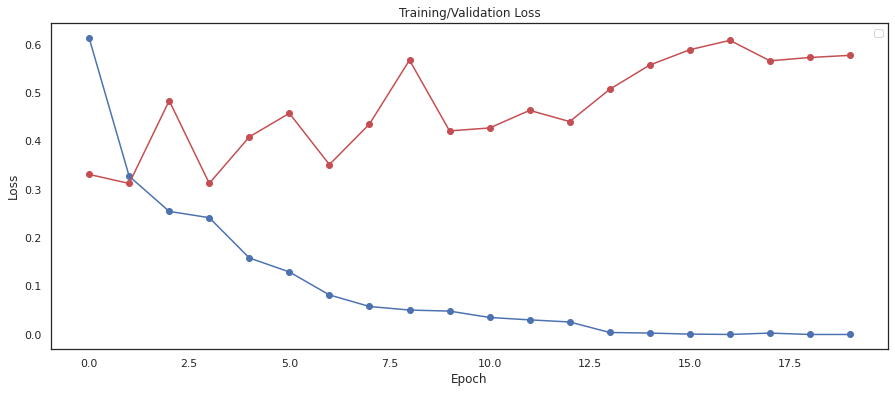

[2020-09-20 11:00:03,089][INFO] ## epoch: best, acc: 0.93089431, f1: 0.91451674, best_f1: 0.91451674

[2020-09-20 11:00:03,089][INFO] ## epoch: best, acc: 0.93089431, f1: 0.91451674, best_f1: 0.91451674

[2020-09-20 11:00:03,089][INFO] ## epoch: best, acc: 0.93089431, f1: 0.91451674, best_f1: 0.91451674

[2020-09-20 11:00:03,089][INFO] ## epoch: best, acc: 0.93089431, f1: 0.91451674, best_f1: 0.91451674



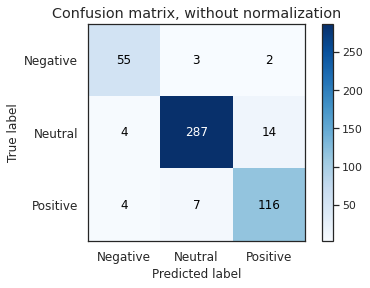

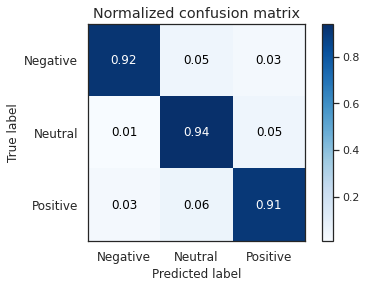

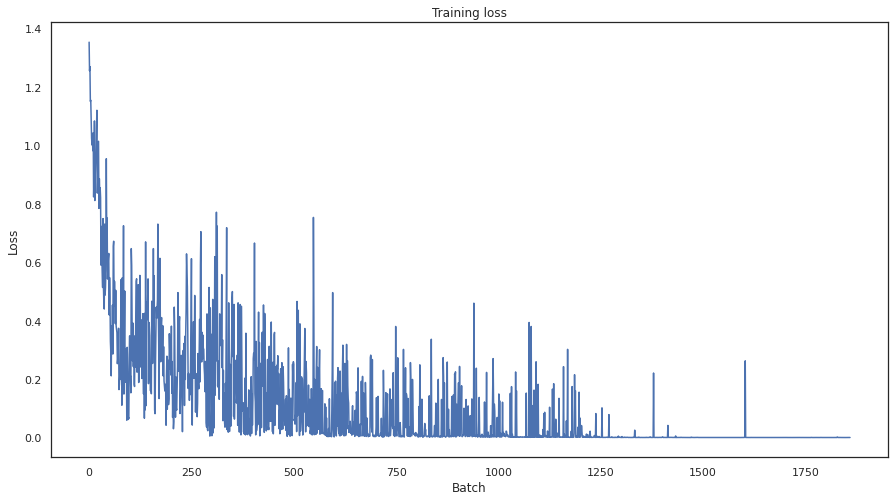

In [112]:
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

best_f1 = 0
best_acc = 0
best_fold = 0
  
for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
    bert_model_trained, acc, f1 = train_bert(fold, train_indices, valid_indices)

    if best_f1 < f1:
        best_f1 = f1
        best_acc = acc
        best_fold = fold
        best_bert_model = bert_model_trained

    # Stop after this fold
    if fold == 10:
        break


## Result

In [113]:
result_df.loc['E: BERT'] = (round(best_acc,4), round(best_f1,4))
result_df

Accuracy      F1
A: Lexicon      0.6522  0.4506
B: Tfidf        0.8145  0.7195
C: LSTM         0.8185  0.7657
D: LSTM+GloVe   0.8051  0.7415
E: BERT         0.9493  0.9267
F: ALBERT          NaN     NaN

In [114]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))

train_df['pred_target'] = np.argmax(oof_train, axis=1)
train_df['pred_target_lower'] = oof_train[:,0]
train_df['pred_target_hold'] = oof_train[:,1]
train_df['pred_target_raise'] = oof_train[:,2]
train_df.head()

[2020-09-20 11:00:04,018][INFO] ## 0.8973588966474045
[2020-09-20 11:00:04,018][INFO] ## 0.8973588966474045
[2020-09-20 11:00:04,018][INFO] ## 0.8973588966474045
[2020-09-20 11:00:04,018][INFO] ## 0.8973588966474045


sentence  ...  pred_target_raise
0  According to Gran , the company has no plans t...  ...           0.001400
1  With the new production plant the company woul...  ...           0.999553
2  For the last quarter of 2010 , Componenta 's n...  ...           0.998412
3  In the third quarter of 2010 , net sales incre...  ...           0.999636
4  Operating profit rose to EUR 13.1 mn from EUR ...  ...           0.999641

[5 rows x 6 columns]

# F: ALBERT

In [27]:
from torch.utils.data import DataLoader, Dataset
#from transformers import *
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AlbertModel
from transformers import AdamW as AdamW_Hf, get_linear_schedule_with_warmup

In [28]:
# Set Tokenizer and Model
tokenizer = AlbertTokenizer.from_pretrained('albert-xlarge-v2', do_lower_case=True)
albert_model = AlbertForSequenceClassification.from_pretrained('albert-xlarge-v2', num_labels=3)

Some weights of the model checkpoint at albert-xlarge-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-xlarge-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You

In [29]:
# Test tokenizer
# tokenizer.encode() returns only input_ids, whereas tokenizer() returns dict
inputs = tokenizer("Hello, my dog is cute", 
                   return_tensors="pt", 
                   pad_to_max_length=True, 
                   max_length = 64,
                   add_special_tokens=True,
                   padding_side='right')
print('inputs: \n', inputs)

print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = albert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'padding_side': 'right'} not recognized.


inputs: 
 {'input_ids': tensor([[    2, 10975,    15,    51,  1952,    25, 10901,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Looks `padding_side` argument does not exist. The others look fine.

In [30]:
# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

In [31]:
# Hyperparameters
max_seq_length = 48
learning_rate = 1e-5
num_epochs = 10
batch_size = 16
patience = 5
warm_up_proportion = 0.2
max_grad_norm = 1.0

In [32]:
def train_transformer(model, x_train, y_train, x_valid, y_valid, out_model_name):
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Load data into SimpleDataset
    train_ds = SimpleDataset(x_train, y_train)
    valid_ds = SimpleDataset(x_valid, y_valid)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), num_epochs))
    
    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    # To reproduce BertAdam specific behavior set correct_bias=False
    optimizer = AdamW_Hf(model.parameters(), lr=learning_rate, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    # Set Train Mode
    model.train()
    
    # Tokenizer Parameter
    param_tk = {
        'return_tensors': "pt",
        'pad_to_max_length': True,
        'max_length': max_seq_length,
        'add_special_tokens': True,
        'truncation': True
    }

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((len(y_valid), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}     ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Input features and labels from batch and move to device
            x_train_bt, y_train_bt = batch
            x_train_bt = tokenizer(x_train_bt, **param_tk).to(device)
            y_train_bt = torch.tensor(y_train_bt, dtype=torch.long).to(device)
            
            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = model(**x_train_bt, labels=y_train_bt)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        #valid_preds_fold = np.zeros((y_valid.size(0), 3))
        y_valid_pred = np.zeros((len(y_valid), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                # Input features and labels from batch and move to device
                x_valid_bt, y_valid_bt = batch
                x_valid_bt = tokenizer(x_valid_bt, **param_tk).to(device)
                y_valid_bt = torch.tensor(y_valid_bt, dtype=torch.long).to(device)
            
                loss, logits = model(**x_valid_bt, labels=y_valid_bt)
                val_loss += loss.item() / len(valid_loader)
                y_valid_pred[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
        valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(y_valid, np.argmax(y_valid_pred, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = y_valid_pred
            torch.save(model.state_dict(), output_dir + out_model_name)
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.5f, f1: %5f, best_f1: %.5f\n, last lr: %.6f' %
            (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        model.train()

    # Once all epochs are done, output summaries
    logger.info('================ Training Completed: Starting Post Process ===============')
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'r-o')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    ## Load the best model
    #model.load_state_dict(torch.load(output_dir + out_model_name))
    ## Set the model to Evaluation Mode
    #model.eval()
    
    # Check the metrics for the validation set
    acc, f1 = metric(y_valid, np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    pred_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, pred_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    return acc, f1, valid_best

In [33]:
# Run the training with Stratified KFold
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=rand_seed)

# Input Data
x_all = np.array(train_df['sentence'])
y_all = np.array(train_df['label'].astype(int).values)
oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

# Set Log Level
logger.setLevel(logging.INFO)

best_f1, best_acc, best_fold = 0, 0, 0

for n_fold, (train_indices, valid_indices) in enumerate(skf.split(y_all, y_all)):
    logger.info('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train = x_all[train_indices]
    y_train = y_all[train_indices]
    # Input validation data for this fold
    x_valid = x_all[valid_indices]
    y_valid = y_all[valid_indices]
    
    out_model_name = 'albert_model_best_fold{}.dict'.format(n_fold)
    
    acc, f1, valid_best = train_transformer(albert_model, x_train, y_train, x_valid, y_valid, out_model_name)
    oof_train[valid_indices] = valid_best

    if best_f1 < f1:
        best_f1 = f1
        best_acc = acc
        best_fold = n_fold
    
    # Number of folds to iterrate
    if n_fold == 3:
        break

[2020-09-21 05:27:17,756][INFO] ## ================     fold 1    ===============
[2020-09-21 05:27:31,433][INFO] ## Total Training Steps: 1850 (185 batches x 10 epochs)
[2020-09-21 05:27:31,434][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


NameError: ignored

## Result

In [122]:
result_df.loc['F: ALBERT'] = (round(best_acc,4), round(best_f1,4))
result_df

Accuracy      F1
A: Lexicon      0.6522  0.4506
B: Tfidf        0.8145  0.7195
C: LSTM         0.8185  0.7657
D: LSTM+GloVe   0.8051  0.7415
E: BERT         0.9493  0.9267
F: ALBERT       0.9067  0.8849

In [123]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))

train_df['pred_target'] = np.argmax(oof_train, axis=1)
train_df['pred_target_lower'] = oof_train[:,0]
train_df['pred_target_hold'] = oof_train[:,1]
train_df['pred_target_raise'] = oof_train[:,2]
train_df.head()

[2020-09-20 12:32:05,250][INFO] ## 0.4329681531366912
[2020-09-20 12:32:05,250][INFO] ## 0.4329681531366912
[2020-09-20 12:32:05,250][INFO] ## 0.4329681531366912
[2020-09-20 12:32:05,250][INFO] ## 0.4329681531366912


sentence  ...  pred_target_raise
0  According to Gran , the company has no plans t...  ...            0.00000
1  With the new production plant the company woul...  ...            0.96793
2  For the last quarter of 2010 , Componenta 's n...  ...            0.92086
3  In the third quarter of 2010 , net sales incre...  ...            0.00000
4  Operating profit rose to EUR 13.1 mn from EUR ...  ...            0.00000

[5 rows x 6 columns]

# Final Result

In [130]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = False
If disconnected:
    result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C: LSTM', 'D: LSTM+GloVe', 'E: BERT', 'F: ALBERT'])
    result_df.loc['A: Lexicon'] = (0.6522,0.4506)
    result_df.loc['B: Tfidf'] = (0.8145,0.7195)
    result_df.loc['C: LSTM'] = (0.8185,0.7657)
    result_df.loc['D: LSTM+GloVe'] = (0.8051,0.7415)
    result_df.loc['E: BERT'] = (0.9493,0.9267)
    result_df.loc['F: ALBERT'] = (0.9067,0.8849)


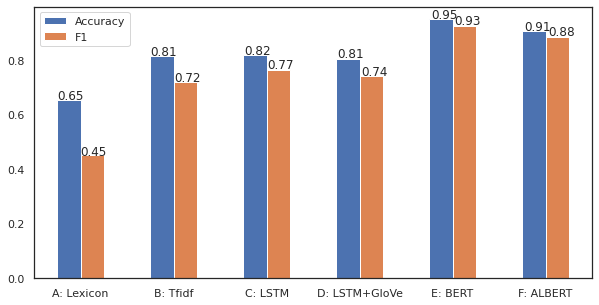

In [140]:
ax = result_df.plot.bar(rot=0, figsize=(10,5))

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Save Data

In [126]:
def save_data(df, file_name, dir_name=output_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [127]:
# Save text data
save_data(train_df, 'finphrase_result_df')